# MULTIVARIATE DNN (CNN, MULTI-HEADED-ATTENTION, LSTM) FOR MULTI-STEP FORECAST

Hey Kagglers! 👋 Excited to share my first Kaggle competition journey with you. 🚀 Instead of using a public baseline notebook, I crafted my own preprocessing pipeline and dove into experimenting with various DNN structures. Although my model didn't shine on the leaderboard, the learning experience was invaluable. Huge thanks to the hosts for providing this opportunity to work with the dataset and compete alongside amazing Kagglers.

My curiosity led me to explore timeseries forecasting with DNN, inspired by Google Research's temporal fusion transformer. While I didn't find similar public notebooks, I came across discussions mentioning experiments with multiheaded attention and seq-seq RNN models.

Now that the competition has concluded, and we're free from worries about copycats, I encourage fellow Kagglers to share innovative notebooks, regardless of leaderboard performance. I believe knowledge grows when shared! 😊 I'd love to see diverse approaches utilizing such architectures.

While my model isn't on par with the temporal fusion transformer due to limited resources and time, I've crafted a DNN structure with encoder blocks that delivers decent multistep predictions. In this notebook, I'll share the complete pipeline and the actual model, capable of producing predictions with a simple API call. I couldn't fine-tune much, except for the number of encoder blocks. Check out version 15 for the best-performing model, as my last-minute attempts to tune dropout rates didn't improve results.

I admit, the gather layers within the functional model may look odd. Initially, I didn't plan to partition input, but a single block performed poorly, forcing me to distribute and partition. While I acknowledge the unelegance of hardcoded indices inside the model, it was a workaround to avoid crashes during the load_model phase.

Feel free to explore the notebook, and I'm open to any insights or feedback. Let's keep the Kaggle spirit alive! 🌟 #KnowledgeSharing #KaggleCommunity


In [1]:
#Enabling memory growth for GPU
import tensorflow as tf
devices = tf.config.list_physical_devices()
print(f"TF Version:{tf.__version__} Devices: {devices}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TF Version:2.13.0 Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#from tensorflow.compat.v1 import ConfigProto
#from tensorflow.compat.v1 import GPUOptions
#from tensorflow.compat.v1 import Session

#from tensorflow.compat.v1 import InteractiveSession
#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = Session(config=config)
#try:
#    tf.config.set_logical_device_configuration(physical_devices[0],
#                                               [tf.config.LogicalDeviceConfiguration(memory_limit=4000)])
#except Exception as e:
#    print("failed to set hard limit on the total memory")

#gpu_options = GPUOptions(per_process_gpu_memory_fraction=0.90)
#config = ConfigProto(gpu_options=gpu_options)
#session = tf.compat.v1.Session(config=config)

#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#assert len(gpu_devices) > 0, "Not enough GPU hardware devices available"
#config = tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

In [4]:
import IPython
import IPython.display
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
import pandas as pd
import numpy as np
import gc
from tensorflow.keras.callbacks import Callback
from tensorflow import keras
from tensorflow.keras import backend as K
#import keras_tuner as kt

In [5]:
# for reproducibility
seed0=1337
np.random.seed(seed0)
tf.keras.utils.set_random_seed(seed0)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(seed0)

In [6]:
#to avoid seeing shortened text data in pandas cell
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',3000)

In [7]:
from datetime import datetime, timedelta, time

# Exploratory Data Analysis

In [8]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/enefitdnn/Screenshot from 2024-02-01 13-17-03.png
/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/pre

In [9]:
#helper function to read csv docs in to pandas dataframes
def read_csv(*args):
    df_list=[]
    for doc in args:
        df_list+=[pd.read_csv(doc)]
    return df_list

In [10]:
%%time
#reading csvs
DATA_DIR = "/kaggle/input/predict-energy-behavior-of-prosumers/"
#DATA_DIR= "/content/drive/My Drive/Colab Notebooks/Enefit/"

client,\
electricity_prices, \
forecast_weather,\
gas_prices,historical_weather,\
train =read_csv(DATA_DIR+"client.csv",\
DATA_DIR+"electricity_prices.csv", DATA_DIR+"forecast_weather.csv",\
DATA_DIR+"gas_prices.csv",DATA_DIR+"historical_weather.csv",\
DATA_DIR+"train.csv")

CPU times: user 15.4 s, sys: 1.45 s, total: 16.9 s
Wall time: 28.5 s


In [11]:
# checking memory usage
for df in [client,\
            electricity_prices, \
            forecast_weather,\
            gas_prices,historical_weather,\
            train]:
    display(df.memory_usage(deep=True).sum())

4820813

2568176

958863488

100774

362690152

282569408

In [12]:
# downsizing dfs
def shrink_size(*args):
    for df in args:
        #print("*"*66)
        #display(df.memory_usage(deep=True).sum())
        df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
        df[df.select_dtypes(np.int64).columns] = df.select_dtypes(np.int64).astype(np.int32)
        #display(df.memory_usage(deep=True).sum())
    return args

In [13]:
client,electricity_prices, gas_prices, forecast_weather,historical_weather,train = shrink_size(client,
                                                                           electricity_prices, gas_prices,
                                                                           forecast_weather,historical_weather,train)

In [14]:
%%time
#converting date columns to datetime utc
date_cols=['date','forecast_date','origin_date','origin_datetime','forecast_datetime','datetime']
def convert_dt(*dfs,date_cols):
    for df in dfs:
        for col in df.columns:
            if col in date_cols:
                df[col]=pd.to_datetime(df[col]) #,utc=True, format= "ISO8601"
    return dfs
client, \
electricity_prices, \
gas_prices,\
forecast_weather,\
historical_weather,\
train=convert_dt(client, \
electricity_prices, \
gas_prices,\
forecast_weather,\
historical_weather,\
train,\
date_cols=date_cols)

CPU times: user 1.71 s, sys: 78.2 ms, total: 1.79 s
Wall time: 1.8 s


In [15]:
%%time
# helper function to check out content and shape of datasets
def df_observe(**kwargs):
    for dname in kwargs:
        display("*"*33+"DataFrame Name: "+dname+" "+"*"*33, \
                kwargs[dname].shape,\
                kwargs[dname].head(2),\
                kwargs[dname].tail(2))
        print(" \n")
df_observe(client=client,\
electricity_prices=electricity_prices, \
gas_prices=gas_prices,
forecast_weather=forecast_weather,\
historical_weather=historical_weather,\
train=train)

'*********************************DataFrame Name: client *********************************'

(41919, 7)

product_type  county  eic_count  installed_capacity  is_business  \
0             1       0        108          952.890015            0   
1             2       0         17          166.399994            0   

        date  data_block_id  
0 2021-09-01              2  
1 2021-09-01              2

product_type  county  eic_count  installed_capacity  is_business  \
41917             1      15         20          624.500000            1   
41918             3      15         55         2188.199951            1   

            date  data_block_id  
41917 2023-05-29            637  
41918 2023-05-29            637

'*********************************DataFrame Name: electricity_prices *********************************'

(15286, 4)

forecast_date  euros_per_mwh         origin_date  data_block_id
0 2021-09-01 00:00:00      92.510002 2021-08-31 00:00:00              1
1 2021-09-01 01:00:00      88.900002 2021-08-31 01:00:00              1

forecast_date  euros_per_mwh         origin_date  data_block_id
15284 2023-05-30 22:00:00      82.089996 2023-05-29 22:00:00            637
15285 2023-05-30 23:00:00      -1.290000 2023-05-29 23:00:00            637

'*********************************DataFrame Name: gas_prices *********************************'

(637, 5)

forecast_date  lowest_price_per_mwh  highest_price_per_mwh origin_date  \
0    2021-09-01             45.230000              46.320000  2021-08-31   
1    2021-09-02             45.619999              46.290001  2021-09-01   

   data_block_id  
0              1  
1              2

forecast_date  lowest_price_per_mwh  highest_price_per_mwh origin_date  \
635    2023-05-29                 28.16                  36.98  2023-05-28   
636    2023-05-30                 29.00                  34.00  2023-05-29   

     data_block_id  
635            636  
636            637

'*********************************DataFrame Name: forecast_weather *********************************'

(3424512, 18)

latitude  longitude     origin_datetime  hours_ahead  temperature  \
0  57.599998  21.700001 2021-09-01 02:00:00            1    15.655787   
1  57.599998  22.200001 2021-09-01 02:00:00            1    13.003931   

    dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
0  11.553614         0.904816        0.019714             0.0   
1  10.689844         0.886322        0.004456             0.0   

   cloudcover_total  10_metre_u_wind_component  10_metre_v_wind_component  \
0          0.905899                  -0.411328                  -9.106137   
1          0.886658                   0.206347                  -5.355405   

   data_block_id   forecast_datetime  direct_solar_radiation  \
0              1 2021-09-01 03:00:00                     0.0   
1              1 2021-09-01 03:00:00                     0.0   

   surface_solar_radiation_downwards  snowfall  total_precipitation  
0                                0.0       0.0                  0.0  
1                                0.0       0.0                  0.0

latitude  longitude     origin_datetime  hours_ahead  temperature  \
3424510  59.700001  27.700001 2023-05-30 02:00:00           48    10.694117   
3424511  59.700001  28.200001 2023-05-30 02:00:00           48    11.233179   

         dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
3424510  7.009058         0.000000        0.505936        0.997314   
3424511  7.069238         0.703461        0.292313        0.934021   

         cloudcover_total  10_metre_u_wind_component  \
3424510          0.997498                   5.810060   
3424511          0.989716                   2.719728   

         10_metre_v_wind_component  data_block_id   forecast_datetime  \
3424510                  -4.338345            637 2023-06-01 02:00:00   
3424511                  -0.922939            637 2023-06-01 02:00:00   

         direct_solar_radiation  surface_solar_radiation_downwards  snowfall  \
3424510                     0.0                                0.0       0.0   
3424511                     0.0                                0.0       0.0   

         total_precipitation  
3424510                  0.0  
3424511                  0.0

'*********************************DataFrame Name: historical_weather *********************************'

(1710802, 18)

datetime  temperature  dewpoint  rain  snowfall  surface_pressure  \
0 2021-09-01         14.2      11.6   0.0       0.0       1015.900024   
1 2021-09-01         13.9      11.5   0.0       0.0       1010.700012   

   cloudcover_total  cloudcover_low  cloudcover_mid  cloudcover_high  \
0                31              31               0               11   
1                33              37               0                0   

   windspeed_10m  winddirection_10m  shortwave_radiation  \
0       7.083333                  8                  0.0   
1       5.111111                359                  0.0   

   direct_solar_radiation  diffuse_radiation   latitude  longitude  \
0                     0.0                0.0  57.599998  21.700001   
1                     0.0                0.0  57.599998  22.200001   

   data_block_id  
0            1.0  
1            1.0

datetime  temperature  dewpoint  rain  snowfall  \
1710800 2023-05-30 10:00:00         11.7       1.6   0.0       0.0   
1710801 2023-05-30 10:00:00         12.0       1.4   0.0       0.0   

         surface_pressure  cloudcover_total  cloudcover_low  cloudcover_mid  \
1710800       1019.000000                44               0              73   
1710801       1016.099976                38               0              63   

         cloudcover_high  windspeed_10m  winddirection_10m  \
1710800                0           3.50                307   
1710801                0           3.25                304   

         shortwave_radiation  direct_solar_radiation  diffuse_radiation  \
1710800                658.0                   521.0              137.0   
1710801                672.0                   550.0              122.0   

          latitude  longitude  data_block_id  
1710800  59.700001  27.700001          637.0  
1710801  59.700001  28.200001          637.0

'*********************************DataFrame Name: train *********************************'

(2018352, 9)

county  is_business  product_type     target  is_consumption   datetime  \
0       0            0             1   0.713000               0 2021-09-01   
1       0            0             1  96.589996               1 2021-09-01   

   data_block_id  row_id  prediction_unit_id  
0              0       0                   0  
1              0       1                   0

county  is_business  product_type      target  is_consumption  \
2018350      15            1             3    0.000000               0   
2018351      15            1             3  196.240005               1   

                   datetime  data_block_id   row_id  prediction_unit_id  
2018350 2023-05-31 23:00:00            637  2018350                  60  
2018351 2023-05-31 23:00:00            637  2018351                  60

 

CPU times: user 115 ms, sys: 9.69 ms, total: 125 ms
Wall time: 122 ms


In [16]:
# forecastdates are unique() for electricity and gas
print(electricity_prices['forecast_date'].value_counts().max(),gas_prices['forecast_date'].value_counts().max())

1 1


In [17]:
%%time
#casting categorical columns to vartype string
def df_cast_dfs_cat_columns(*dfs):
    cat_features=['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id',
         'row_id','prediction_unit_id']
    for df in dfs:
        convert_dict={}
        for col in df.columns:
            if col in cat_features:
                convert_dict[col]= 'string'
                df.__dict__.update(df.astype(convert_dict).__dict__)
    return dfs
client, \
electricity_prices, \
gas_prices,\
forecast_weather,\
historical_weather,\
train=df_cast_dfs_cat_columns(client, \
electricity_prices, \
gas_prices,\
forecast_weather,\
historical_weather,\
train)

CPU times: user 13.3 s, sys: 601 ms, total: 13.9 s
Wall time: 13.8 s


In [18]:
%%time
# helper function to check out content and shape of datasets
def df_observe_properties(**kwargs):
    for dname in kwargs:
        display("*"*33+"DataFrame Name: "+dname+" "+"*"*33)
        display(kwargs[dname].info(verbose = True,show_counts=True))
        display("*"*15+"category_columns_info"+"*"*15)
        cat_cols=kwargs[dname].select_dtypes(include=['string'])
        display(cat_cols.describe().T)
        display("*"*15+"date_columns_info"+"*"*15)
        date_cols=kwargs[dname].select_dtypes(include=['datetime64[ns]']) #,UTC
        display(date_cols.describe().T)
        display("*"*15+"numeric_columns_info"+"*"*15)
        display(kwargs[dname].describe().T)
        print(" \n")
df_observe_properties(client=client,\
electricity_prices=electricity_prices, \
gas_prices=gas_prices,\
forecast_weather=forecast_weather,\
historical_weather=historical_weather,\
train=train)

'*********************************DataFrame Name: client *********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_type        41919 non-null  string        
 1   county              41919 non-null  string        
 2   eic_count           41919 non-null  int32         
 3   installed_capacity  41919 non-null  float32       
 4   is_business         41919 non-null  string        
 5   date                41919 non-null  datetime64[ns]
 6   data_block_id       41919 non-null  string        
dtypes: datetime64[ns](1), float32(1), int32(1), string(4)
memory usage: 1.9 MB


None

'***************category_columns_info***************'

count unique  top   freq
product_type   41919      4    3  19080
county         41919     16    0   4422
is_business    41919      2    1  22501
data_block_id  41919    636  453     69

'***************date_columns_info***************'

count                           mean                  min  \
date  41919  2022-07-18 21:34:22.921348096  2021-09-01 00:00:00   

                      25%                  50%                  75%  \
date  2022-02-13 00:00:00  2022-07-20 00:00:00  2022-12-23 00:00:00   

                      max  
date  2023-05-29 00:00:00

'***************numeric_columns_info***************'

count                           mean  \
eic_count           41919.0                      73.345118   
installed_capacity  41919.0                    1450.771484   
date                  41919  2022-07-18 21:34:22.921348096   

                                    min                  25%  \
eic_count                           5.0                 13.0   
installed_capacity                  5.5           321.899994   
date                2021-09-01 00:00:00  2022-02-13 00:00:00   

                                    50%                  75%  \
eic_count                          32.0                 70.0   
installed_capacity           645.200012          1567.150024   
date                2022-07-20 00:00:00  2022-12-23 00:00:00   

                                    max          std  
eic_count                        1517.0   144.064389  
installed_capacity         19314.310547  2422.233154  
date                2023-05-29 00:00:00          NaN

'*********************************DataFrame Name: electricity_prices *********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  datetime64[ns]
 1   euros_per_mwh  15286 non-null  float32       
 2   origin_date    15286 non-null  datetime64[ns]
 3   data_block_id  15286 non-null  string        
dtypes: datetime64[ns](2), float32(1), string(1)
memory usage: 418.1 KB


None

'***************category_columns_info***************'

count unique top freq
data_block_id  15286    637   1   24

'***************date_columns_info***************'

count                           mean                  min  \
forecast_date  15286  2022-07-16 11:16:41.857909248  2021-09-01 00:00:00   
origin_date    15286  2022-07-15 11:16:41.857909248  2021-08-31 00:00:00   

                               25%                  50%                  75%  \
forecast_date  2022-02-07 05:15:00  2022-07-16 11:30:00  2022-12-22 16:45:00   
origin_date    2022-02-06 05:15:00  2022-07-15 11:30:00  2022-12-21 16:45:00   

                               max  
forecast_date  2023-05-30 23:00:00  
origin_date    2023-05-29 23:00:00

'***************numeric_columns_info***************'

count                           mean                  min  \
forecast_date    15286  2022-07-16 11:16:41.857909248  2021-09-01 00:00:00   
euros_per_mwh  15286.0                     157.064178               -10.06   
origin_date      15286  2022-07-15 11:16:41.857909248  2021-08-31 00:00:00   

                               25%                  50%                  75%  \
forecast_date  2022-02-07 05:15:00  2022-07-16 11:30:00  2022-12-22 16:45:00   
euros_per_mwh            85.290001           128.279999           199.797501   
origin_date    2022-02-06 05:15:00  2022-07-15 11:30:00  2022-12-21 16:45:00   

                               max         std  
forecast_date  2023-05-30 23:00:00         NaN  
euros_per_mwh               4000.0  121.148628  
origin_date    2023-05-29 23:00:00         NaN

'*********************************DataFrame Name: gas_prices *********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float32       
 2   highest_price_per_mwh  637 non-null    float32       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    string        
dtypes: datetime64[ns](2), float32(2), string(1)
memory usage: 20.0 KB


None

'***************category_columns_info***************'

count unique top freq
data_block_id   637    637   1    1

'***************date_columns_info***************'

count                 mean                  min  \
forecast_date   637  2022-07-16 00:00:00  2021-09-01 00:00:00   
origin_date     637  2022-07-15 00:00:00  2021-08-31 00:00:00   

                               25%                  50%                  75%  \
forecast_date  2022-02-07 00:00:00  2022-07-16 00:00:00  2022-12-22 00:00:00   
origin_date    2022-02-06 00:00:00  2022-07-15 00:00:00  2022-12-21 00:00:00   

                               max  
forecast_date  2023-05-30 00:00:00  
origin_date    2023-05-29 00:00:00

'***************numeric_columns_info***************'

count                 mean                  min  \
forecast_date            637  2022-07-16 00:00:00  2021-09-01 00:00:00   
lowest_price_per_mwh   637.0            95.036751                 28.1   
highest_price_per_mwh  637.0           107.754639                 34.0   
origin_date              637  2022-07-15 00:00:00  2021-08-31 00:00:00   

                                       25%                  50%  \
forecast_date          2022-02-07 00:00:00  2022-07-16 00:00:00   
lowest_price_per_mwh                  60.0            85.209999   
highest_price_per_mwh            67.529999            93.470001   
origin_date            2022-02-06 00:00:00  2022-07-15 00:00:00   

                                       75%                  max        std  
forecast_date          2022-12-22 00:00:00  2023-05-30 00:00:00        NaN  
lowest_price_per_mwh                 109.0                250.0  47.552296  
highest_price_per_mwh           130.740005                305.0  54.743664  
origin_date            2022-12-21 00:00:00  2023-05-29 00:00:00        NaN

'*********************************DataFrame Name: forecast_weather *********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   latitude                           3424512 non-null  float32       
 1   longitude                          3424512 non-null  float32       
 2   origin_datetime                    3424512 non-null  datetime64[ns]
 3   hours_ahead                        3424512 non-null  int32         
 4   temperature                        3424512 non-null  float32       
 5   dewpoint                           3424512 non-null  float32       
 6   cloudcover_high                    3424512 non-null  float32       
 7   cloudcover_low                     3424512 non-null  float32       
 8   cloudcover_mid                     3424512 non-null  float32       
 9   cloudcover_total                   3424512 non-null  float32       
 10  10_met

None

'***************category_columns_info***************'

count unique top  freq
data_block_id  3424512    637   1  5376

'***************date_columns_info***************'

count                           mean  \
origin_datetime    3424512  2022-07-16 01:32:18.461540352   
forecast_datetime  3424512  2022-07-17 02:02:18.461538304   

                                   min                  25%  \
origin_datetime    2021-09-01 02:00:00  2022-02-07 01:00:00   
forecast_datetime  2021-09-01 03:00:00  2022-02-07 19:45:00   

                                   50%                  75%  \
origin_datetime    2022-07-16 02:00:00  2022-12-22 01:00:00   
forecast_datetime  2022-07-17 02:30:00  2022-12-23 07:15:00   

                                   max  
origin_datetime    2023-05-30 02:00:00  
forecast_datetime  2023-06-01 02:00:00

'***************numeric_columns_info***************'

count                           mean  \
latitude                           3424512.0                      58.649979   
longitude                          3424512.0                      24.950022   
origin_datetime                      3424512  2022-07-16 01:32:18.461540352   
hours_ahead                        3424512.0                           24.5   
temperature                        3424512.0                       5.743914   
dewpoint                           3424512.0                       2.411944   
cloudcover_high                    3424512.0                       0.394665   
cloudcover_low                     3424512.0                       0.434645   
cloudcover_mid                     3424512.0                       0.359069   
cloudcover_total                   3424512.0                       0.681993   
10_metre_u_wind_component          3424512.0                       1.255446   
10_metre_v_wind_component          3424512.0                       0.725011   
forecast_datetime                    3424512  2022-07-17 02:02:18.461538304   
direct_solar_radiation             3424512.0                     151.188248   
surface_solar_radiation_downwards  3424510.0                     110.764206   
snowfall                           3424512.0                       0.000025   
total_precipitation                3424512.0                       0.000079   

                                                   min                  25%  \
latitude                                     57.599998            58.125001   
longitude                                    21.700001            23.200001   
origin_datetime                    2021-09-01 02:00:00  2022-02-07 01:00:00   
hours_ahead                                        1.0                12.75   
temperature                                 -27.499395             0.260645   
dewpoint                                    -29.683569            -2.364356   
cloudcover_high                                    0.0                  0.0   
cloudcover_low                                     0.0             0.000336   
cloudcover_mid                                     0.0                  0.0   
cloudcover_total                                   0.0             0.264893   
10_metre_u_wind_component                   -17.577179            -1.466691   
10_metre_v_wind_component                   -22.116119            -1.978108   
forecast_datetime                  2021-09-01 03:00:00  2022-02-07 19:45:00   
direct_solar_radiation                       -0.773333                  0.0   
surface_solar_radiation_downwards            -0.325833                  0.0   
snowfall                                     -0.000004                  0.0   
total_precipitation                          -0.000015                  0.0   

                                                   50%                  75%  \
latitude                                         58.65            59.174999   
longitude                                    24.950001            26.700001   
origin_datetime                    2022-07-16 02:00:00  2022-12-22 01:00:00   
hours_ahead                                       24.5                36.25   
temperature                                   4.872705            11.146387   
dewpoint                                      1.835596             7.302026   
cloudcover_high                               0.088669             0.978485   
cloudcover_low                                0.230545             0.999459   
cloudcover_mid                                0.101196             0.900085   
cloudcover_total                              0.977267                  1.0   
10_metre_u_wind_component                     1.468681             3.813533   
10_metre_v_wind_component                      0.94332             3.507629   
forecast_datetime                  2022-07-17 02:30:00  2022-12-23 07:15:00   
direct_solar_radiation                             0.0           212.844658   
surface_

'*********************************DataFrame Name: historical_weather *********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   datetime                1710802 non-null  datetime64[ns]
 1   temperature             1710802 non-null  float32       
 2   dewpoint                1710802 non-null  float32       
 3   rain                    1710802 non-null  float32       
 4   snowfall                1710802 non-null  float32       
 5   surface_pressure        1710802 non-null  float32       
 6   cloudcover_total        1710802 non-null  int32         
 7   cloudcover_low          1710802 non-null  int32         
 8   cloudcover_mid          1710802 non-null  int32         
 9   cloudcover_high         1710802 non-null  int32         
 10  windspeed_10m           1710802 non-null  float32       
 11  winddirection_10m       1710802 non-null  int32         
 12  shortwave_radi

None

'***************category_columns_info***************'

count unique    top  freq
data_block_id  1710802    637  439.0  2690

'***************date_columns_info***************'

count                           mean                  min  \
datetime  1710802  2022-07-16 05:00:12.061708544  2021-09-01 00:00:00   

                          25%                  50%                  75%  \
datetime  2022-02-07 02:00:00  2022-07-16 05:00:00  2022-12-22 08:00:00   

                          max  
datetime  2023-05-30 10:00:00

'***************numeric_columns_info***************'

count                           mean  \
datetime                  1710802  2022-07-16 05:00:12.061708544   
temperature             1710802.0                        5.74097   
dewpoint                1710802.0                       2.240311   
rain                    1710802.0                        0.04962   
snowfall                1710802.0                       0.016049   
surface_pressure        1710802.0                    1009.281738   
cloudcover_total        1710802.0                      60.912696   
cloudcover_low          1710802.0                      46.685927   
cloudcover_mid          1710802.0                       34.40698   
cloudcover_high         1710802.0                      36.051408   
windspeed_10m           1710802.0                        4.84987   
winddirection_10m       1710802.0                     197.869419   
shortwave_radiation     1710802.0                     106.490494   
direct_solar_radiation  1710802.0                      64.452888   
diffuse_radiation       1710802.0                      42.037594   
latitude                1710802.0                      58.650028   
longitude               1710802.0                      24.949986   

                                        min                  25%  \
datetime                2021-09-01 00:00:00  2022-02-07 02:00:00   
temperature                      -23.700001                  0.0   
dewpoint                              -25.9                 -2.6   
rain                                    0.0                  0.0   
snowfall                                0.0                  0.0   
surface_pressure                 942.900024               1001.5   
cloudcover_total                        0.0                 25.0   
cloudcover_low                          0.0                  3.0   
cloudcover_mid                          0.0                  0.0   
cloudcover_high                         0.0                  0.0   
windspeed_10m                           0.0                  3.0   
winddirection_10m                       0.0                139.0   
shortwave_radiation                     0.0                  0.0   
direct_solar_radiation                  0.0                  0.0   
diffuse_radiation                       0.0                  0.0   
latitude                          57.599998            57.900002   
longitude                         21.700001            23.200001   

                                        50%                  75%  \
datetime                2022-07-16 05:00:00  2022-12-22 08:00:00   
temperature                             5.1                 11.2   
dewpoint                                1.7                  7.2   
rain                                    0.0                  0.0   
snowfall                                0.0                  0.0   
surface_pressure                1010.400024               1018.0   
cloudcover_total                       72.0                100.0   
cloudcover_low                         39.0                 94.0   
cloudcover_mid                         16.0                 72.0   
cloudcover_high                        10.0                 85.0   
windspeed_10m                           4.5             6.277778   
winddirection_10m                     208.0                263.0   
shortwave_radiation                     1.0                140.0   
direct_solar_radiation                  0.0                 47.0   
diffuse_radiation                       1.0                 74.0   
latitude                               58.5            59.099998   
longitude                         24.700001            26.700001   

                                        max         std  
datetime                2023-05-30 10:00:00         NaN  
temperature                       32.599998    8.025647  
dewpoint                          23.799999    7.224357  
rain                              16.799999    0.207911  
snowfall                               2.66    0.074629  
surfa

'*********************************DataFrame Name: train *********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              2018352 non-null  string        
 1   is_business         2018352 non-null  string        
 2   product_type        2018352 non-null  string        
 3   target              2017824 non-null  float32       
 4   is_consumption      2018352 non-null  string        
 5   datetime            2018352 non-null  datetime64[ns]
 6   data_block_id       2018352 non-null  string        
 7   row_id              2018352 non-null  string        
 8   prediction_unit_id  2018352 non-null  string        
dtypes: datetime64[ns](1), float32(1), string(7)
memory usage: 130.9 MB


None

'***************category_columns_info***************'

count   unique  top     freq
county              2018352       16    0   212928
is_business         2018352        2    1  1083504
product_type        2018352        4    3   918720
is_consumption      2018352        2    0  1009176
data_block_id       2018352      638  452     3312
row_id              2018352  2018352    0        1
prediction_unit_id  2018352       69    0    30624

'***************date_columns_info***************'

count                           mean                  min  \
datetime  2018352  2022-07-20 08:29:25.326166016  2021-09-01 00:00:00   

                          25%                  50%                  75%  \
datetime  2022-02-14 04:00:00  2022-07-21 09:30:00  2022-12-24 14:00:00   

                          max  
datetime  2023-05-31 23:00:00

'***************numeric_columns_info***************'

count                           mean                  min  \
target    2017824.0                     274.855652                  0.0   
datetime    2018352  2022-07-20 08:29:25.326166016  2021-09-01 00:00:00   

                          25%                  50%                  75%  \
target                  0.378            31.132999           180.206238   
datetime  2022-02-14 04:00:00  2022-07-21 09:30:00  2022-12-24 14:00:00   

                          max        std  
target           15480.274414  909.50238  
datetime  2023-05-31 23:00:00        NaN

 

CPU times: user 11.6 s, sys: 235 ms, total: 11.9 s
Wall time: 11.9 s


In [19]:
display(forecast_weather['forecast_datetime'].value_counts()[:2])
lat_log_pairs=forecast_weather['latitude'].astype('string')+"-"+forecast_weather['longitude'].astype('string')
display(lat_log_pairs.value_counts()[:3])
display(lat_log_pairs.nunique())

forecast_datetime
2022-10-30 03:00:00    448
2021-10-31 03:00:00    448
Name: count, dtype: int64

57.6-21.7    30576
57.6-22.2    30576
57.6-22.7    30576
Name: count, dtype: Int64

112

# Preprocessing

* I will make a Deep Network to make a 24 hour prediction, 24 hours into the future, given 24 hours of history

  Therefore I will shift dates to aggragate the data available during prediction, aggregation point is 'datetime' train set which corresponds to revealed targets dataset of test envorinment.

### Processing location information

In [20]:
%%time
loc_county=read_csv(DATA_DIR+"weather_station_to_county_mapping.csv")[0]
loc_county[['longitude','latitude',]]=loc_county[['longitude','latitude',]].astype(float).round(1)
loc_county.head(5)

CPU times: user 4.72 ms, sys: 57 µs, total: 4.77 ms
Wall time: 8.63 ms


county_name  longitude  latitude  county
0         NaN       21.7      57.6     NaN
1         NaN       21.7      57.9     NaN
2         NaN       21.7      58.2     NaN
3         NaN       21.7      58.5     NaN
4         NaN       21.7      58.8     NaN

In [21]:
%%time
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
loc_county[['longitude','latitude','county']]=imputer.fit_transform(loc_county[['longitude','latitude','county']])
display(loc_county['county'].nunique(),loc_county[['longitude','latitude','county']].isna().sum())

15

longitude    0
latitude     0
county       0
dtype: int64

CPU times: user 299 ms, sys: 23 ms, total: 322 ms
Wall time: 532 ms


In [22]:
loc_county,=shrink_size(loc_county)

#### Weather Info

In [23]:
#columns that are in forecast weather bu not in historic weather
in_f_notin_h_cols= [col for col in forecast_weather.columns if not col in historical_weather.columns]
in_f_notin_f_cols=[col for col in historical_weather.columns if not col in forecast_weather.columns]
print(f"""in forecast weather but not in historic weather: {in_f_notin_h_cols}
in historic weather but not in forecast weather:{in_f_notin_f_cols}""")

in forecast weather but not in historic weather: ['origin_datetime', 'hours_ahead', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'surface_solar_radiation_downwards', 'total_precipitation']
in historic weather but not in forecast weather:['datetime', 'rain', 'surface_pressure', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'diffuse_radiation']


* vectorize  wind at historic weather
* total_precipitation=snowfall+rain
    * forecast: calculate rain in meters by  total_precipitation - snowfall , remove total_precipitation
    * historic: convert rain to meters by multiplying with 0.001
    * historic: convert snowfall in cm to snow in meters by multiplying with 0.01
    * historic convert show in meter(sm) to snow in meter water equivalent(smwe): density of water 1000 kg/m3, density of snow 33.128 kg/m3
        * sm* 33.128/1000 = smwe --> convert snow in meter to snow in meter water equivalent
* solar radiation conversions: https://gml.noaa.gov/grad/starmeas.html
    * surface_solar_radiation_downwards - direct_solar_radiation = diffuse_radiation
        * in forecast calculate diffuse radiation, remove surface_solar_radiation_downwards

I will pivot weather features by county so creating a method to append a row for a county that can possibly not exist in a historic weather test and/or future weather test sets but exist in train set. So number of columns that would enter into my model can stay fixed in my pipeline.  
* the ambiguity is client-train have 16 county and weather files have lattitude longtitude information that are mapped to 15 county. county no isn't in weather station to county mapping file.
* Also offically Estonia have 15 county, so  is probably a data construction error. Therefore I will ensure weather data pivoted for 15 county.

In [24]:
display(client["county"].unique())
display(train["county"].unique())
display(np.sort(loc_county["county"].unique()))

<StringArray>
[ '0',  '1',  '2',  '3',  '4',  '5',  '6',  '7',  '8',  '9', '10', '11', '12',
 '13', '14', '15']
Length: 16, dtype: string

<StringArray>
[ '0',  '1',  '2',  '3',  '4',  '5',  '6',  '7',  '8',  '9', '10', '11', '12',
 '13', '14', '15']
Length: 16, dtype: string

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 15.], dtype=float32)

In [25]:
def county_checker(df, loc_county):
    if df["county"].nunique() <15:
        inexsiting_counties=[c for c in loc_county["county"].unique() if not c in  df["county"].unique()]
        new_rows_df=pd.DataFrame(columns=df.columns, index=range(len(inexsiting_counties)))
        new_rows_df['county']=np.array(inexsiting_counties)
        if 'forecast_datetime' in df.columns:
            new_rows_df['forecast_datetime']=df['forecast_datetime'][:-1][0]
        else:
            new_rows_df['datetime']=df['datetime'][:-1][0]
        new_rows_df.fillna(0, inplace=True)
        df_new=pd.concat([df,new_rows_df],ignore_index = True)
        return df_new
    else:
        return df

In [26]:
# checking sanity of method
fw_sanity_samp_forecast=forecast_weather.sample(3, replace=False, random_state=1)
fw_sanity_samp_forecast=fw_sanity_samp_forecast.merge(loc_county[['longitude','latitude','county']],
                                                      how = 'left', on =['latitude', 'longitude'])
display(fw_sanity_samp_forecast)
fw_sanity_samp_forecast=county_checker(fw_sanity_samp_forecast, loc_county)
display(fw_sanity_samp_forecast)

latitude  longitude     origin_datetime  hours_ahead  temperature  \
0  58.799999  22.200001 2023-02-27 01:00:00           20     3.228662   
1  59.700001  28.200001 2022-04-28 02:00:00           48     0.566309   
2  59.099998  25.700001 2022-11-08 01:00:00           40     9.185938   

   dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
0  1.189844         0.001282        0.008423        0.000000   
1 -2.770850         0.000000        0.506805        0.488663   
2  8.845118         0.999997        1.000000        0.355438   

   cloudcover_total  10_metre_u_wind_component  10_metre_v_wind_component  \
0          0.009674                   7.363532                  -1.631957   
1          0.584381                   1.361633                  -1.049413   
2          1.000000                   2.193040                   3.675339   

  data_block_id   forecast_datetime  direct_solar_radiation  \
0           545 2023-02-27 21:00:00                     0.0   
1           240 2022-04-30 02:00:00                     0.0   
2           434 2022-11-09 17:00:00                     0.0   

   surface_solar_radiation_downwards  snowfall  total_precipitation  county  
0                                0.0       0.0             0.000000    10.0  
1                                0.0       0.0             0.000000     2.0  
2                                0.0       0.0             0.000006     3.0

latitude  longitude      origin_datetime  hours_ahead  temperature  \
0   58.799999  22.200001  2023-02-27 01:00:00           20     3.228662   
1   59.700001  28.200001  2022-04-28 02:00:00           48     0.566309   
2   59.099998  25.700001  2022-11-08 01:00:00           40     9.185938   
3    0.000000   0.000000                    0            0     0.000000   
4    0.000000   0.000000                    0            0     0.000000   
5    0.000000   0.000000                    0            0     0.000000   
6    0.000000   0.000000                    0            0     0.000000   
7    0.000000   0.000000                    0            0     0.000000   
8    0.000000   0.000000                    0            0     0.000000   
9    0.000000   0.000000                    0            0     0.000000   
10   0.000000   0.000000                    0            0     0.000000   
11   0.000000   0.000000                    0            0     0.000000   
12   0.000000   0.000000                    0            0     0.000000   
13   0.000000   0.000000                    0            0     0.000000   
14   0.000000   0.000000                    0            0     0.000000   

    dewpoint  cloudcover_high  cloudcover_low  cloudcover_mid  \
0   1.189844         0.001282        0.008423        0.000000   
1  -2.770850         0.000000        0.506805        0.488663   
2   8.845118         0.999997        1.000000        0.355438   
3   0.000000         0.000000        0.000000        0.000000   
4   0.000000         0.000000        0.000000        0.000000   
5   0.000000         0.000000        0.000000        0.000000   
6   0.000000         0.000000        0.000000        0.000000   
7   0.000000         0.000000        0.000000        0.000000   
8   0.000000         0.000000        0.000000        0.000000   
9   0.000000         0.000000        0.000000        0.000000   
10  0.000000         0.000000        0.000000        0.000000   
11  0.000000         0.000000        0.000000        0.000000   
12  0.000000         0.000000        0.000000        0.000000   
13  0.000000         0.000000        0.000000        0.000000   
14  0.000000         0.000000        0.000000        0.000000   

    cloudcover_total  10_metre_u_wind_component  10_metre_v_wind_component  \
0           0.009674                   7.363532                  -1.631957   
1           0.584381                   1.361633                  -1.049413   
2           1.000000                   2.193040                   3.675339   
3           0.000000                   0.000000                   0.000000   
4           0.000000                   0.000000                   0.000000   
5           0.000000                   0.000000                   0.000000   
6           0.000000                   0.000000                   0.000000   
7           0.000000                   0.000000                   0.000000   
8           0.000000                   0.000000                   0.000000   
9           0.000000                   0.000000                   0.000000   
10          0.000000                   0.000000                   0.000000   
11          0.000000                   0.000000                   0.000000   
12          0.000000                   0.000000                   0.000000   
13          0.000000                   0.000000                   0.000000   
14          0.000000                   0.000000                   0.000000   

   data_block_id   forecast_datetime  direct_solar_radiation  \
0            545 2023-02-27 21:00:00                     0.0   
1            240 2022-04-30 02:00:00                     0.0   
2            434 2022-11-09 17:00:00                     0.0   
3              0 2023-02-27 21:00:00                     0.0   
4              0 2023-02-27 21:00:00                     0.0   
5              0 2023-02-27 21:00:00                     0.0   
6              0 2023-02-27 21:00:00                     0.0   
7 

In [27]:
# checking sanity of method
fw_sanity_samp_historic=historical_weather.sample(3, replace=False, random_state=1)
fw_sanity_samp_historic=fw_sanity_samp_historic.merge(loc_county[['longitude','latitude','county']],
                                                      how = 'left', on =['latitude', 'longitude'])
display(fw_sanity_samp_historic)
fw_sanity_samp_historic=county_checker(fw_sanity_samp_historic, loc_county)
display(fw_sanity_samp_historic)

datetime  temperature  dewpoint  rain  snowfall  \
0 2023-04-14 16:00:00         11.6       2.4   0.0      0.00   
1 2023-01-04 06:00:00         -1.6      -2.3   0.0      0.07   
2 2022-06-04 00:00:00         10.6       8.6   0.0      0.00   

   surface_pressure  cloudcover_total  cloudcover_low  cloudcover_mid  \
0       1019.500000                21               0              35   
1       1006.400024               100              98              62   
2       1015.900024                51              29              42   

   cloudcover_high  windspeed_10m  winddirection_10m  shortwave_radiation  \
0                0       6.333333                 85                458.0   
1                0       4.388889                311                  0.0   
2                0       7.444445                220                  0.0   

   direct_solar_radiation  diffuse_radiation   latitude  longitude  \
0                   361.0               97.0  58.799999  22.700001   
1                     0.0                0.0  59.400002  25.700001   
2                     0.0                0.0  58.799999  21.700001   

  data_block_id  county  
0         592.0     1.0  
1         491.0     0.0  
2         277.0    10.0

datetime  temperature  dewpoint  rain  snowfall  \
0  2023-04-14 16:00:00         11.6       2.4   0.0      0.00   
1  2023-01-04 06:00:00         -1.6      -2.3   0.0      0.07   
2  2022-06-04 00:00:00         10.6       8.6   0.0      0.00   
3  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
4  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
5  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
6  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
7  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
8  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
9  2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
10 2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
11 2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
12 2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
13 2023-04-14 16:00:00          0.0       0.0   0.0      0.00   
14 2023-04-14 16:00:00          0.0       0.0   0.0      0.00   

    surface_pressure  cloudcover_total  cloudcover_low  cloudcover_mid  \
0        1019.500000                21               0              35   
1        1006.400024               100              98              62   
2        1015.900024                51              29              42   
3           0.000000                 0               0               0   
4           0.000000                 0               0               0   
5           0.000000                 0               0               0   
6           0.000000                 0               0               0   
7           0.000000                 0               0               0   
8           0.000000                 0               0               0   
9           0.000000                 0               0               0   
10          0.000000                 0               0               0   
11          0.000000                 0               0               0   
12          0.000000                 0               0               0   
13          0.000000                 0               0               0   
14          0.000000                 0               0               0   

    cloudcover_high  windspeed_10m  winddirection_10m  shortwave_radiation  \
0                 0       6.333333                 85                458.0   
1                 0       4.388889                311                  0.0   
2                 0       7.444445                220                  0.0   
3                 0       0.000000                  0                  0.0   
4                 0       0.000000                  0                  0.0   
5                 0       0.000000                  0                  0.0   
6                 0       0.000000                  0                  0.0   
7                 0       0.000000                  0                  0.0   
8                 0       0.000000                  0                  0.0   
9                 0       0.000000                  0                  0.0   
10                0       0.000000                  0                  0.0   
11                0       0.000000                  0                  0.0   
12                0       0.000000                  0                  0.0   
13                0       0.000000                  0                  0.0   
14                0       0.000000                  0                  0.0   

    direct_solar_radiation  diffuse_radiation   latitude  longitude  \
0                    361.0               97.0  58.799999  22.700001   
1                      0.0                0.0  59.400002  25.700001   
2                      0.0                0.0  58.799999  21.700001   
3                      0.0                0.0   0.000000   0.000000   
4                      0.0                0.0   0.000000   0.000000   
5                      0.0                0.0   0.000000   0.000000   
6                      0.0                

### Processing forecast_weather

In [28]:
# preprocessing-pivoting forecast weather
def process_forecast_weather(df,loc_county):
    #merging with locations to pivot by county
    df[['longitude','latitude',]]=df[['longitude','latitude',]].astype(np.float32).round(1)
    df=df.merge(loc_county[['longitude','latitude','county']], how = 'left', on =['latitude', 'longitude'])
    # checking if any county code is missing
    df=county_checker(df, loc_county)
    #display(df.head(2))
    df['forecast_datetime']=df['forecast_datetime']-pd.DateOffset(2)
    #print(f"missing_county_codes: {df['county'].isna().sum()} out of "+
    #f"{forecast_weather.shape[0]} which is {df['county'].isna().sum()/df.shape[0]} per cent")
    # creating rain column
    df["rain"]=df["total_precipitation"]-df["snowfall"]
    # creating diffuse_radiation
    df["diffuse_radiation"]=df['surface_solar_radiation_downwards']-df['direct_solar_radiation']

    #pivoting for each forecast date taking mean of all forecasts for the date
    num_cols_forecast_weather=['temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low',
       'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component','10_metre_v_wind_component',
        'direct_solar_radiation', 'diffuse_radiation','snowfall', 'rain']
    df=pd.pivot_table(df, values=num_cols_forecast_weather, index=['forecast_datetime'],columns=['county'],
                       aggfunc={key:'mean' for key in num_cols_forecast_weather})
    #converting to dataframe
    df=pd.DataFrame(df.to_records()).set_index('forecast_datetime')
    #display(df.shape,df.head(2))
    unique_col_names=[]
    for col_name in df.columns:
        unique_col_names+=[col_name.split(",")[0]]
    unique_col_names=sorted(list(set(unique_col_names)))
    sorted_forecastw_cols=[]
    for i in [x for x in range(12)]+[x for x in range(13,16)]:
        for col_name in unique_col_names:
            sorted_forecastw_cols+=[col_name+", "+str(float(i))+")"]
    df=df[sorted_forecastw_cols]
    return df

In [29]:
%%time
forecast_weather=process_forecast_weather(forecast_weather,loc_county)

CPU times: user 1.45 s, sys: 210 ms, total: 1.66 s
Wall time: 1.66 s


In [30]:
forecast_weather.head(1)

('10_metre_u_wind_component', 0.0)  \
forecast_datetime                                         
2021-08-30 03:00:00                            2.684896   

                     ('10_metre_v_wind_component', 0.0)  \
forecast_datetime                                         
2021-08-30 03:00:00                           -5.140117   

                     ('cloudcover_high', 0.0)  ('cloudcover_low', 0.0)  \
forecast_datetime                                                        
2021-08-30 03:00:00                  0.200584                 0.032274   

                     ('cloudcover_mid', 0.0)  ('cloudcover_total', 0.0)  \
forecast_datetime                                                         
2021-08-30 03:00:00                 0.010144                   0.223595   

                     ('dewpoint', 0.0)  ('diffuse_radiation', 0.0)  \
forecast_datetime                                                    
2021-08-30 03:00:00           10.26767                         0.0   

                     ('direct_solar_radiation', 0.0)  ('rain', 0.0)  \
forecast_datetime                                                     
2021-08-30 03:00:00                              0.0            0.0   

                     ('snowfall', 0.0)  ('temperature', 0.0)  \
forecast_datetime                                              
2021-08-30 03:00:00                0.0             13.210818   

                     ('10_metre_u_wind_component', 1.0)  \
forecast_datetime                                         
2021-08-30 03:00:00                            3.021655   

                     ('10_metre_v_wind_component', 1.0)  \
forecast_datetime                                         
2021-08-30 03:00:00                           -7.788197   

                     ('cloudcover_high', 1.0)  ('cloudcover_low', 1.0)  \
forecast_datetime                                                        
2021-08-30 03:00:00                   0.27917                 0.103354   

                     ('cloudcover_mid', 1.0)  ('cloudcover_total', 1.0)  \
forecast_datetime                                                         
2021-08-30 03:00:00                 0.001624                   0.337603   

                     ('dewpoint', 1.0)  ('diffuse_radiation', 1.0)  \
forecast_datetime                                                    
2021-08-30 03:00:00          11.672371                         0.0   

                     ('direct_solar_radiation', 1.0)  ('rain', 1.0)  \
forecast_datetime                                                     
2021-08-30 03:00:00                              0.0            0.0   

                     ('snowfall', 1.0)  ('temperature', 1.0)  \
forecast_datetime                                              
2021-08-30 03:00:00                0.0             14.820373   

                     ('10_metre_u_wind_component', 2.0)  \
forecast_datetime                                         
2021-08-30 03:00:00                            2.204374   

                     ('10_metre_v_wind_component', 2.0)  \
forecast_datetime                                         
2021-08-30 03:00:00                           -4.353004   

                     ('cloudcover_high', 2.0)  ('cloudcover_low', 2.0)  \
forecast_datetime                                                        
2021-08-30 03:00:00                  0.108047                 0.166608   

                     ('cloudcover_mid', 2.0)  ('cloudcover_total', 2.0)  \
forecast_datetime                                                         
2021-08-30 03:00:00                 0.180969                   0.308571   

                     ('dewpoint', 2.0)  ('diffuse_radiation', 2.0)  \
forecast_datetime                                                    
2021-08-30 03:00:00           10.92954                         0.0   

                     ('direct_solar_radiation', 2.0)  ('rain', 2.0)  \
forecast_datetime                                                     
2021-08-30 03:00:

### Processing historical_weather

In [31]:
# helper function to create wind vectors
def vectorize_wind(df):
    # for historic data we need to convert it wind vectors.
    wv = df.pop('windspeed_10m')
    #converting degree to radians
    wd_rad = df.pop('winddirection_10m')*np.pi / 180
    # Calculate the wind x and y components.
    df['10_metre_u_wind_component_historical'] = wv*np.cos(wd_rad)
    df['10_metre_v_wind_component_historical'] = wv*np.sin(wd_rad)
    return df

In [32]:
# preprocessing-pivoting historical weather
def process_historical_weather(df,loc_county):
    #converting wind data to vectors
    df=vectorize_wind(df)
    #merging with locations to pivot by county
    df[['longitude','latitude',]]=df[['longitude','latitude',]].astype(np.float32).round(1)
    df=df.merge(loc_county[['longitude','latitude','county']], how = 'left', on =['latitude', 'longitude'])
    df=county_checker(df, loc_county)
    # checking if any county code is missing
    #print(f"missing_county_codes: {df['county'].isna().sum()} out of "+
    #f"{forecast_weather.shape[0]} which is {df['county'].isna().sum()/df.shape[0]} per cent")
    #converting rain to meters
    df["rain"]=df["rain"]*0.001
    #converting snowfall to meters
    df["snowfall"]=df["snowfall"]*0.01
    #converting snowfall to meter of snow in water equivalent
    df["snowfall"]=df["snowfall"]*33.128/1000

    #adjusting datetime to match revealed targets
    df['hour'] = df['datetime'].dt.hour

    df['datetime']=np.where(df['hour']< 11 , df['datetime'] - pd.DateOffset(1),df['datetime'])

    #pivoting for each forecast date taking mean of all forecasts for the date
    num_cols_historical_weather=['temperature', 'dewpoint',
                                 'cloudcover_high','cloudcover_low','cloudcover_mid', 'cloudcover_total',
                                 '10_metre_u_wind_component_historical','10_metre_v_wind_component_historical',
                                 'direct_solar_radiation','shortwave_radiation','diffuse_radiation',
                                 'rain', 'snowfall','surface_pressure']
    df=pd.pivot_table(df, values=num_cols_historical_weather, index=['datetime'],columns=['county'],
                       aggfunc={key:'mean' for key in num_cols_historical_weather})
    #converting to dataframe
    df=pd.DataFrame(df.to_records()).set_index('datetime')
    #display(df.shape,df.head(2))
    unique_col_names=[]
    for col_name in df.columns:
        unique_col_names+=[col_name.split(",")[0]]
    unique_col_names=sorted(list(set(unique_col_names)))
    sorted_forecastw_cols=[]
    for i in [x for x in range(12)]+[x for x in range(13,16)]:
        for col_name in unique_col_names:
            sorted_forecastw_cols+=[col_name+", "+str(float(i))+")"]
    df=df[sorted_forecastw_cols]
    return df

In [33]:
%%time
historical_weather=process_historical_weather(historical_weather,loc_county)

CPU times: user 1.01 s, sys: 92.3 ms, total: 1.1 s
Wall time: 1.07 s


### Merging train and client and pivoting

In [34]:
display(train.head(2),client.head(2))

county is_business product_type     target is_consumption   datetime  \
0      0           0            1   0.713000              0 2021-09-01   
1      0           0            1  96.589996              1 2021-09-01   

  data_block_id row_id prediction_unit_id  
0             0      0                  0  
1             0      1                  0

product_type county  eic_count  installed_capacity is_business       date  \
0            1      0        108          952.890015           0 2021-09-01   
1            2      0         17          166.399994           0 2021-09-01   

  data_block_id  
0             2  
1             2

In [35]:
# merging client with train
def merge_train_client(train,client, place="train"):
    if place == "train":
        train=train.merge(client, how='left',
                      on=['county', 'is_business', 'product_type',
                          'data_block_id']).drop(["date"],axis=1)
    else:
        train=train.merge(client, how='left',
                      on=['county', 'is_business', 'product_type']).drop(["date"],axis=1)
    #display(train[train['datetime']>pd.to_datetime('2021-09-03 00:00:00')].head(2))
    return train

In [36]:
%%time
train=merge_train_client(train,client)

CPU times: user 3.6 s, sys: 31.3 ms, total: 3.63 s
Wall time: 3.63 s


#### Handling some of the missing values in train and client

Understanding the reason why a missing value is missing is important. Such as for electricty consumption or production values, are they missing because nobody start to use this product type in said county yet? Or are they missing because there was a issue with electricity output? so as long as there is a reason for it we should treat it as missing and fill 0 input rightfully.
* when installed capacity and target is na if eic_count is na or 0 then it means there is no device installed both target and installed capacity and eic_count should be imputed as 0
* when target is na, installed capacity is na or 0 but eic_count is bigger then 0, there are devices but not installed to be operational yet, (unless there is a data collection issue in area, I will ignore this case) then target and installed capacity can be imputed as zero.
* when installed capacity is na or 0 and eic_count is na, eic count can be imputed with 0
* when eic count is 0, na at both target and installed capacity can be imputed with 0
* when installed capacity is 0 and target is na, then target can be imputed as 0

    This will adress all na's that should logically be 0 in target, installed_capacity and eic_count, for the remaining missing values in these columns for eic_count and installed capacity ffill can be used after pivoting to impute with value from same category and for target we can interpolate in forward direction and remaining values can be filled with 0

In [37]:
def impute_logical_zeros(df):
    # when installed capacity and target is na if eic_count is na or 0 then it means there is no device installed
    # target and installed capacity and eic_count should be imputed as 0
    index_fix_1= df.loc[((df["installed_capacity"].isna()) | (df["installed_capacity"]==0)) & \
         ((df["eic_count"].isna()) | (df["eic_count"]==0)) & \
           ((df["target"].isna()) | (df["target"]==0))].index
    #print(f"num rows where i_capacity and target and eic_count is either na or 0:{len(index_fix_1)}")
    df.loc[index_fix_1,"eic_count"]=0
    df.loc[index_fix_1,"installed_capacity"]=0
    df.loc[index_fix_1, "target"]=0
    # when target is na, installed capacity is na or 0 but eic_count is bigger then 0,
    # there are devices but not installed to be operational yet,
    # then target and installed capacity can be imputed as zero.
    index_fix_2=df.loc[((df["installed_capacity"].isna()) | (df["installed_capacity"]==0)) & \
             (df["eic_count"]>0) & ((df["target"].isna()) | (df["target"]==0))].index
    #print(f"num rows where i_capacity and target is either na or 0 and eic_count is bigger then 0: {len(index_fix_2)}")
    df.loc[index_fix_2,"installed_capacity"]=0
    df.loc[index_fix_2,"target"]=0

    # when installed capacity is na or 0 and eic_count is na, eic count can be imputed with 0
    index_fix3=df.loc[((df["installed_capacity"].isna()) | (df["installed_capacity"]==0)) & (df["eic_count"].isna())].index
    df.loc[index_fix3,"eic_count"]=0
    # when eic count is 0, na at both target and installed capacity can be imputed with 0
    index_fix4=df.loc[(df["eic_count"]==0)& ((df["installed_capacity"].isna()))].index
    df.loc[index_fix4, "installed_capacity"]=0
    index_fix5=df.loc[(df["eic_count"]==0)& ((df["target"].isna()))].index
    df.loc[index_fix5, "target"]=0
    # when installed capacity is 0 and target is na, then target can be imputed as 0
    index_fix6=df.loc[(df["installed_capacity"]==0) & ((df["target"].isna()))].index
    df.loc[index_fix6, "target"]=0
    return df

In [38]:
train=impute_logical_zeros(train)

#### There is essentially 2 dataset 1 for consumption other for not_consumption so splitting before pivoting to merge later

In [39]:
%%time
#splitting train by consumption to rejoin after pivoting
def split_by_consumption(df):
    train_is_consumption_1=df[(df['is_consumption']=='1') | (df['is_consumption']=='True')].drop(['is_consumption'],axis=1)
    #info per time frame already available at consumption set so no need repeat
    train_is_consumption_0=df[(df['is_consumption']=='0') | (df['is_consumption']=='False')].drop(['is_consumption','eic_count',
                                                                                                   'installed_capacity'],axis=1)
    return train_is_consumption_1, train_is_consumption_0
train_is_consumption_1, train_is_consumption_0=split_by_consumption(train)

CPU times: user 2.54 s, sys: 7.55 ms, total: 2.55 s
Wall time: 2.54 s


In [40]:
display(train_is_consumption_1[train_is_consumption_1['datetime']>pd.to_datetime('2021-09-03 00:00:00')].head(2))
display(train_is_consumption_0[train_is_consumption_0['datetime']>pd.to_datetime('2021-09-03 00:00:00')].head(2))

county is_business product_type     target            datetime  \
5979      0           0            1  81.919998 2021-09-03 01:00:00   
5981      0           0            2  17.889999 2021-09-03 01:00:00   

     data_block_id row_id prediction_unit_id  eic_count  installed_capacity  
5979             2   5979                  0      108.0          952.890015  
5981             2   5981                  1       17.0          166.399994

county is_business product_type  target            datetime  \
5978      0           0            1   2.106 2021-09-03 01:00:00   
5980      0           0            2   0.000 2021-09-03 01:00:00   

     data_block_id row_id prediction_unit_id  
5978             2   5978                  0  
5980             2   5980                  1

#### Checking prediction_unit_id, keeping in mind test might have a prediction_unit_id that is not in train
* evaluating train data to devise a strategy to deal with unseen prediction_unit_ids

In [41]:
display("prediction_unit_id counts for is_consumption_1",
    train_is_consumption_1['prediction_unit_id'].value_counts().reset_index().set_index('prediction_unit_id').sort_index().T)
display("prediction_unit_id counts for is_consumption_0",
    train_is_consumption_0['prediction_unit_id'].value_counts().reset_index().set_index('prediction_unit_id').sort_index().T)

'prediction_unit_id counts for is_consumption_1'

prediction_unit_id      0      1     10     11     12     13     14     15  \
count               15312  15312  15312  15312  15312  15312  15312  15312   

prediction_unit_id     16     17     18     19      2     20     21     22  \
count               15312  15312  15312  15312  15312  15312  14568  15312   

prediction_unit_id     23     24     25    26     27     28     29      3  \
count               15312  15312  15312  9984  15312  15312  15312  15312   

prediction_unit_id     30     31     32     33     34     35     36     37  \
count               15312  15312  15312  15312  15312  15312  15312  15312   

prediction_unit_id     38     39      4     40    41     42     43     44  \
count               15312  15312  15312  15312  6072  15312  15312  14112   

prediction_unit_id     45     46     47     48     49      5     50     51  \
count               15312  15312  12000  15312  15312  15312  15312  15312   

prediction_unit_id     52     53     54     55     56     57     58     59  \
count               15312  15312  15312  15312  15312  15312  15312  15312   

prediction_unit_id      6     60     61     62     63     64     65     66  \
count               15312  15312  14592  14592  14592  13128  12384  12384   

prediction_unit_id     67    68      7      8      9  
count               11640  1656  15312  15312  15312

'prediction_unit_id counts for is_consumption_0'

prediction_unit_id      0      1     10     11     12     13     14     15  \
count               15312  15312  15312  15312  15312  15312  15312  15312   

prediction_unit_id     16     17     18     19      2     20     21     22  \
count               15312  15312  15312  15312  15312  15312  14568  15312   

prediction_unit_id     23     24     25    26     27     28     29      3  \
count               15312  15312  15312  9984  15312  15312  15312  15312   

prediction_unit_id     30     31     32     33     34     35     36     37  \
count               15312  15312  15312  15312  15312  15312  15312  15312   

prediction_unit_id     38     39      4     40    41     42     43     44  \
count               15312  15312  15312  15312  6072  15312  15312  14112   

prediction_unit_id     45     46     47     48     49      5     50     51  \
count               15312  15312  12000  15312  15312  15312  15312  15312   

prediction_unit_id     52     53     54     55     56     57     58     59  \
count               15312  15312  15312  15312  15312  15312  15312  15312   

prediction_unit_id      6     60     61     62     63     64     65     66  \
count               15312  15312  14592  14592  14592  13128  12384  12384   

prediction_unit_id     67    68      7      8      9  
count               11640  1656  15312  15312  15312

In [42]:
num_cols_train=['target', 'eic_count', 'installed_capacity']
cat_cols_train=['is_business', 'product_type','county']
display("how country, is_business, product_type segmented in to prediction_unit_id",
    pd.pivot_table(train_is_consumption_1,  index=['is_business', 'product_type'],columns=['county','prediction_unit_id'],
                       aggfunc={'prediction_unit_id':'count'}))
display("how country, is_business, product_type segmented in to prediction_unit_id",
    pd.pivot_table(train_is_consumption_1,  index=['is_business'],columns=['county','prediction_unit_id'],
                       aggfunc={'prediction_unit_id':'count'}))
display("how country, is_business, product_type segmented in to prediction_unit_id",
    pd.pivot_table(train_is_consumption_0,  index=['is_business', 'product_type'],columns=['county','prediction_unit_id'],
                       aggfunc={'prediction_unit_id':'count'}))
display("how country, is_business, product_type segmented in to prediction_unit_id",
    pd.pivot_table(train_is_consumption_0,  index=['is_business'],columns=['county','prediction_unit_id'],
                       aggfunc={'prediction_unit_id':'count'}))

'how country, is_business, product_type segmented in to prediction_unit_id'

prediction_unit_id                             \
county                                    0                              
prediction_unit_id                        0        1        2        3   
is_business product_type                                                 
0           1                       15312.0      NaN      NaN      NaN   
            2                           NaN  15312.0      NaN      NaN   
            3                           NaN      NaN  15312.0      NaN   
1           0                           NaN      NaN      NaN  15312.0   
            1                           NaN      NaN      NaN      NaN   
            2                           NaN      NaN      NaN      NaN   
            3                           NaN      NaN      NaN      NaN   

                                                                       \
county                                                     1            
prediction_unit_id              4        5       61        6        7   
is_business product_type                                                
0           1                 NaN      NaN      NaN  15312.0      NaN   
            2                 NaN      NaN      NaN      NaN      NaN   
            3                 NaN      NaN      NaN      NaN  15312.0   
1           0                 NaN      NaN      NaN      NaN      NaN   
            1             15312.0      NaN      NaN      NaN      NaN   
            2                 NaN      NaN  14592.0      NaN      NaN   
            3                 NaN  15312.0      NaN      NaN      NaN   

                                                                               \
county                                  10                                      
prediction_unit_id              8       38       39       40      41       42   
is_business product_type                                                        
0           1                 NaN  15312.0      NaN      NaN     NaN      NaN   
            2                 NaN      NaN      NaN      NaN     NaN      NaN   
            3                 NaN      NaN  15312.0      NaN     NaN      NaN   
1           0                 NaN      NaN      NaN      NaN     NaN      NaN   
            1                 NaN      NaN      NaN  15312.0     NaN      NaN   
            2                 NaN      NaN      NaN      NaN  6072.0      NaN   
            3             15312.0      NaN      NaN      NaN     NaN  15312.0   

                                                                       \
county                         11                                       
prediction_unit_id             43       44       45       46       47   
is_business product_type                                                
0           1             15312.0      NaN      NaN      NaN      NaN   
            2                 NaN  14112.0      NaN      NaN      NaN   
            3                 NaN      NaN  15312.0      NaN      NaN   
1           0                 NaN      NaN      NaN      NaN      NaN   
            1                 NaN      NaN      NaN  15312.0      NaN   
            2                 NaN      NaN      NaN      NaN  12000.0   
            3                 NaN      NaN      NaN      NaN      NaN   

                                                                       \
county                                           12       13            
prediction_unit_id             48       67       49       50       51   
is_business product_type                                                
0           1                 NaN      NaN      NaN  15312.0      NaN   
            2                 NaN      NaN      NaN      NaN      NaN   
            3                 NaN      NaN      NaN      NaN  15312.0   
1           0                 NaN  11640.0      NaN      NaN      NaN   
            1                 NaN      NaN      NaN      NaN      NaN   
            2                 NaN      NaN      NaN  

'how country, is_business, product_type segmented in to prediction_unit_id'

prediction_unit_id                                      \
county                              0                                       
prediction_unit_id                  0        1        2        3        4   
is_business                                                                 
0                             15312.0  15312.0  15312.0      NaN      NaN   
1                                 NaN      NaN      NaN  15312.0  15312.0   

                                                                          \
county                                      1                         10   
prediction_unit_id        5       61        6        7        8       38   
is_business                                                                
0                       NaN      NaN  15312.0  15312.0      NaN  15312.0   
1                   15312.0  14592.0      NaN      NaN  15312.0      NaN   

                                                                         \
county                                                      11            
prediction_unit_id       39       40      41       42       43       44   
is_business                                                               
0                   15312.0      NaN     NaN      NaN  15312.0  14112.0   
1                       NaN  15312.0  6072.0  15312.0      NaN      NaN   

                                                                          \
county                                                                12   
prediction_unit_id       45       46       47       48       67       49   
is_business                                                                
0                   15312.0      NaN      NaN      NaN      NaN      NaN   
1                       NaN  15312.0  12000.0  15312.0  11640.0  15312.0   

                                                                          \
county                   13                                  14            
prediction_unit_id       50       51       52       63       53       54   
is_business                                                                
0                   15312.0  15312.0      NaN      NaN  15312.0  15312.0   
1                       NaN      NaN  15312.0  14592.0      NaN      NaN   

                                                                         \
county                                             15                     
prediction_unit_id       55       56      68       57       58       59   
is_business                                                               
0                       NaN      NaN     NaN  15312.0  15312.0      NaN   
1                   15312.0  15312.0  1656.0      NaN      NaN  15312.0   

                                                                          \
county                                      2                              
prediction_unit_id       60       64       10       62       65        9   
is_business                                                                
0                       NaN      NaN      NaN  14592.0      NaN  15312.0   
1                   15312.0  13128.0  15312.0      NaN  12384.0      NaN   

                                                                          \
county                    3                                   4            
prediction_unit_id       11       12       13       14       15       16   
is_business                                                                
0                   15312.0  15312.0      NaN      NaN  15312.0  15312.0   
1                       NaN      NaN  15312.0  15312.0      NaN      NaN   

                                                                          \
county                                               5                     
prediction_unit_id       17       18       66       19       20       21   
is_business                                                                
0                       NaN      NaN      NaN  15312.0  15312.0  

'how country, is_business, product_type segmented in to prediction_unit_id'

prediction_unit_id                             \
county                                    0                              
prediction_unit_id                        0        1        2        3   
is_business product_type                                                 
0           1                       15312.0      NaN      NaN      NaN   
            2                           NaN  15312.0      NaN      NaN   
            3                           NaN      NaN  15312.0      NaN   
1           0                           NaN      NaN      NaN  15312.0   
            1                           NaN      NaN      NaN      NaN   
            2                           NaN      NaN      NaN      NaN   
            3                           NaN      NaN      NaN      NaN   

                                                                       \
county                                                     1            
prediction_unit_id              4        5       61        6        7   
is_business product_type                                                
0           1                 NaN      NaN      NaN  15312.0      NaN   
            2                 NaN      NaN      NaN      NaN      NaN   
            3                 NaN      NaN      NaN      NaN  15312.0   
1           0                 NaN      NaN      NaN      NaN      NaN   
            1             15312.0      NaN      NaN      NaN      NaN   
            2                 NaN      NaN  14592.0      NaN      NaN   
            3                 NaN  15312.0      NaN      NaN      NaN   

                                                                               \
county                                  10                                      
prediction_unit_id              8       38       39       40      41       42   
is_business product_type                                                        
0           1                 NaN  15312.0      NaN      NaN     NaN      NaN   
            2                 NaN      NaN      NaN      NaN     NaN      NaN   
            3                 NaN      NaN  15312.0      NaN     NaN      NaN   
1           0                 NaN      NaN      NaN      NaN     NaN      NaN   
            1                 NaN      NaN      NaN  15312.0     NaN      NaN   
            2                 NaN      NaN      NaN      NaN  6072.0      NaN   
            3             15312.0      NaN      NaN      NaN     NaN  15312.0   

                                                                       \
county                         11                                       
prediction_unit_id             43       44       45       46       47   
is_business product_type                                                
0           1             15312.0      NaN      NaN      NaN      NaN   
            2                 NaN  14112.0      NaN      NaN      NaN   
            3                 NaN      NaN  15312.0      NaN      NaN   
1           0                 NaN      NaN      NaN      NaN      NaN   
            1                 NaN      NaN      NaN  15312.0      NaN   
            2                 NaN      NaN      NaN      NaN  12000.0   
            3                 NaN      NaN      NaN      NaN      NaN   

                                                                       \
county                                           12       13            
prediction_unit_id             48       67       49       50       51   
is_business product_type                                                
0           1                 NaN      NaN      NaN  15312.0      NaN   
            2                 NaN      NaN      NaN      NaN      NaN   
            3                 NaN      NaN      NaN      NaN  15312.0   
1           0                 NaN  11640.0      NaN      NaN      NaN   
            1                 NaN      NaN      NaN      NaN      NaN   
            2                 NaN      NaN      NaN  

'how country, is_business, product_type segmented in to prediction_unit_id'

prediction_unit_id                                      \
county                              0                                       
prediction_unit_id                  0        1        2        3        4   
is_business                                                                 
0                             15312.0  15312.0  15312.0      NaN      NaN   
1                                 NaN      NaN      NaN  15312.0  15312.0   

                                                                          \
county                                      1                         10   
prediction_unit_id        5       61        6        7        8       38   
is_business                                                                
0                       NaN      NaN  15312.0  15312.0      NaN  15312.0   
1                   15312.0  14592.0      NaN      NaN  15312.0      NaN   

                                                                         \
county                                                      11            
prediction_unit_id       39       40      41       42       43       44   
is_business                                                               
0                   15312.0      NaN     NaN      NaN  15312.0  14112.0   
1                       NaN  15312.0  6072.0  15312.0      NaN      NaN   

                                                                          \
county                                                                12   
prediction_unit_id       45       46       47       48       67       49   
is_business                                                                
0                   15312.0      NaN      NaN      NaN      NaN      NaN   
1                       NaN  15312.0  12000.0  15312.0  11640.0  15312.0   

                                                                          \
county                   13                                  14            
prediction_unit_id       50       51       52       63       53       54   
is_business                                                                
0                   15312.0  15312.0      NaN      NaN  15312.0  15312.0   
1                       NaN      NaN  15312.0  14592.0      NaN      NaN   

                                                                         \
county                                             15                     
prediction_unit_id       55       56      68       57       58       59   
is_business                                                               
0                       NaN      NaN     NaN  15312.0  15312.0      NaN   
1                   15312.0  15312.0  1656.0      NaN      NaN  15312.0   

                                                                          \
county                                      2                              
prediction_unit_id       60       64       10       62       65        9   
is_business                                                                
0                       NaN      NaN      NaN  14592.0      NaN  15312.0   
1                   15312.0  13128.0  15312.0      NaN  12384.0      NaN   

                                                                          \
county                    3                                   4            
prediction_unit_id       11       12       13       14       15       16   
is_business                                                                
0                   15312.0  15312.0      NaN      NaN  15312.0  15312.0   
1                       NaN      NaN  15312.0  15312.0      NaN      NaN   

                                                                          \
county                                               5                     
prediction_unit_id       17       18       66       19       20       21   
is_business                                                                
0                       NaN      NaN      NaN  15312.0  15312.0  

Above table show that;
* product type 0 is only available for businesses
* counties might not have sample for all product types available to business or not_business customers in train dataset but all counties have both business and non business costumers expect for county 6 and 12. For county 6 and 12 there is only samples for business costumers in train. Therefore, since production unit id is combination of country, is_business, product_type, if prediction_unit_id is unseen;
    * For all counties other then 6 and 12; representing consumption or production figure for the unseen prediction_unit_id by a seen prediction_unit_id for the same country, is_business combination can be feasible generalization method
    * For county 6 and 12, they will be represented by prediction_unit_id available to them in train
* Therefore I will add a preprocessing step to convert unseen prediction_unit_id to seen one based on a representatives
*  To that I will create a function to map the prediction_unit_id in test that are not seen in train, to look_up for a seen prediction_unit_ids from "is_business and county" combination if available and for county if not available and replace with seen one to predict the sample.

In [43]:
# method to resolve potential prediction unit id conflicts for id in test set not in train
def predition_unit_id_check_correct(df, train_df):
    #creating a dataframe to map unseen prediction_unit_id to seen prediction_unit_id where,
    #selected prediction_unit_id's are most seen ones.
    unseen_prediction_unit_id_map=pd.DataFrame(pd.pivot_table(train_df,
                                      index=['county','is_business','prediction_unit_id'],
                                       aggfunc={'prediction_unit_id':'count'}).\
                                       rename(columns={'prediction_unit_id':'count'}).to_records()).\
                                        groupby(['county','is_business']).first().\
                                        reset_index()[['county','is_business','prediction_unit_id']].\
                                        rename(columns={'prediction_unit_id':'known_prediction_unit_id'})

    known_prediction_unit_ids=train_df['prediction_unit_id'].unique()
    
    df=df.astype({'prediction_unit_id':'float32'})
    df=df.astype({'prediction_unit_id':'int32'})
    df=df.astype({'prediction_unit_id':'string'})
    df=df.merge(unseen_prediction_unit_id_map, how='left', on=['county','is_business'])
    #display(df)
    df=df.merge(unseen_prediction_unit_id_map[['county','known_prediction_unit_id']].drop_duplicates(subset=['county']),
                how='left', on=['county'],suffixes=("_cb", "_c"))

    #preserving unchanged prediction unit ids to inverse transform later
    base_prediction_unit_id=df['prediction_unit_id']
    #replacing unknown prediction_unit_ids with np.nan
    df['prediction_unit_id']=np.where(~np.isin(df['prediction_unit_id'],known_prediction_unit_ids),
                                      np.nan,df['prediction_unit_id'])
    #display(df)
    #replacing np.nan prediction_unit_id with unseen_prediction_unit_id_map known_prediction_unit_id
    # based on county,business pair if available
    df['prediction_unit_id']=df.prediction_unit_id.fillna(df.known_prediction_unit_id_cb)
    # based on county when business type not available
    df['prediction_unit_id']=df.prediction_unit_id.fillna(df.known_prediction_unit_id_c)
    df=df.drop(["known_prediction_unit_id_cb","known_prediction_unit_id_c" ],axis=1)
    altered_prediction_unit_id=df['prediction_unit_id']
    df_prediction_unit_id_record=pd.DataFrame(index=df.index, columns=["base_prediction_unit_id","altered_prediction_unit_id"] )
    df_prediction_unit_id_record["base_prediction_unit_id"]=base_prediction_unit_id
    df_prediction_unit_id_record["altered_prediction_unit_id"]=altered_prediction_unit_id
    return df, df_prediction_unit_id_record.drop_duplicates()

Above function is made for test set won't do anything to train set, so only applying to mockup datatset with
unseen prediction_unit_ids to see if it works.

In [44]:
#sanity check for predition_unit_id_check_correct method
sample_data=[['0','1','70'],['6','0','90'],['12','1','81'],['1','0','9'],['8','1','11'],['15','1','5'],['0','0','25']]
sample_df=pd.DataFrame(sample_data, columns=['county','is_business','prediction_unit_id'])
display(sample_df)
sample_df,_=predition_unit_id_check_correct(sample_df, train)
display(sample_df)
display(_)

county is_business prediction_unit_id
0      0           1                 70
1      6           0                 90
2     12           1                 81
3      1           0                  9
4      8           1                 11
5     15           1                  5
6      0           0                 25

county is_business prediction_unit_id
0      0           1                  3
1      6           0                 24
2     12           1                 49
3      1           0                  9
4      8           1                 11
5     15           1                  5
6      0           0                 25

base_prediction_unit_id altered_prediction_unit_id
0                      70                          3
1                      90                         24
2                      81                         49
3                       9                          9
4                      11                         11
5                       5                          5
6                      25                         25

In [45]:
# method to resolve potential prediction unit id conflicts for id in train set not in test
def predition_unit_id_check_correct_2nd(df, train_df):
    # if a pred_unit_id_missing in test set, probably the reason is because there is no production orconsumption
    # for that pred_unit_id at give time period, therefore I will add missing production unit ids to rows of prediction unit_id column
    # and fill datetime column of those rows with datetime data of last row in dataframe,
    # therefore column structure of pivoted timeseries table will be reserved
    # values in these columns of pivoted table will be filled with 0  at incoming steps
    known_prediction_unit_ids=train_df['prediction_unit_id'].unique()
    missing_unit_ids= [id for id in known_prediction_unit_ids if not id in df['prediction_unit_id'].unique()]
    new_rows_df=pd.DataFrame(columns=df.columns, index=range(len(missing_unit_ids)))
    new_rows_df['prediction_unit_id']=np.array(missing_unit_ids)
    #print(df['datetime'])
    new_rows_df['datetime']=df['datetime'][:-1][0]
    new_rows_df.fillna(0, inplace=True)
    df_new=pd.concat([df,new_rows_df],ignore_index = True)
    return df_new

In [46]:
#sanity check for predition_unit_id_check_correct_2nd method
sample_df['datetime']=train['datetime'][:-1][0]
sample_df['target']=1
display(sample_df)
sample_df=predition_unit_id_check_correct_2nd(sample_df, train)
display(sample_df)
print(sorted([*sample_df['prediction_unit_id'].astype(int)]))

county is_business prediction_unit_id   datetime  target
0      0           1                  3 2021-09-01       1
1      6           0                 24 2021-09-01       1
2     12           1                 49 2021-09-01       1
3      1           0                  9 2021-09-01       1
4      8           1                 11 2021-09-01       1
5     15           1                  5 2021-09-01       1
6      0           0                 25 2021-09-01       1

county is_business prediction_unit_id   datetime  target
0       0           1                  3 2021-09-01       1
1       6           0                 24 2021-09-01       1
2      12           1                 49 2021-09-01       1
3       1           0                  9 2021-09-01       1
4       8           1                 11 2021-09-01       1
..    ...         ...                ...        ...     ...
64      0           0                 64 2021-09-01       0
65      0           0                 65 2021-09-01       0
66      0           0                 66 2021-09-01       0
67      0           0                 67 2021-09-01       0
68      0           0                 68 2021-09-01       0

[69 rows x 5 columns]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


In [47]:
# method to pivot train as time series
def pivot_train_client(df,num_cols_train):
    pivot_df=pd.DataFrame(pd.pivot_table(df,
                       values=num_cols_train,
                       index=['datetime'],
                       columns=['prediction_unit_id']).to_records())
                       #aggfunc={key:'mean' for key in num_cols_train}).to_records())
    reorder_target=[f"('target', '{x}')" for x in range(69)]
    reorder_eic_count=[f"('eic_count', '{x}')" for x in range(69)]
    reorder_installed_capacity=[f"('installed_capacity', '{x}')" for x in range(69)]
    if reorder_eic_count[0] in pivot_df.columns:
        re_order_train_columns=reorder_target+reorder_eic_count+reorder_installed_capacity
    else:
        re_order_train_columns=reorder_target
    pivot_df=pivot_df[['datetime']+re_order_train_columns].set_index('datetime')
    return pivot_df

In [48]:
%%time
train_is_consumption_1=pivot_train_client(train_is_consumption_1,num_cols_train)
train_is_consumption_0=pivot_train_client(train_is_consumption_0,num_cols_train=['target'])
display(f"train_is_consumption_1 shape: {train_is_consumption_1.shape}",train_is_consumption_1.head(2),
        f"train_is_consumption_0 shape: {train_is_consumption_0.shape}",train_is_consumption_0.head(2))

'train_is_consumption_1 shape: (15312, 207)'

('target', '0')  ('target', '1')  ('target', '2')  \
datetime                                                                 
2021-09-01 00:00:00        96.589996        17.313999       656.859009   
2021-09-01 01:00:00        77.691002        15.872000       595.497986   

                     ('target', '3')  ('target', '4')  ('target', '5')  \
datetime                                                                 
2021-09-01 00:00:00        59.000000       501.760010      5155.056152   
2021-09-01 01:00:00        61.599998       486.296997      4953.257812   

                     ('target', '6')  ('target', '7')  ('target', '8')  \
datetime                                                                 
2021-09-01 00:00:00            2.756        22.841000           30.778   
2021-09-01 01:00:00            2.808        21.158001           30.468   

                     ('target', '9')  ('target', '10')  ('target', '11')  \
datetime                                                                   
2021-09-01 00:00:00        23.444000        266.636993            14.964   
2021-09-01 01:00:00        25.306999        237.904007            14.162   

                     ('target', '12')  ('target', '13')  ('target', '14')  \
datetime                                                                    
2021-09-01 00:00:00         39.241001         55.483002        729.075012   
2021-09-01 01:00:00         33.441002         57.567001        728.718018   

                     ('target', '15')  ('target', '16')  ('target', '17')  \
datetime                                                                    
2021-09-01 00:00:00             4.895         26.628000        247.822998   
2021-09-01 01:00:00             5.151         24.000999        234.481995   

                     ('target', '18')  ('target', '19')  ('target', '20')  \
datetime                                                                    
2021-09-01 00:00:00        356.901001            18.490         73.636002   
2021-09-01 01:00:00        333.045990            17.139         72.319000   

                     ('target', '21')  ('target', '22')  ('target', '23')  \
datetime                                                                    
2021-09-01 00:00:00       1063.079956         72.725998        475.984009   
2021-09-01 01:00:00       1095.609985         71.511002        452.660004   

                     ('target', '24')  ('target', '25')  ('target', '26')  \
datetime                                                                    
2021-09-01 00:00:00        115.242996         19.058001             3.315   
2021-09-01 01:00:00        125.406998         19.495001             2.550   

                     ('target', '27')  ('target', '28')  ('target', '29')  \
datetime                                                                    
2021-09-01 00:00:00        111.755997        546.771973        161.843002   
2021-09-01 01:00:00        102.002998        528.507019        163.735992   

                     ('target', '30')  ('target', '31')  ('target', '32')  \
datetime                                                                    
2021-09-01 00:00:00        453.023010             9.787            32.354   
2021-09-01 01:00:00        449.571014             9.590            27.757   

                     ('target', '33')  ('target', '34')  ('target', '35')  \
datetime                                                                    
2021-09-01 00:00:00        129.063004            13.922         91.446999   
2021-09-01 01:00:00        124.754997            14.657         76.361000   

                     ('target', '36')  ('target', '37')  ('target', '38')  \
datetime                                                                    
2021-09-01 00:00:00         35.116001         48.724998             7.886   
2021-09-01 01:00:00         34.624001         48.779999             7.408   

                     ('target', '39')  ('tar

'train_is_consumption_0 shape: (15308, 69)'

('target', '0')  ('target', '1')  ('target', '2')  \
datetime                                                                 
2021-09-01 00:00:00            0.713              0.0            2.904   
2021-09-01 01:00:00            1.132              0.0            0.983   

                     ('target', '3')  ('target', '4')  ('target', '5')  \
datetime                                                                 
2021-09-01 00:00:00              0.0              0.0            0.315   
2021-09-01 01:00:00              0.0              0.0            0.353   

                     ('target', '6')  ('target', '7')  ('target', '8')  \
datetime                                                                 
2021-09-01 00:00:00              0.0            0.087              0.0   
2021-09-01 01:00:00              0.0            0.091              0.0   

                     ('target', '9')  ('target', '10')  ('target', '11')  \
datetime                                                                   
2021-09-01 00:00:00              0.0               0.0               0.0   
2021-09-01 01:00:00              0.0               0.0               0.0   

                     ('target', '12')  ('target', '13')  ('target', '14')  \
datetime                                                                    
2021-09-01 00:00:00             0.001               0.0               0.0   
2021-09-01 01:00:00             0.000               0.0               0.0   

                     ('target', '15')  ('target', '16')  ('target', '17')  \
datetime                                                                    
2021-09-01 00:00:00               0.0               0.0               0.0   
2021-09-01 01:00:00               0.0               0.0               0.0   

                     ('target', '18')  ('target', '19')  ('target', '20')  \
datetime                                                                    
2021-09-01 00:00:00               0.0               0.0             0.025   
2021-09-01 01:00:00               0.0               0.0             0.004   

                     ('target', '21')  ('target', '22')  ('target', '23')  \
datetime                                                                    
2021-09-01 00:00:00               0.0               0.0               0.0   
2021-09-01 01:00:00               0.0               0.0               0.0   

                     ('target', '24')  ('target', '25')  ('target', '26')  \
datetime                                                                    
2021-09-01 00:00:00               0.0               0.0               0.0   
2021-09-01 01:00:00               0.0               0.0               0.0   

                     ('target', '27')  ('target', '28')  ('target', '29')  \
datetime                                                                    
2021-09-01 00:00:00             0.028               0.0               0.0   
2021-09-01 01:00:00             0.020               0.0               0.0   

                     ('target', '30')  ('target', '31')  ('target', '32')  \
datetime                                                                    
2021-09-01 00:00:00               0.0               0.0               0.0   
2021-09-01 01:00:00               0.0               0.0               0.0   

                     ('target', '33')  ('target', '34')  ('target', '35')  \
datetime                                                                    
2021-09-01 00:00:00               0.0               0.0             0.089   
2021-09-01 01:00:00               0.0               0.0             0.042   

                     ('target', '36')  ('target', '37')  ('target', '38')  \
datetime                                                                    
2021-09-01 00:00:00               0.0             0.020               0.0   
2021-09-01 01:00:00               0.0             0.019               0.0   

                     ('target', '39')  ('tar

CPU times: user 1.48 s, sys: 8.72 ms, total: 1.49 s
Wall time: 1.49 s


#### Checking if any date-time with missing at hourly frequencies in dataset

In [49]:
# dates in start and end of dataset
start_datetime=train_is_consumption_1.index[0]
end_datetime=train_is_consumption_1.index[-1]
perfect_series_train=pd.date_range(start=start_datetime,end=end_datetime,freq='H')
display(f"Len perfect_series_train: {len(perfect_series_train)}, Len dataset: {train_is_consumption_1.shape[0]}")
# dates in start and end of dataset
start_datetime=train_is_consumption_0.index[0]
end_datetime=train_is_consumption_0.index[-1]
perfect_series_train=pd.date_range(start=start_datetime,end=end_datetime,freq='H')
display(f"Len perfect_series_train (consp0): {len(perfect_series_train)}, Len dataset: {train_is_consumption_0.shape[0]}")

'Len perfect_series_train: 15312, Len dataset: 15312'

'Len perfect_series_train (consp0): 15312, Len dataset: 15308'

In [50]:
# devising a method to complete non-full days and supply 24 hour window to model.
def complete_days(df):
    df=df.asfreq('1H',fill_value=np.nan)
    current_start_date=df.index[0]
    current_end_date=df.index[-1]
    desired_start_date=pd.to_datetime(datetime.combine(current_start_date.to_pydatetime().date(),time(00, 00)))
    desired_end_date=pd.to_datetime(datetime.combine(current_end_date.to_pydatetime().date(),time(23, 00)))
    perfect_ts_index=pd.date_range(start=desired_start_date,end=desired_end_date,freq='H')
    perfect_ts_df=pd.DataFrame(index=perfect_ts_index)
    df=perfect_ts_df.join(df, how='left')
    return df

In [51]:
sanity_test_sample1=train_is_consumption_1[7:10]
sanity_test_sample2=train_is_consumption_1[15:18]
sanity_test_sample=pd.concat([sanity_test_sample1,sanity_test_sample2])
display(sanity_test_sample.shape,sanity_test_sample)
sanity_test_sample=complete_days(sanity_test_sample)
display(sanity_test_sample.shape,sanity_test_sample)

(6, 207)

('target', '0')  ('target', '1')  ('target', '2')  \
datetime                                                                 
2021-09-01 07:00:00        94.592003           13.535       560.413025   
2021-09-01 08:00:00        77.307999           17.691       432.277008   
2021-09-01 09:00:00        54.210999           11.898       277.692993   
2021-09-01 15:00:00        49.021000            8.325       237.324997   
2021-09-01 16:00:00        39.981998           12.233       248.292007   
2021-09-01 17:00:00        58.292999           13.322       343.695007   

                     ('target', '3')  ('target', '4')  ('target', '5')  \
datetime                                                                 
2021-09-01 07:00:00        67.800003       761.354004      5979.793945   
2021-09-01 08:00:00       118.900002       715.859985      6881.259766   
2021-09-01 09:00:00        87.199997       670.750977      6069.438965   
2021-09-01 15:00:00        71.800003       646.500000      5377.313965   
2021-09-01 16:00:00        69.800003       550.049011      4928.631836   
2021-09-01 17:00:00        48.000000       468.760010      4844.472168   

                     ('target', '6')  ('target', '7')  ('target', '8')  \
datetime                                                                 
2021-09-01 07:00:00            3.196        19.075001        21.816000   
2021-09-01 08:00:00            0.992        17.080000        18.502001   
2021-09-01 09:00:00            0.512        13.125000        12.274000   
2021-09-01 15:00:00            0.505         1.813000         4.109000   
2021-09-01 16:00:00            0.912         5.649000         6.538000   
2021-09-01 17:00:00            0.904        10.496000         5.939000   

                     ('target', '9')  ('target', '10')  ('target', '11')  \
datetime                                                                   
2021-09-01 07:00:00           20.514        265.395996            10.528   
2021-09-01 08:00:00           10.500        252.201996             7.059   
2021-09-01 09:00:00            8.268        241.656998             7.497   
2021-09-01 15:00:00            5.309        250.897003             2.888   
2021-09-01 16:00:00            5.799        282.037994             4.255   
2021-09-01 17:00:00           12.020        324.123993             4.818   

                     ('target', '12')  ('target', '13')  ('target', '14')  \
datetime                                                                    
2021-09-01 07:00:00         32.299999         91.915001       1052.015991   
2021-09-01 08:00:00         22.121000         81.959000        954.124023   
2021-09-01 09:00:00          9.440000         81.810997        784.791016   
2021-09-01 15:00:00          6.037000         64.991997        387.850006   
2021-09-01 16:00:00          8.043000         66.253998        440.002991   
2021-09-01 17:00:00         18.903000         71.057999        498.427002   

                     ('target', '15')  ('target', '16')  ('target', '17')  \
datetime                                                                    
2021-09-01 07:00:00             4.536            17.468        551.710022   
2021-09-01 08:00:00             1.554             5.744        387.645996   
2021-09-01 09:00:00             1.040             4.380        322.806000   
2021-09-01 15:00:00             1.484             5.354        362.509003   
2021-09-01 16:00:00             0.742             7.434        298.804993   
2021-09-01 17:00:00             1.356            13.903        219.233002   

                     ('target', '18')  ('target', '19')  ('target', '20')  \
datetime                                                                    
2021-09-01 07:00:00        771.117981            15.508         61.394001   
2021-09-01 08:00:00        963.979004            10.674         46.935001   
2021-09-01 09:00:00        802.007996            11.619         37.312000   
2021-09-01 15:

(24, 207)

('target', '0')  ('target', '1')  ('target', '2')  \
2021-09-01 00:00:00              NaN              NaN              NaN   
2021-09-01 01:00:00              NaN              NaN              NaN   
2021-09-01 02:00:00              NaN              NaN              NaN   
2021-09-01 03:00:00              NaN              NaN              NaN   
2021-09-01 04:00:00              NaN              NaN              NaN   
2021-09-01 05:00:00              NaN              NaN              NaN   
2021-09-01 06:00:00              NaN              NaN              NaN   
2021-09-01 07:00:00        94.592003           13.535       560.413025   
2021-09-01 08:00:00        77.307999           17.691       432.277008   
2021-09-01 09:00:00        54.210999           11.898       277.692993   
2021-09-01 10:00:00              NaN              NaN              NaN   
2021-09-01 11:00:00              NaN              NaN              NaN   
2021-09-01 12:00:00              NaN              NaN              NaN   
2021-09-01 13:00:00              NaN              NaN              NaN   
2021-09-01 14:00:00              NaN              NaN              NaN   
2021-09-01 15:00:00        49.021000            8.325       237.324997   
2021-09-01 16:00:00        39.981998           12.233       248.292007   
2021-09-01 17:00:00        58.292999           13.322       343.695007   
2021-09-01 18:00:00              NaN              NaN              NaN   
2021-09-01 19:00:00              NaN              NaN              NaN   
2021-09-01 20:00:00              NaN              NaN              NaN   
2021-09-01 21:00:00              NaN              NaN              NaN   
2021-09-01 22:00:00              NaN              NaN              NaN   
2021-09-01 23:00:00              NaN              NaN              NaN   

                     ('target', '3')  ('target', '4')  ('target', '5')  \
2021-09-01 00:00:00              NaN              NaN              NaN   
2021-09-01 01:00:00              NaN              NaN              NaN   
2021-09-01 02:00:00              NaN              NaN              NaN   
2021-09-01 03:00:00              NaN              NaN              NaN   
2021-09-01 04:00:00              NaN              NaN              NaN   
2021-09-01 05:00:00              NaN              NaN              NaN   
2021-09-01 06:00:00              NaN              NaN              NaN   
2021-09-01 07:00:00        67.800003       761.354004      5979.793945   
2021-09-01 08:00:00       118.900002       715.859985      6881.259766   
2021-09-01 09:00:00        87.199997       670.750977      6069.438965   
2021-09-01 10:00:00              NaN              NaN              NaN   
2021-09-01 11:00:00              NaN              NaN              NaN   
2021-09-01 12:00:00              NaN              NaN              NaN   
2021-09-01 13:00:00              NaN              NaN              NaN   
2021-09-01 14:00:00              NaN              NaN              NaN   
2021-09-01 15:00:00        71.800003       646.500000      5377.313965   
2021-09-01 16:00:00        69.800003       550.049011      4928.631836   
2021-09-01 17:00:00        48.000000       468.760010      4844.472168   
2021-09-01 18:00:00              NaN              NaN              NaN   
2021-09-01 19:00:00              NaN              NaN              NaN   
2021-09-01 20:00:00              NaN              NaN              NaN   
2021-09-01 21:00:00              NaN              NaN              NaN   
2021-09-01 22:00:00              NaN              NaN              NaN   
2021-09-01 23:00:00              NaN              NaN              NaN   

                     ('target', '6')  ('target', '7')  ('target', '8')  \
2021-09-01 00:00:00              NaN              NaN              NaN   
2021-09-01 01:00:00              NaN              NaN              NaN   
2021-09-01 02:00:00              NaN              NaN              NaN   
2021-09-01 03:00:00    

#### Joining all dataframes together

In [52]:
# method to merge all dataframes to create a complete timeseries pivot table
def join_all(train_c1,train_c0, weather_historic, weather_forecast, electricity, gas):
    #joining production with consumption
    train_c1=complete_days(train_c1)
    train_c0=complete_days(train_c0)
    weather_historic=complete_days(weather_historic)
    weather_forecast=complete_days(weather_forecast)
    electricity=complete_days(electricity)

    df_full=train_c1.join(train_c0, how='left',lsuffix='_c1', rsuffix='_c0')
    #reordering columns to have targets at the beginning of df
    new_col_list=[]
    for column in df_full.columns.to_list():
        if column.startswith("('target'"):
            new_col_list.append(column)
    for column in df_full.columns.to_list():
        if not column.startswith("('target'"):
            new_col_list.append(column)
    df_full=df_full[new_col_list]
    df_full=complete_days(df_full)
    #joining with weather historic
    df_full=df_full.join(weather_historic, how='left')
    #joining with weather forecast
    df_full=df_full.join(weather_forecast,how='left',lsuffix='_historic', rsuffix='_forecast')
    #joining with electricy
    electricity=electricity.set_index('origin_date')['euros_per_mwh']
    df_full=df_full.join(electricity,how='left')
    #joining with gas with forward fill on date
    df_full=pd.merge_asof(df_full,gas.set_index('origin_date')[['lowest_price_per_mwh', 'highest_price_per_mwh']],
                  left_index=True,right_index=True,direction='forward')
    df_full, = shrink_size(df_full)
    return df_full

In [53]:
%%time
df_pivoted=join_all(train_is_consumption_1, train_is_consumption_0,
                         historical_weather, forecast_weather,
                         electricity_prices, gas_prices)

CPU times: user 215 ms, sys: 16.1 ms, total: 231 ms
Wall time: 231 ms


In [54]:
display(f"df_pivoted shape: {df_pivoted.shape}",
        df_pivoted.head(2),df_pivoted.tail(2))

'df_pivoted shape: (15312, 669)'

('target', '0')_c1  ('target', '1')_c1  \
2021-09-01 00:00:00           96.589996           17.313999   
2021-09-01 01:00:00           77.691002           15.872000   

                     ('target', '2')_c1  ('target', '3')_c1  \
2021-09-01 00:00:00          656.859009           59.000000   
2021-09-01 01:00:00          595.497986           61.599998   

                     ('target', '4')_c1  ('target', '5')_c1  \
2021-09-01 00:00:00          501.760010         5155.056152   
2021-09-01 01:00:00          486.296997         4953.257812   

                     ('target', '6')_c1  ('target', '7')_c1  \
2021-09-01 00:00:00               2.756           22.841000   
2021-09-01 01:00:00               2.808           21.158001   

                     ('target', '8')_c1  ('target', '9')_c1  \
2021-09-01 00:00:00              30.778           23.444000   
2021-09-01 01:00:00              30.468           25.306999   

                     ('target', '10')_c1  ('target', '11')_c1  \
2021-09-01 00:00:00           266.636993               14.964   
2021-09-01 01:00:00           237.904007               14.162   

                     ('target', '12')_c1  ('target', '13')_c1  \
2021-09-01 00:00:00            39.241001            55.483002   
2021-09-01 01:00:00            33.441002            57.567001   

                     ('target', '14')_c1  ('target', '15')_c1  \
2021-09-01 00:00:00           729.075012                4.895   
2021-09-01 01:00:00           728.718018                5.151   

                     ('target', '16')_c1  ('target', '17')_c1  \
2021-09-01 00:00:00            26.628000           247.822998   
2021-09-01 01:00:00            24.000999           234.481995   

                     ('target', '18')_c1  ('target', '19')_c1  \
2021-09-01 00:00:00           356.901001               18.490   
2021-09-01 01:00:00           333.045990               17.139   

                     ('target', '20')_c1  ('target', '21')_c1  \
2021-09-01 00:00:00            73.636002          1063.079956   
2021-09-01 01:00:00            72.319000          1095.609985   

                     ('target', '22')_c1  ('target', '23')_c1  \
2021-09-01 00:00:00            72.725998           475.984009   
2021-09-01 01:00:00            71.511002           452.660004   

                     ('target', '24')_c1  ('target', '25')_c1  \
2021-09-01 00:00:00           115.242996            19.058001   
2021-09-01 01:00:00           125.406998            19.495001   

                     ('target', '26')_c1  ('target', '27')_c1  \
2021-09-01 00:00:00                3.315           111.755997   
2021-09-01 01:00:00                2.550           102.002998   

                     ('target', '28')_c1  ('target', '29')_c1  \
2021-09-01 00:00:00           546.771973           161.843002   
2021-09-01 01:00:00           528.507019           163.735992   

                     ('target', '30')_c1  ('target', '31')_c1  \
2021-09-01 00:00:00           453.023010                9.787   
2021-09-01 01:00:00           449.571014                9.590   

                     ('target', '32')_c1  ('target', '33')_c1  \
2021-09-01 00:00:00               32.354           129.063004   
2021-09-01 01:00:00               27.757           124.754997   

                     ('target', '34')_c1  ('target', '35')_c1  \
2021-09-01 00:00:00               13.922            91.446999   
2021-09-01 01:00:00               14.657            76.361000   

                     ('target', '36')_c1  ('target', '37')_c1  \
2021-09-01 00:00:00            35.116001            48.724998   
2021-09-01 01:00:00            34.624001            48.779999   

                     ('target', '38')_c1  ('target', '39')_c1  \
2021-09-01 00:00:00                7.886            77.070999   
2021-09-01 01:00:00                7.408            62.138000   

                     ('target', '40')_c1  ('target', '41')_c1  \
2021-09-01 00:00:00            43.957001            55.013000   
2

('target', '0')_c1  ('target', '1')_c1  \
2023-05-31 22:00:00          577.499023               4.329   
2023-05-31 23:00:00          544.221008               3.459   

                     ('target', '2')_c1  ('target', '3')_c1  \
2023-05-31 22:00:00         1485.767944          516.906006   
2023-05-31 23:00:00         1349.457031          540.327026   

                     ('target', '4')_c1  ('target', '5')_c1  \
2023-05-31 22:00:00          870.630005         8580.002930   
2023-05-31 23:00:00          889.250977         7785.861816   

                     ('target', '6')_c1  ('target', '7')_c1  \
2023-05-31 22:00:00              14.574           44.007000   
2023-05-31 23:00:00              11.081           39.460999   

                     ('target', '8')_c1  ('target', '9')_c1  \
2023-05-31 22:00:00           79.806000           71.806000   
2023-05-31 23:00:00           79.070999           60.959999   

                     ('target', '10')_c1  ('target', '11')_c1  \
2023-05-31 22:00:00           414.075012            30.947001   
2023-05-31 23:00:00           386.677002            30.476999   

                     ('target', '12')_c1  ('target', '13')_c1  \
2023-05-31 22:00:00           118.839996            23.688000   
2023-05-31 23:00:00           100.874001            25.221001   

                     ('target', '14')_c1  ('target', '15')_c1  \
2023-05-31 22:00:00           769.018982            23.028000   
2023-05-31 23:00:00           702.729004            21.084999   

                     ('target', '16')_c1  ('target', '17')_c1  \
2023-05-31 22:00:00            47.877998            621.91803   
2023-05-31 23:00:00            40.915001            775.85199   

                     ('target', '18')_c1  ('target', '19')_c1  \
2023-05-31 22:00:00           664.291016            61.575001   
2023-05-31 23:00:00           637.182007            59.707001   

                     ('target', '20')_c1  ('target', '21')_c1  \
2023-05-31 22:00:00           184.347000           164.667007   
2023-05-31 23:00:00           162.425003           156.832993   

                     ('target', '22')_c1  ('target', '23')_c1  \
2023-05-31 22:00:00           113.255997          1294.426025   
2023-05-31 23:00:00           113.323997          1307.526978   

                     ('target', '24')_c1  ('target', '25')_c1  \
2023-05-31 22:00:00           114.667000            95.825996   
2023-05-31 23:00:00            84.841003            84.041000   

                     ('target', '26')_c1  ('target', '27')_c1  \
2023-05-31 22:00:00                  NaN           265.006989   
2023-05-31 23:00:00                  NaN           250.151993   

                     ('target', '28')_c1  ('target', '29')_c1  \
2023-05-31 22:00:00           369.221985           703.164001   
2023-05-31 23:00:00           361.621002           542.796021   

                     ('target', '30')_c1  ('target', '31')_c1  \
2023-05-31 22:00:00           751.926025               23.362   
2023-05-31 23:00:00           683.260010               21.983   

                     ('target', '32')_c1  ('target', '33')_c1  \
2023-05-31 22:00:00            83.942001           491.210999   
2023-05-31 23:00:00            66.760002           471.770996   

                     ('target', '34')_c1  ('target', '35')_c1  \
2023-05-31 22:00:00            59.935001           186.707993   
2023-05-31 23:00:00            47.609001           151.746994   

                     ('target', '36')_c1  ('target', '37')_c1  \
2023-05-31 22:00:00            38.400002           206.882004   
2023-05-31 23:00:00            34.376999           189.600998   

                     ('target', '38')_c1  ('target', '39')_c1  \
2023-05-31 22:00:00            71.922997           169.845001   
2023-05-31 23:00:00            58.411999           143.039001   

                     ('target', '40')_c1  ('target', '41')_c1  \
2023-05-31 22:00:00           102.330002                  NaN   
2

In [55]:
# checking count of each column type to validate sanity by visually observing
trial_cols=[]
for col in df_pivoted.columns:
    trial_cols+=[col.split()[0]]
for col in set(trial_cols):
    print(col, trial_cols.count(col))

('snowfall', 30
('temperature', 30
('shortwave_radiation', 15
('direct_solar_radiation', 30
('eic_count', 69
('10_metre_v_wind_component_historical', 15
('10_metre_u_wind_component_historical', 15
highest_price_per_mwh 1
('dewpoint', 30
('10_metre_v_wind_component', 15
('installed_capacity', 69
('cloudcover_mid', 30
('cloudcover_high', 30
('cloudcover_total', 30
('surface_pressure', 15
('rain', 30
euros_per_mwh 1
('cloudcover_low', 30
('10_metre_u_wind_component', 15
lowest_price_per_mwh 1
('target', 138
('diffuse_radiation', 30


#### Checking distribution of target values

With big enough data deep network models can mitigate noise well as noise however out data is limited for deep learning task so data quality is important. Particularly label noise can be deterioting to this task so  I will check if there is reasonable amount of outlier in targets.

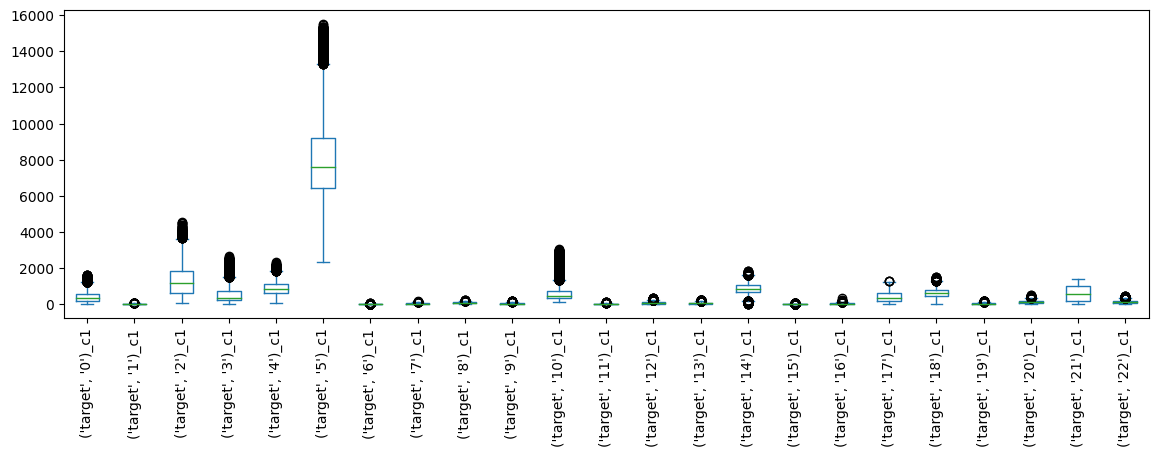

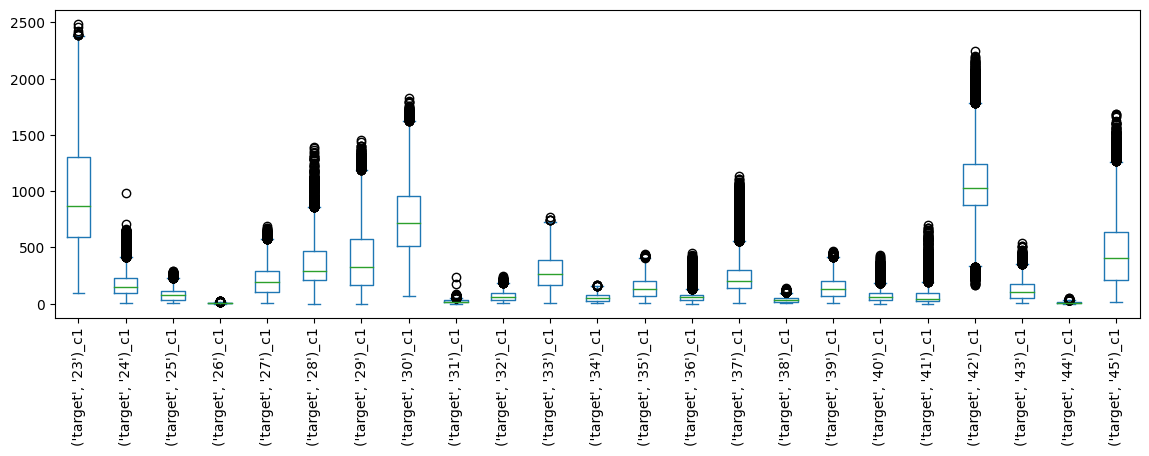

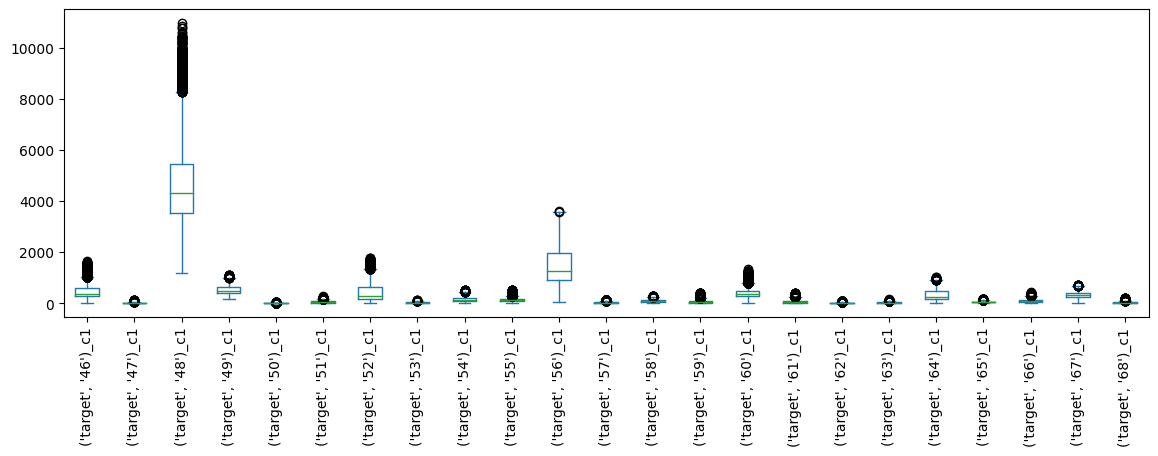

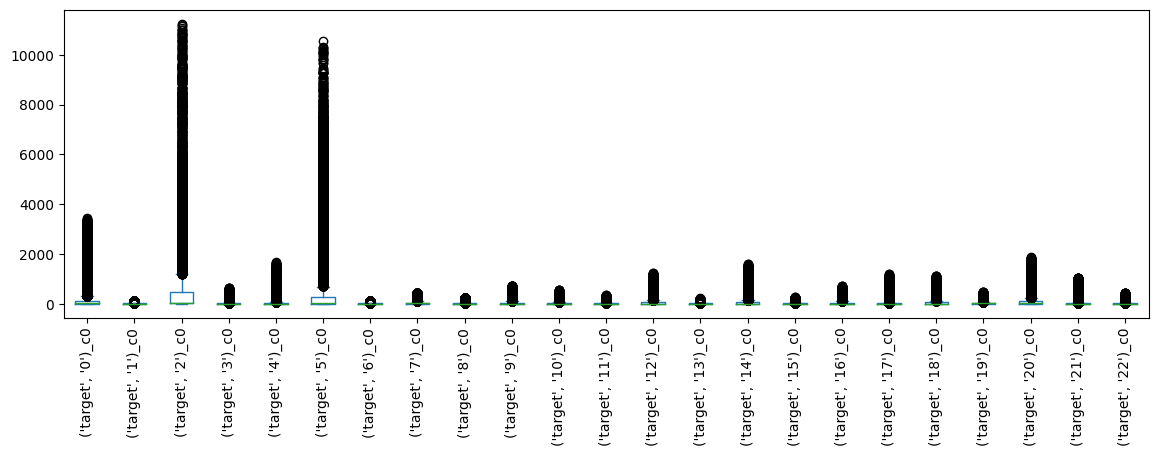

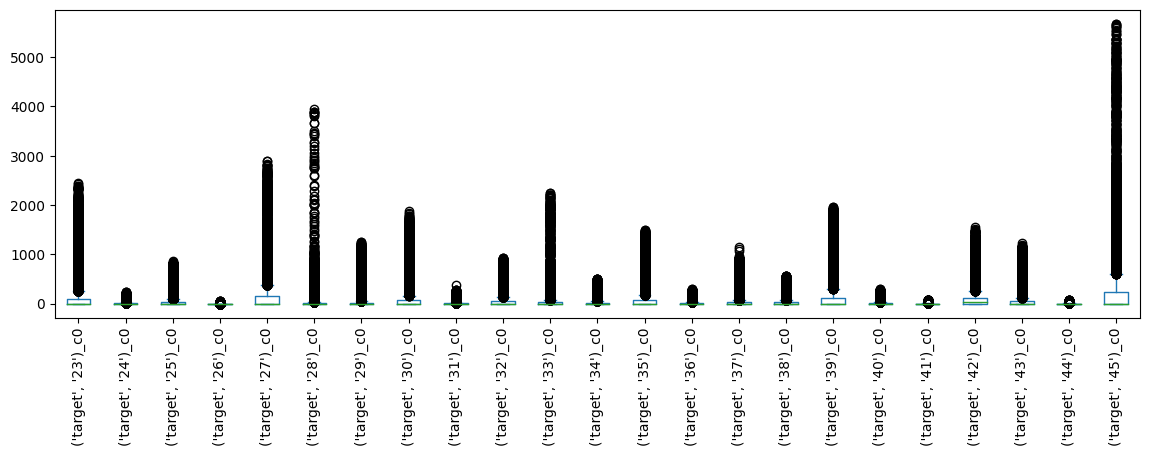

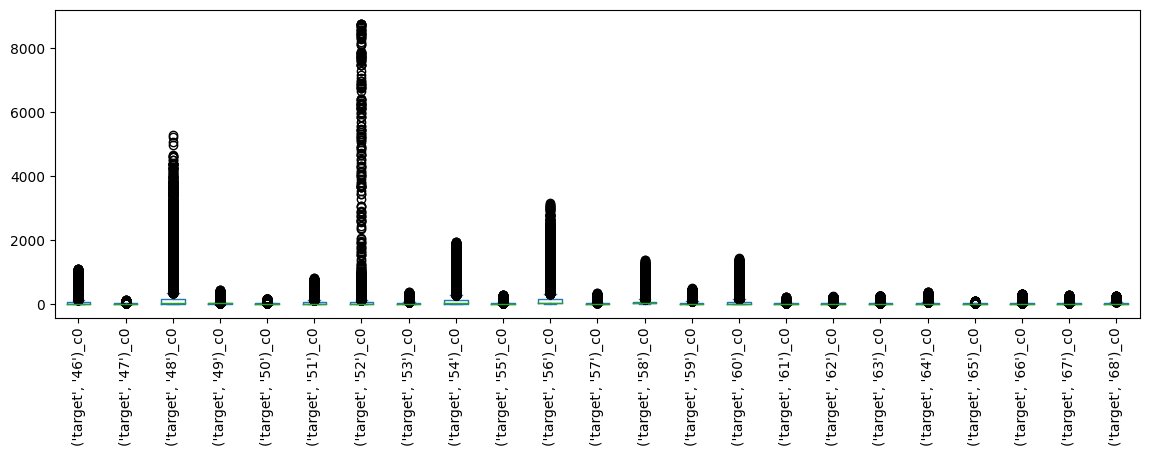

In [56]:
for i in range(0,139,23):
    if i !=0:
        df_pivoted[df_pivoted.columns[i-23:i]].plot(kind='box',figsize=(14,4),rot=90)

Data is very noisy and need some processing, but some out of box points in box plot might not be problematic within their relevant 24 hour window.

In [57]:
# z-score test to detect outliers in 24 hour windows
def zscore(df, window):
    r = df.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (df-m)/s
    return z

In [58]:
def treat_outliers(df):
    num_anomaly=0
    for column in df.columns[:138]:
        z_scores=zscore(df[column], 24)
        anomalities_index=z_scores[abs(z_scores)>3].index
        num_anomaly+=len(anomalities_index)
        df.loc[anomalities_index, column]=np.nan
        #print(df.isna().sum().sum())
    #print(f"{num_anomaly} treated")
    return df

In [59]:
df_pivoted=treat_outliers(df_pivoted)

In [60]:
# helper function to create time signals
def create_time_signals(df):
    date_time = df.index
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    hour=60*60
    half_day=12*hour
    day = 24*hour
    week= day*7
    year = (365.2425)*day

    df['Half_Day sin_past'] = np.sin(timestamp_s * (2 * np.pi / half_day))
    df['Half_Day cos_past'] = np.cos(timestamp_s * (2 * np.pi / half_day))
    df['Day sin_past'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos_past'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Week sin_past'] = np.sin(timestamp_s * (2 * np.pi / week))
    df['Week cos_past'] = np.cos(timestamp_s * (2 * np.pi / week))
    df['Year sin_past'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos_past'] = np.cos(timestamp_s * (2 * np.pi / year))

    date_time_f = df.index+pd.DateOffset(2)
    timestamp_s_f = date_time_f.map(pd.Timestamp.timestamp)
    df['Half_Day sin_future'] = np.sin(timestamp_s_f * (2 * np.pi / half_day))
    df['Half_Day cos_future'] = np.cos(timestamp_s_f * (2 * np.pi / half_day))
    df['Day sin_future'] = np.sin(timestamp_s_f * (2 * np.pi / day))
    df['Day cos_future'] = np.cos(timestamp_s_f * (2 * np.pi / day))
    df['Week sin_future'] = np.sin(timestamp_s_f * (2 * np.pi / week))
    df['Week cos_future'] = np.cos(timestamp_s_f * (2 * np.pi / week))
    df['Year sin_future'] = np.sin(timestamp_s_f* (2 * np.pi / year))
    df['Year cos_future'] = np.cos(timestamp_s_f * (2 * np.pi / year))
    return df

In [61]:
%%time
df_pivoted=create_time_signals(df_pivoted)

CPU times: user 316 ms, sys: 2.93 ms, total: 319 ms
Wall time: 318 ms


In [62]:
df_pivoted.head(2)

('target', '0')_c1  ('target', '1')_c1  \
2021-09-01 00:00:00           96.589996           17.313999   
2021-09-01 01:00:00           77.691002           15.872000   

                     ('target', '2')_c1  ('target', '3')_c1  \
2021-09-01 00:00:00          656.859009           59.000000   
2021-09-01 01:00:00          595.497986           61.599998   

                     ('target', '4')_c1  ('target', '5')_c1  \
2021-09-01 00:00:00          501.760010         5155.056152   
2021-09-01 01:00:00          486.296997         4953.257812   

                     ('target', '6')_c1  ('target', '7')_c1  \
2021-09-01 00:00:00               2.756           22.841000   
2021-09-01 01:00:00               2.808           21.158001   

                     ('target', '8')_c1  ('target', '9')_c1  \
2021-09-01 00:00:00              30.778           23.444000   
2021-09-01 01:00:00              30.468           25.306999   

                     ('target', '10')_c1  ('target', '11')_c1  \
2021-09-01 00:00:00           266.636993               14.964   
2021-09-01 01:00:00           237.904007               14.162   

                     ('target', '12')_c1  ('target', '13')_c1  \
2021-09-01 00:00:00            39.241001            55.483002   
2021-09-01 01:00:00            33.441002            57.567001   

                     ('target', '14')_c1  ('target', '15')_c1  \
2021-09-01 00:00:00           729.075012                4.895   
2021-09-01 01:00:00           728.718018                5.151   

                     ('target', '16')_c1  ('target', '17')_c1  \
2021-09-01 00:00:00            26.628000           247.822998   
2021-09-01 01:00:00            24.000999           234.481995   

                     ('target', '18')_c1  ('target', '19')_c1  \
2021-09-01 00:00:00           356.901001               18.490   
2021-09-01 01:00:00           333.045990               17.139   

                     ('target', '20')_c1  ('target', '21')_c1  \
2021-09-01 00:00:00            73.636002          1063.079956   
2021-09-01 01:00:00            72.319000          1095.609985   

                     ('target', '22')_c1  ('target', '23')_c1  \
2021-09-01 00:00:00            72.725998           475.984009   
2021-09-01 01:00:00            71.511002           452.660004   

                     ('target', '24')_c1  ('target', '25')_c1  \
2021-09-01 00:00:00           115.242996            19.058001   
2021-09-01 01:00:00           125.406998            19.495001   

                     ('target', '26')_c1  ('target', '27')_c1  \
2021-09-01 00:00:00                3.315           111.755997   
2021-09-01 01:00:00                2.550           102.002998   

                     ('target', '28')_c1  ('target', '29')_c1  \
2021-09-01 00:00:00           546.771973           161.843002   
2021-09-01 01:00:00           528.507019           163.735992   

                     ('target', '30')_c1  ('target', '31')_c1  \
2021-09-01 00:00:00           453.023010                9.787   
2021-09-01 01:00:00           449.571014                9.590   

                     ('target', '32')_c1  ('target', '33')_c1  \
2021-09-01 00:00:00               32.354           129.063004   
2021-09-01 01:00:00               27.757           124.754997   

                     ('target', '34')_c1  ('target', '35')_c1  \
2021-09-01 00:00:00               13.922            91.446999   
2021-09-01 01:00:00               14.657            76.361000   

                     ('target', '36')_c1  ('target', '37')_c1  \
2021-09-01 00:00:00            35.116001            48.724998   
2021-09-01 01:00:00            34.624001            48.779999   

                     ('target', '38')_c1  ('target', '39')_c1  \
2021-09-01 00:00:00                7.886            77.070999   
2021-09-01 01:00:00                7.408            62.138000   

                     ('target', '40')_c1  ('target', '41')_c1  \
2021-09-01 00:00:00            43.957001            55.013000   
2

In [63]:
import holidays
estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
estonian_holidays = list(estonian_holidays.keys())

In [64]:
def add_holiday(df):
    df["holidays_past"]=np.where(df.index.floor('D').isin(estonian_holidays),1,0)
    df["holidays_future"]=np.where((df.index.floor('D')+pd.DateOffset(2)).isin(estonian_holidays),1,0)
    return df

In [65]:
df_pivoted=add_holiday(df_pivoted)
df_pivoted[["holidays_past","holidays_future"]].value_counts()

holidays_past  holidays_future
0              0                  14400
               1                    408
1              0                    408
               1                     96
Name: count, dtype: int64

In [66]:
display(f"df_pivoted shape: {df_pivoted.shape}",
        df_pivoted.head(2),df_pivoted.tail(2))

'df_pivoted shape: (15312, 687)'

('target', '0')_c1  ('target', '1')_c1  \
2021-09-01 00:00:00           96.589996           17.313999   
2021-09-01 01:00:00           77.691002           15.872000   

                     ('target', '2')_c1  ('target', '3')_c1  \
2021-09-01 00:00:00          656.859009           59.000000   
2021-09-01 01:00:00          595.497986           61.599998   

                     ('target', '4')_c1  ('target', '5')_c1  \
2021-09-01 00:00:00          501.760010         5155.056152   
2021-09-01 01:00:00          486.296997         4953.257812   

                     ('target', '6')_c1  ('target', '7')_c1  \
2021-09-01 00:00:00               2.756           22.841000   
2021-09-01 01:00:00               2.808           21.158001   

                     ('target', '8')_c1  ('target', '9')_c1  \
2021-09-01 00:00:00              30.778           23.444000   
2021-09-01 01:00:00              30.468           25.306999   

                     ('target', '10')_c1  ('target', '11')_c1  \
2021-09-01 00:00:00           266.636993               14.964   
2021-09-01 01:00:00           237.904007               14.162   

                     ('target', '12')_c1  ('target', '13')_c1  \
2021-09-01 00:00:00            39.241001            55.483002   
2021-09-01 01:00:00            33.441002            57.567001   

                     ('target', '14')_c1  ('target', '15')_c1  \
2021-09-01 00:00:00           729.075012                4.895   
2021-09-01 01:00:00           728.718018                5.151   

                     ('target', '16')_c1  ('target', '17')_c1  \
2021-09-01 00:00:00            26.628000           247.822998   
2021-09-01 01:00:00            24.000999           234.481995   

                     ('target', '18')_c1  ('target', '19')_c1  \
2021-09-01 00:00:00           356.901001               18.490   
2021-09-01 01:00:00           333.045990               17.139   

                     ('target', '20')_c1  ('target', '21')_c1  \
2021-09-01 00:00:00            73.636002          1063.079956   
2021-09-01 01:00:00            72.319000          1095.609985   

                     ('target', '22')_c1  ('target', '23')_c1  \
2021-09-01 00:00:00            72.725998           475.984009   
2021-09-01 01:00:00            71.511002           452.660004   

                     ('target', '24')_c1  ('target', '25')_c1  \
2021-09-01 00:00:00           115.242996            19.058001   
2021-09-01 01:00:00           125.406998            19.495001   

                     ('target', '26')_c1  ('target', '27')_c1  \
2021-09-01 00:00:00                3.315           111.755997   
2021-09-01 01:00:00                2.550           102.002998   

                     ('target', '28')_c1  ('target', '29')_c1  \
2021-09-01 00:00:00           546.771973           161.843002   
2021-09-01 01:00:00           528.507019           163.735992   

                     ('target', '30')_c1  ('target', '31')_c1  \
2021-09-01 00:00:00           453.023010                9.787   
2021-09-01 01:00:00           449.571014                9.590   

                     ('target', '32')_c1  ('target', '33')_c1  \
2021-09-01 00:00:00               32.354           129.063004   
2021-09-01 01:00:00               27.757           124.754997   

                     ('target', '34')_c1  ('target', '35')_c1  \
2021-09-01 00:00:00               13.922            91.446999   
2021-09-01 01:00:00               14.657            76.361000   

                     ('target', '36')_c1  ('target', '37')_c1  \
2021-09-01 00:00:00            35.116001            48.724998   
2021-09-01 01:00:00            34.624001            48.779999   

                     ('target', '38')_c1  ('target', '39')_c1  \
2021-09-01 00:00:00                7.886            77.070999   
2021-09-01 01:00:00                7.408            62.138000   

                     ('target', '40')_c1  ('target', '41')_c1  \
2021-09-01 00:00:00            43.957001            55.013000   
2

('target', '0')_c1  ('target', '1')_c1  \
2023-05-31 22:00:00          577.499023               4.329   
2023-05-31 23:00:00          544.221008               3.459   

                     ('target', '2')_c1  ('target', '3')_c1  \
2023-05-31 22:00:00         1485.767944          516.906006   
2023-05-31 23:00:00         1349.457031          540.327026   

                     ('target', '4')_c1  ('target', '5')_c1  \
2023-05-31 22:00:00          870.630005         8580.002930   
2023-05-31 23:00:00          889.250977         7785.861816   

                     ('target', '6')_c1  ('target', '7')_c1  \
2023-05-31 22:00:00              14.574           44.007000   
2023-05-31 23:00:00              11.081           39.460999   

                     ('target', '8')_c1  ('target', '9')_c1  \
2023-05-31 22:00:00           79.806000           71.806000   
2023-05-31 23:00:00           79.070999           60.959999   

                     ('target', '10')_c1  ('target', '11')_c1  \
2023-05-31 22:00:00           414.075012            30.947001   
2023-05-31 23:00:00           386.677002            30.476999   

                     ('target', '12')_c1  ('target', '13')_c1  \
2023-05-31 22:00:00           118.839996            23.688000   
2023-05-31 23:00:00           100.874001            25.221001   

                     ('target', '14')_c1  ('target', '15')_c1  \
2023-05-31 22:00:00           769.018982            23.028000   
2023-05-31 23:00:00           702.729004            21.084999   

                     ('target', '16')_c1  ('target', '17')_c1  \
2023-05-31 22:00:00            47.877998            621.91803   
2023-05-31 23:00:00            40.915001            775.85199   

                     ('target', '18')_c1  ('target', '19')_c1  \
2023-05-31 22:00:00           664.291016            61.575001   
2023-05-31 23:00:00           637.182007            59.707001   

                     ('target', '20')_c1  ('target', '21')_c1  \
2023-05-31 22:00:00           184.347000           164.667007   
2023-05-31 23:00:00           162.425003           156.832993   

                     ('target', '22')_c1  ('target', '23')_c1  \
2023-05-31 22:00:00           113.255997          1294.426025   
2023-05-31 23:00:00           113.323997          1307.526978   

                     ('target', '24')_c1  ('target', '25')_c1  \
2023-05-31 22:00:00           114.667000            95.825996   
2023-05-31 23:00:00            84.841003            84.041000   

                     ('target', '26')_c1  ('target', '27')_c1  \
2023-05-31 22:00:00                  NaN           265.006989   
2023-05-31 23:00:00                  NaN           250.151993   

                     ('target', '28')_c1  ('target', '29')_c1  \
2023-05-31 22:00:00           369.221985           703.164001   
2023-05-31 23:00:00           361.621002           542.796021   

                     ('target', '30')_c1  ('target', '31')_c1  \
2023-05-31 22:00:00           751.926025               23.362   
2023-05-31 23:00:00           683.260010               21.983   

                     ('target', '32')_c1  ('target', '33')_c1  \
2023-05-31 22:00:00            83.942001           491.210999   
2023-05-31 23:00:00            66.760002           471.770996   

                     ('target', '34')_c1  ('target', '35')_c1  \
2023-05-31 22:00:00            59.935001           186.707993   
2023-05-31 23:00:00            47.609001           151.746994   

                     ('target', '36')_c1  ('target', '37')_c1  \
2023-05-31 22:00:00            38.400002           206.882004   
2023-05-31 23:00:00            34.376999           189.600998   

                     ('target', '38')_c1  ('target', '39')_c1  \
2023-05-31 22:00:00            71.922997           169.845001   
2023-05-31 23:00:00            58.411999           143.039001   

                     ('target', '40')_c1  ('target', '41')_c1  \
2023-05-31 22:00:00           102.330002                  NaN   
2

# Preparing Dataset for Multistep forecasting with DNN

#### Finding Indiches to allocate to different parts of model based on county

In [67]:
def county_predid_map(df):
    base_map=df.groupby(["county"])['prediction_unit_id'].unique().apply(list).to_dict()
    int_map={}
    for key, value in base_map.items():
        int_map_key=int(key)
        int_map_value=[int(x) for x in value]
        int_map[int_map_key]=int_map_value
    int_dict=dict(sorted(int_map.items()))
    # since weather info for county 12 doesn't exist and only predid in it is 49 and only predid in county 6 is 24;
    # I will map predid 49 to county 6 and drop county 12 from the map
    int_dict[6]=int_dict[6]+int_dict[12]
    del int_dict[12]
    return int_dict

In [68]:
train_county_predid_map=county_predid_map(train)

|col_name|indiches|
|-|-|
|target_c1|0:69|
|target_c2|69:138|
|eic_count|138:207|
|installed_capacity|207:276|
|historic_weather|276:486|
|forecast_weather|486:666|
|elec_gas|666,667,668|
|ts_past|669:677|
|ts_future|677:685|
|holiday_past|686|
|holiday_future|687|

In [69]:
def select_f_indiches_by_county(map):
    indiches_map={}
    for key, val in map.items():
        #select target_c1
        target_c1s=val
        #select target_c2
        target_c2s=[69+x for x in val]
        #select eic_count
        eic_counts=[138+x for x in val]
        #select installed_capacity
        installed_capacity=[207+x for x in val]
        # weather feat beginnings per county
        if key<12:
            county_hw_range_begin=276+14*key
            county_fw_range_begin=486+12*key
        else:
            county_hw_range_begin=276+14*(key-1)
            county_fw_range_begin=486+12*(key-1)
        #select historic weather
        historic_weather=[county_hw_range_begin+x for x in range(14)]
        #select feature weather
        feature_weather=[county_fw_range_begin+x for x in range(12)]
        #select common features
        elec_gas=[666,667,668] #will be removed(forecast not available in test)
        ts_past=[x for x in range(669,677)]
        ts_future=[x for x in range(677,685)]
        holiday_past=[685]
        holiday_future=[686]
        past=target_c1s+target_c2s+eic_counts+installed_capacity+\
        historic_weather+elec_gas+ts_past+holiday_past+\
        feature_weather+ts_future+holiday_future
        indiches_map[key]=past
    return indiches_map

In [70]:
# sanity check for found indiches
county_indiches_map=select_f_indiches_by_county(train_county_predid_map)
for key in county_indiches_map:
    print(f"county: {key}, {df_pivoted.iloc[:,county_indiches_map[key]].shape}")
    display(df_pivoted.iloc[:,county_indiches_map[key]].head(1))

county: 0, (15312, 75)


('target', '0')_c1  ('target', '1')_c1  ('target', '2')_c1  \
2021-09-01           96.589996           17.313999          656.859009   

            ('target', '3')_c1  ('target', '4')_c1  ('target', '5')_c1  \
2021-09-01                59.0           501.76001         5155.056152   

            ('target', '61')_c1  ('target', '0')_c0  ('target', '1')_c0  \
2021-09-01                  NaN               0.713                 0.0   

            ('target', '2')_c0  ('target', '3')_c0  ('target', '4')_c0  \
2021-09-01               2.904                 0.0                 0.0   

            ('target', '5')_c0  ('target', '61')_c0  ('eic_count', '0')  \
2021-09-01               0.315                  NaN                 0.0   

            ('eic_count', '1')  ('eic_count', '2')  ('eic_count', '3')  \
2021-09-01                 0.0                 0.0                 0.0   

            ('eic_count', '4')  ('eic_count', '5')  ('eic_count', '61')  \
2021-09-01                 0.0                 0.0                  NaN   

            ('installed_capacity', '0')  ('installed_capacity', '1')  \
2021-09-01                          0.0                          0.0   

            ('installed_capacity', '2')  ('installed_capacity', '3')  \
2021-09-01                          0.0                          0.0   

            ('installed_capacity', '4')  ('installed_capacity', '5')  \
2021-09-01                          0.0                          0.0   

            ('installed_capacity', '61')  \
2021-09-01                           NaN   

            ('10_metre_u_wind_component_historical', 0.0)  \
2021-09-01                                       6.365506   

            ('10_metre_v_wind_component_historical', 0.0)  \
2021-09-01                                      -1.723581   

            ('cloudcover_high', 0.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 0.0)_historic  \
2021-09-01                          26.09091   

            ('cloudcover_mid', 0.0)_historic  \
2021-09-01                          40.81818   

            ('cloudcover_total', 0.0)_historic  ('dewpoint', 0.0)_historic  \
2021-09-01                           48.090908                    5.890909   

            ('diffuse_radiation', 0.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 0.0)_historic  ('rain', 0.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 0.0)  ('snowfall', 0.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 0.0)  ('temperature', 0.0)_historic  \
2021-09-01                1010.836365                      10.845455   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 0.0)  \
2021-09-01              0                            8.840501   

            ('10_metre_v_wind_component', 0.0)  \
2021-09-01                           -3.040309   

            ('cloudcover_high', 0.0)_forecast  \
2021-09-01                           0.316682   

            ('cloudcover_low', 0.0)_forecast  \
2021-09-01                          0.230402   

            ('cloudcover_mid', 0.0)_forecast  \
2021-09-01                          0.734637   

            ('cloudcover_total', 0.0)_forecast  ('dewpoint', 0.0)_forecast  \
2021-09-01                             0.81329                   10.182742   

            ('diffuse_radiation', 0.0)_forecast 

county: 1, (15312, 59)


('target', '6')_c1  ('target', '7')_c1  ('target', '8')_c1  \
2021-09-01               2.756              22.841              30.778   

            ('target', '6')_c0  ('target', '7')_c0  ('target', '8')_c0  \
2021-09-01                 0.0               0.087                 0.0   

            ('eic_count', '6')  ('eic_count', '7')  ('eic_count', '8')  \
2021-09-01                 0.0                 0.0                 0.0   

            ('installed_capacity', '6')  ('installed_capacity', '7')  \
2021-09-01                          0.0                          0.0   

            ('installed_capacity', '8')  \
2021-09-01                          0.0   

            ('10_metre_u_wind_component_historical', 1.0)  \
2021-09-01                                       8.247874   

            ('10_metre_v_wind_component_historical', 1.0)  \
2021-09-01                                      -0.950912   

            ('cloudcover_high', 1.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 1.0)_historic  \
2021-09-01                          6.285714   

            ('cloudcover_mid', 1.0)_historic  \
2021-09-01                         27.285715   

            ('cloudcover_total', 1.0)_historic  ('dewpoint', 1.0)_historic  \
2021-09-01                                22.0                    5.842857   

            ('diffuse_radiation', 1.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 1.0)_historic  ('rain', 1.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 1.0)  ('snowfall', 1.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 1.0)  ('temperature', 1.0)_historic  \
2021-09-01                1015.899963                      11.971429   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 1.0)  \
2021-09-01              0                            9.268608   

            ('10_metre_v_wind_component', 1.0)  \
2021-09-01                           -4.651547   

            ('cloudcover_high', 1.0)_forecast  \
2021-09-01                                0.0   

            ('cloudcover_low', 1.0)_forecast  \
2021-09-01                          0.076026   

            ('cloudcover_mid', 1.0)_forecast  \
2021-09-01                          0.227774   

            ('cloudcover_total', 1.0)_forecast  ('dewpoint', 1.0)_forecast  \
2021-09-01                            0.246273                    10.88901   

            ('diffuse_radiation', 1.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 1.0)_forecast  ('rain', 1.0)_forecast  \
2021-09-01                                       0.0                0.000026   

            ('snowfall', 1.0)_forecast  ('temperature', 1.0)_forecast  \
2021-09-01                         0.0                      15.633064   

            Half_Day sin_future  Half_Day cos_future  Day sin_future  \
2021-09-01        -1.215971e-12                  1.0   -6.079854e-13   

            Day cos_future  Week sin_future  Week cos_future  Year sin_future  \
2021-09-01             1.0         0.781831          0.62349        -0.883821   

            Year cos_future  holidays_future  
2021-09-01        -0.467825                0

county: 2, (15312, 63)


('target', '9')_c1  ('target', '10')_c1  ('target', '62')_c1  \
2021-09-01              23.444           266.636993                  NaN   

            ('target', '65')_c1  ('target', '9')_c0  ('target', '10')_c0  \
2021-09-01                  NaN                 0.0                  0.0   

            ('target', '62')_c0  ('target', '65')_c0  ('eic_count', '9')  \
2021-09-01                  NaN                  NaN                 0.0   

            ('eic_count', '10')  ('eic_count', '62')  ('eic_count', '65')  \
2021-09-01                  0.0                  NaN                  NaN   

            ('installed_capacity', '9')  ('installed_capacity', '10')  \
2021-09-01                          0.0                           0.0   

            ('installed_capacity', '62')  ('installed_capacity', '65')  \
2021-09-01                           NaN                           NaN   

            ('10_metre_u_wind_component_historical', 2.0)  \
2021-09-01                                        5.65499   

            ('10_metre_v_wind_component_historical', 2.0)  \
2021-09-01                                      -1.941065   

            ('cloudcover_high', 2.0)_historic  \
2021-09-01                          19.083334   

            ('cloudcover_low', 2.0)_historic  \
2021-09-01                         18.666666   

            ('cloudcover_mid', 2.0)_historic  \
2021-09-01                              48.0   

            ('cloudcover_total', 2.0)_historic  ('dewpoint', 2.0)_historic  \
2021-09-01                           51.416668                         7.0   

            ('diffuse_radiation', 2.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 2.0)_historic  ('rain', 2.0)_historic  \
2021-09-01                                       0.0                 0.00005   

            ('shortwave_radiation', 2.0)  ('snowfall', 2.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 2.0)  ('temperature', 2.0)_historic  \
2021-09-01                1005.741699                      10.166667   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 2.0)  \
2021-09-01              0                            6.931208   

            ('10_metre_v_wind_component', 2.0)  \
2021-09-01                           -0.261415   

            ('cloudcover_high', 2.0)_forecast  \
2021-09-01                           0.792528   

            ('cloudcover_low', 2.0)_forecast  \
2021-09-01                          0.654855   

            ('cloudcover_mid', 2.0)_forecast  \
2021-09-01                          0.962415   

            ('cloudcover_total', 2.0)_forecast  ('dewpoint', 2.0)_forecast  \
2021-09-01                            0.992627                   10.081222   

            ('diffuse_radiation', 2.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 2.0)_forecast  ('rain', 2.0)_forecast  \
2021-09-01                                       0.0                0.001068   

            ('snowfall', 2.0)_forecast  ('temperature', 2.0)_forecast  \
2021-09-01                         0.0                      11.302505   

            Half_Day sin_future  Half_Day cos_future  Day sin_future  \
2021-09-01        -1.215971e-12                  1.0   -6.079854e-13   

            Day cos_future  Week sin_future  Week cos_future  Year sin_future  \
2021-09-01             1.0         0.781831          0.62349        -0.883

county: 3, (15312, 63)


('target', '11')_c1  ('target', '12')_c1  ('target', '13')_c1  \
2021-09-01               14.964            39.241001            55.483002   

            ('target', '14')_c1  ('target', '11')_c0  ('target', '12')_c0  \
2021-09-01           729.075012                  0.0                0.001   

            ('target', '13')_c0  ('target', '14')_c0  ('eic_count', '11')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '12')  ('eic_count', '13')  ('eic_count', '14')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '11')  ('installed_capacity', '12')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '13')  ('installed_capacity', '14')  \
2021-09-01                           0.0                           0.0   

            ('10_metre_u_wind_component_historical', 3.0)  \
2021-09-01                                       3.896324   

            ('10_metre_v_wind_component_historical', 3.0)  \
2021-09-01                                      -1.473683   

            ('cloudcover_high', 3.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 3.0)_historic  \
2021-09-01                         12.666667   

            ('cloudcover_mid', 3.0)_historic  \
2021-09-01                         37.333332   

            ('cloudcover_total', 3.0)_historic  ('dewpoint', 3.0)_historic  \
2021-09-01                           33.666668                    5.633333   

            ('diffuse_radiation', 3.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 3.0)_historic  ('rain', 3.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 3.0)  ('snowfall', 3.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 3.0)  ('temperature', 3.0)_historic  \
2021-09-01                     1003.5                       9.533333   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 3.0)  \
2021-09-01              0                            6.404658   

            ('10_metre_v_wind_component', 3.0)  \
2021-09-01                           -1.061738   

            ('cloudcover_high', 3.0)_forecast  \
2021-09-01                            0.13913   

            ('cloudcover_low', 3.0)_forecast  \
2021-09-01                          0.363408   

            ('cloudcover_mid', 3.0)_forecast  \
2021-09-01                           0.83216   

            ('cloudcover_total', 3.0)_forecast  ('dewpoint', 3.0)_forecast  \
2021-09-01                            0.893629                    9.917485   

            ('diffuse_radiation', 3.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 3.0)_forecast  ('rain', 3.0)_forecast  \
2021-09-01                                       0.0                 0.00024   

            ('snowfall', 3.0)_forecast  ('temperature', 3.0)_forecast  \
2021-09-01                         0.0                      11.492172   

            Half_Day sin_future  Half_Day cos_future  Day sin_future  \
2021-09-01        -1.215971e-12                  1.0   -6.079854e-13   

            Day cos_future  Week sin_future  Week cos_future  Year sin_future  \
2021-09-01             1.0         0.781831          0.62349      

county: 4, (15312, 67)


('target', '15')_c1  ('target', '16')_c1  ('target', '17')_c1  \
2021-09-01                4.895               26.628           247.822998   

            ('target', '18')_c1  ('target', '66')_c1  ('target', '15')_c0  \
2021-09-01           356.901001                  NaN                  0.0   

            ('target', '16')_c0  ('target', '17')_c0  ('target', '18')_c0  \
2021-09-01                  0.0                  0.0                  0.0   

            ('target', '66')_c0  ('eic_count', '15')  ('eic_count', '16')  \
2021-09-01                  NaN                  0.0                  0.0   

            ('eic_count', '17')  ('eic_count', '18')  ('eic_count', '66')  \
2021-09-01                  0.0                  0.0                  NaN   

            ('installed_capacity', '15')  ('installed_capacity', '16')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '17')  ('installed_capacity', '18')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '66')  \
2021-09-01                           NaN   

            ('10_metre_u_wind_component_historical', 4.0)  \
2021-09-01                                       4.428422   

            ('10_metre_v_wind_component_historical', 4.0)  \
2021-09-01                                       -2.25984   

            ('cloudcover_high', 4.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 4.0)_historic  \
2021-09-01                              13.0   

            ('cloudcover_mid', 4.0)_historic  \
2021-09-01                         21.333334   

            ('cloudcover_total', 4.0)_historic  ('dewpoint', 4.0)_historic  \
2021-09-01                           24.333334                         5.9   

            ('diffuse_radiation', 4.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 4.0)_historic  ('rain', 4.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 4.0)  ('snowfall', 4.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 4.0)  ('temperature', 4.0)_historic  \
2021-09-01                1002.966614                       9.433333   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 4.0)  \
2021-09-01              0                            6.626215   

            ('10_metre_v_wind_component', 4.0)  \
2021-09-01                           -0.565848   

            ('cloudcover_high', 4.0)_forecast  \
2021-09-01                           0.358714   

            ('cloudcover_low', 4.0)_forecast  \
2021-09-01                          0.619995   

            ('cloudcover_mid', 4.0)_forecast  \
2021-09-01                          0.800643   

            ('cloudcover_total', 4.0)_forecast  ('dewpoint', 4.0)_forecast  \
2021-09-01                            0.948996                    9.567225   

            ('diffuse_radiation', 4.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 4.0)_forecast  ('rain', 4.0)_forecast  \
2021-09-01                                       0.0                0.000191   

            ('snowfall', 4.0)_forecast  ('temperature', 4.0)_forecast  \
2021-09-01                         0.0                      11.405136   

            Half_Day sin_future  Half_Day cos_fu

county: 5, (15312, 67)


('target', '19')_c1  ('target', '20')_c1  ('target', '21')_c1  \
2021-09-01                18.49            73.636002          1063.079956   

            ('target', '22')_c1  ('target', '23')_c1  ('target', '19')_c0  \
2021-09-01            72.725998           475.984009                  0.0   

            ('target', '20')_c0  ('target', '21')_c0  ('target', '22')_c0  \
2021-09-01                0.025                  0.0                  0.0   

            ('target', '23')_c0  ('eic_count', '19')  ('eic_count', '20')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '21')  ('eic_count', '22')  ('eic_count', '23')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '19')  ('installed_capacity', '20')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '21')  ('installed_capacity', '22')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '23')  \
2021-09-01                           0.0   

            ('10_metre_u_wind_component_historical', 5.0)  \
2021-09-01                                       6.035656   

            ('10_metre_v_wind_component_historical', 5.0)  \
2021-09-01                                      -1.994154   

            ('cloudcover_high', 5.0)_historic  \
2021-09-01                           0.333333   

            ('cloudcover_low', 5.0)_historic  \
2021-09-01                         27.666666   

            ('cloudcover_mid', 5.0)_historic  \
2021-09-01                              43.5   

            ('cloudcover_total', 5.0)_historic  ('dewpoint', 5.0)_historic  \
2021-09-01                           51.166668                    6.516666   

            ('diffuse_radiation', 5.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 5.0)_historic  ('rain', 5.0)_historic  \
2021-09-01                                       0.0                0.000117   

            ('shortwave_radiation', 5.0)  ('snowfall', 5.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 5.0)  ('temperature', 5.0)_historic  \
2021-09-01                1004.466614                       9.666667   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 5.0)  \
2021-09-01              0                            8.233597   

            ('10_metre_v_wind_component', 5.0)  \
2021-09-01                           -2.525727   

            ('cloudcover_high', 5.0)_forecast  \
2021-09-01                           0.786437   

            ('cloudcover_low', 5.0)_forecast  \
2021-09-01                          0.433062   

            ('cloudcover_mid', 5.0)_forecast  \
2021-09-01                          0.863482   

            ('cloudcover_total', 5.0)_forecast  ('dewpoint', 5.0)_forecast  \
2021-09-01                            0.965513                   10.308649   

            ('diffuse_radiation', 5.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 5.0)_forecast  ('rain', 5.0)_forecast  \
2021-09-01                                       0.0                 0.00051   

            ('snowfall', 5.0)_forecast  ('temperature', 5.0)_forecast  \
2021-09-01                         0.0                      11.955104   

            Half_Day sin_future  Half_Day cos_fu

county: 6, (15312, 55)


('target', '24')_c1  ('target', '49')_c1  ('target', '24')_c0  \
2021-09-01           115.242996           515.031982                  0.0   

            ('target', '49')_c0  ('eic_count', '24')  ('eic_count', '49')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '24')  ('installed_capacity', '49')  \
2021-09-01                           0.0                           0.0   

            ('10_metre_u_wind_component_historical', 6.0)  \
2021-09-01                                       8.274269   

            ('10_metre_v_wind_component_historical', 6.0)  \
2021-09-01                                      -0.977352   

            ('cloudcover_high', 6.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 6.0)_historic  \
2021-09-01                          5.833333   

            ('cloudcover_mid', 6.0)_historic  \
2021-09-01                         35.333332   

            ('cloudcover_total', 6.0)_historic  ('dewpoint', 6.0)_historic  \
2021-09-01                           26.666666                    5.333333   

            ('diffuse_radiation', 6.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 6.0)_historic  ('rain', 6.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 6.0)  ('snowfall', 6.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 6.0)  ('temperature', 6.0)_historic  \
2021-09-01                1014.399963                      12.099999   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 6.0)  \
2021-09-01              0                            8.950679   

            ('10_metre_v_wind_component', 6.0)  \
2021-09-01                           -4.279878   

            ('cloudcover_high', 6.0)_forecast  \
2021-09-01                                0.0   

            ('cloudcover_low', 6.0)_forecast  \
2021-09-01                          0.129066   

            ('cloudcover_mid', 6.0)_forecast  \
2021-09-01                          0.432199   

            ('cloudcover_total', 6.0)_forecast  ('dewpoint', 6.0)_forecast  \
2021-09-01                            0.450372                   10.737941   

            ('diffuse_radiation', 6.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 6.0)_forecast  ('rain', 6.0)_forecast  \
2021-09-01                                       0.0                0.000098   

            ('snowfall', 6.0)_forecast  ('temperature', 6.0)_forecast  \
2021-09-01                         0.0                      15.069097   

            Half_Day sin_future  Half_Day cos_future  Day sin_future  \
2021-09-01        -1.215971e-12                  1.0   -6.079854e-13   

            Day cos_future  Week sin_future  Week cos_future  Year sin_future  \
2021-09-01             1.0         0.781831          0.62349        -0.883821   

            Year cos_future  holidays_future  
2021-09-01        -0.467825                0

county: 7, (15312, 71)


('target', '25')_c1  ('target', '26')_c1  ('target', '27')_c1  \
2021-09-01            19.058001                3.315           111.755997   

            ('target', '28')_c1  ('target', '29')_c1  ('target', '30')_c1  \
2021-09-01           546.771973           161.843002            453.02301   

            ('target', '25')_c0  ('target', '26')_c0  ('target', '27')_c0  \
2021-09-01                  0.0                  0.0                0.028   

            ('target', '28')_c0  ('target', '29')_c0  ('target', '30')_c0  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '25')  ('eic_count', '26')  ('eic_count', '27')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '28')  ('eic_count', '29')  ('eic_count', '30')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '25')  ('installed_capacity', '26')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '27')  ('installed_capacity', '28')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '29')  ('installed_capacity', '30')  \
2021-09-01                           0.0                           0.0   

            ('10_metre_u_wind_component_historical', 7.0)  \
2021-09-01                                       5.489633   

            ('10_metre_v_wind_component_historical', 7.0)  \
2021-09-01                                      -1.627026   

            ('cloudcover_high', 7.0)_historic  \
2021-09-01                           0.466667   

            ('cloudcover_low', 7.0)_historic  \
2021-09-01                         13.933333   

            ('cloudcover_mid', 7.0)_historic  \
2021-09-01                         36.533333   

            ('cloudcover_total', 7.0)_historic  ('dewpoint', 7.0)_historic  \
2021-09-01                           34.599998                        5.36   

            ('diffuse_radiation', 7.0)_historic  \
2021-09-01                                  5.0   

            ('direct_solar_radiation', 7.0)_historic  ('rain', 7.0)_historic  \
2021-09-01                                      19.4                     0.0   

            ('shortwave_radiation', 7.0)  ('snowfall', 7.0)_historic  \
2021-09-01                          24.4                         0.0   

            ('surface_pressure', 7.0)  ('temperature', 7.0)_historic  \
2021-09-01                1011.453308                      10.940001   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 7.0)  \
2021-09-01              0                            7.456685   

            ('10_metre_v_wind_component', 7.0)  \
2021-09-01                           -0.203527   

            ('cloudcover_high', 7.0)_forecast  \
2021-09-01                           0.080181   

            ('cloudcover_low', 7.0)_forecast  \
2021-09-01                           0.12725   

            ('cloudcover_mid', 7.0)_forecast  \
2021-09-01                          0.478425   

            ('cloudcover_total', 7.0)_forecast  ('dewpoint', 7.0)_forecast  \
2021-09-01                            0.564211                   11.673539   

            ('diffuse_radiation', 7.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 7.0)_forecast  ('rain', 7.0)_forecast  \
2021-09-01                                       0.0         

county: 8, (15312, 59)


('target', '31')_c1  ('target', '32')_c1  ('target', '33')_c1  \
2021-09-01                9.787               32.354           129.063004   

            ('target', '31')_c0  ('target', '32')_c0  ('target', '33')_c0  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '31')  ('eic_count', '32')  ('eic_count', '33')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '31')  ('installed_capacity', '32')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '33')  \
2021-09-01                           0.0   

            ('10_metre_u_wind_component_historical', 8.0)  \
2021-09-01                                       4.499366   

            ('10_metre_v_wind_component_historical', 8.0)  \
2021-09-01                                      -2.811516   

            ('cloudcover_high', 8.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 8.0)_historic  \
2021-09-01                              14.0   

            ('cloudcover_mid', 8.0)_historic  \
2021-09-01                              33.0   

            ('cloudcover_total', 8.0)_historic  ('dewpoint', 8.0)_historic  \
2021-09-01                                32.0                         6.5   

            ('diffuse_radiation', 8.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 8.0)_historic  ('rain', 8.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 8.0)  ('snowfall', 8.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 8.0)  ('temperature', 8.0)_historic  \
2021-09-01                1006.700012                           10.1   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 8.0)  \
2021-09-01              0                            6.047399   

            ('10_metre_v_wind_component', 8.0)  \
2021-09-01                            0.261382   

            ('cloudcover_high', 8.0)_forecast  \
2021-09-01                           0.320694   

            ('cloudcover_low', 8.0)_forecast  \
2021-09-01                          0.433548   

            ('cloudcover_mid', 8.0)_forecast  \
2021-09-01                          0.818058   

            ('cloudcover_total', 8.0)_forecast  ('dewpoint', 8.0)_forecast  \
2021-09-01                            0.923519                    8.578638   

            ('diffuse_radiation', 8.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 8.0)_forecast  ('rain', 8.0)_forecast  \
2021-09-01                                       0.0                0.000031   

            ('snowfall', 8.0)_forecast  ('temperature', 8.0)_forecast  \
2021-09-01                         0.0                      11.450098   

            Half_Day sin_future  Half_Day cos_future  Day sin_future  \
2021-09-01        -1.215971e-12                  1.0   -6.079854e-13   

            Day cos_future  Week sin_future  Week cos_future  Year sin_future  \
2021-09-01             1.0         0.781831          0.62349        -0.883821   

            Year cos_future  holidays_future  
2021-09-01        -0.467825                0

county: 9, (15312, 63)


('target', '34')_c1  ('target', '35')_c1  ('target', '36')_c1  \
2021-09-01               13.922            91.446999            35.116001   

            ('target', '37')_c1  ('target', '34')_c0  ('target', '35')_c0  \
2021-09-01            48.724998                  0.0                0.089   

            ('target', '36')_c0  ('target', '37')_c0  ('eic_count', '34')  \
2021-09-01                  0.0                 0.02                  0.0   

            ('eic_count', '35')  ('eic_count', '36')  ('eic_count', '37')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '34')  ('installed_capacity', '35')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '36')  ('installed_capacity', '37')  \
2021-09-01                           0.0                           0.0   

            ('10_metre_u_wind_component_historical', 9.0)  \
2021-09-01                                       3.898032   

            ('10_metre_v_wind_component_historical', 9.0)  \
2021-09-01                                      -1.159769   

            ('cloudcover_high', 9.0)_historic  \
2021-09-01                                0.0   

            ('cloudcover_low', 9.0)_historic  \
2021-09-01                              10.0   

            ('cloudcover_mid', 9.0)_historic  \
2021-09-01                         45.333332   

            ('cloudcover_total', 9.0)_historic  ('dewpoint', 9.0)_historic  \
2021-09-01                           36.333332                    4.666667   

            ('diffuse_radiation', 9.0)_historic  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 9.0)_historic  ('rain', 9.0)_historic  \
2021-09-01                                       0.0                     0.0   

            ('shortwave_radiation', 9.0)  ('snowfall', 9.0)_historic  \
2021-09-01                           0.0                         0.0   

            ('surface_pressure', 9.0)  ('temperature', 9.0)_historic  \
2021-09-01                1008.766663                      10.366667   

            euros_per_mwh  lowest_price_per_mwh  highest_price_per_mwh  \
2021-09-01            NaN             45.619999              46.290001   

            Half_Day sin_past  Half_Day cos_past  Day sin_past  Day cos_past  \
2021-09-01      -1.841013e-11                1.0 -9.205063e-12           1.0   

            Week sin_past  Week cos_past  Year sin_past  Year cos_past  \
2021-09-01      -0.781831        0.62349      -0.867206       -0.49795   

            holidays_past  ('10_metre_u_wind_component', 9.0)  \
2021-09-01              0                            5.515254   

            ('10_metre_v_wind_component', 9.0)  \
2021-09-01                            -0.91916   

            ('cloudcover_high', 9.0)_forecast  \
2021-09-01                           0.002569   

            ('cloudcover_low', 9.0)_forecast  \
2021-09-01                          0.167709   

            ('cloudcover_mid', 9.0)_forecast  \
2021-09-01                          0.630044   

            ('cloudcover_total', 9.0)_forecast  ('dewpoint', 9.0)_forecast  \
2021-09-01                            0.656009                   10.294866   

            ('diffuse_radiation', 9.0)_forecast  \
2021-09-01                                  0.0   

            ('direct_solar_radiation', 9.0)_forecast  ('rain', 9.0)_forecast  \
2021-09-01                                       0.0                0.000197   

            ('snowfall', 9.0)_forecast  ('temperature', 9.0)_forecast  \
2021-09-01                         0.0                      12.314723   

            Half_Day sin_future  Half_Day cos_future  Day sin_future  \
2021-09-01        -1.215971e-12                  1.0   -6.079854e-13   

            Day cos_future  Week sin_future  Week cos_future  Year sin_future  \
2021-09-01             1.0         0.781831          0.62349      

county: 10, (15312, 67)


('target', '38')_c1  ('target', '39')_c1  ('target', '40')_c1  \
2021-09-01                7.886            77.070999            43.957001   

            ('target', '41')_c1  ('target', '42')_c1  ('target', '38')_c0  \
2021-09-01               55.013           927.348999                  0.0   

            ('target', '39')_c0  ('target', '40')_c0  ('target', '41')_c0  \
2021-09-01                  0.0                  0.0                  0.0   

            ('target', '42')_c0  ('eic_count', '38')  ('eic_count', '39')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '40')  ('eic_count', '41')  ('eic_count', '42')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('installed_capacity', '38')  ('installed_capacity', '39')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '40')  ('installed_capacity', '41')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '42')  \
2021-09-01                           0.0   

            ('10_metre_u_wind_component_historical', 10.0)  \
2021-09-01                                        8.271488   

            ('10_metre_v_wind_component_historical', 10.0)  \
2021-09-01                                       -0.833643   

            ('cloudcover_high', 10.0)_historic  \
2021-09-01                            0.227273   

            ('cloudcover_low', 10.0)_historic  \
2021-09-01                          10.590909   

            ('cloudcover_mid', 10.0)_historic  \
2021-09-01                          43.454544   

            ('cloudcover_total', 10.0)_historic  ('dewpoint', 10.0)_historic  \
2021-09-01                             35.68182                          6.2   

            ('diffuse_radiation', 10.0)_historic  \
2021-09-01                              3.681818   

            ('direct_solar_radiation', 10.0)_historic  \
2021-09-01                                  13.136364   

            ('rain', 10.0)_historic  ('shortwave_radiation', 10.0)  \
2021-09-01                      0.0                      16.818182   

            ('snowfall', 10.0)_historic  ('surface_pressure', 10.0)  \
2021-09-01                          0.0                 1015.895447   

            ('temperature', 10.0)_historic  euros_per_mwh  \
2021-09-01                       12.486364            NaN   

            lowest_price_per_mwh  highest_price_per_mwh  Half_Day sin_past  \
2021-09-01             45.619999              46.290001      -1.841013e-11   

            Half_Day cos_past  Day sin_past  Day cos_past  Week sin_past  \
2021-09-01                1.0 -9.205063e-12           1.0      -0.781831   

            Week cos_past  Year sin_past  Year cos_past  holidays_past  \
2021-09-01        0.62349      -0.867206       -0.49795              0   

            ('10_metre_u_wind_component', 10.0)  \
2021-09-01                             8.369027   

            ('10_metre_v_wind_component', 10.0)  \
2021-09-01                             -1.57794   

            ('cloudcover_high', 10.0)_forecast  \
2021-09-01                            0.116574   

            ('cloudcover_low', 10.0)_forecast  \
2021-09-01                           0.072724   

            ('cloudcover_mid', 10.0)_forecast  \
2021-09-01                           0.292115   

            ('cloudcover_total', 10.0)_forecast  ('dewpoint', 10.0)_forecast  \
2021-09-01                             0.383875                    12.072754   

            ('diffuse_radiation', 10.0)_forecast  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 10.0)_forecast  \
2021-09-01                                        0.0   

            ('rain', 10.0)_forecast  ('snowfall', 10.0)_forecast  \
2021-09-01                 0.000012                          0.0   

            ('temperature', 10.

county: 11, (15312, 75)


('target', '43')_c1  ('target', '44')_c1  ('target', '45')_c1  \
2021-09-01            21.099001                 7.62           229.602005   

            ('target', '46')_c1  ('target', '47')_c1  ('target', '48')_c1  \
2021-09-01           228.154999            26.552999          3717.858887   

            ('target', '67')_c1  ('target', '43')_c0  ('target', '44')_c0  \
2021-09-01                  NaN                  0.0                  0.0   

            ('target', '45')_c0  ('target', '46')_c0  ('target', '47')_c0  \
2021-09-01                0.004                  0.0                  0.0   

            ('target', '48')_c0  ('target', '67')_c0  ('eic_count', '43')  \
2021-09-01                0.076                  NaN                  0.0   

            ('eic_count', '44')  ('eic_count', '45')  ('eic_count', '46')  \
2021-09-01                  0.0                  0.0                  0.0   

            ('eic_count', '47')  ('eic_count', '48')  ('eic_count', '67')  \
2021-09-01                  0.0                  0.0                  NaN   

            ('installed_capacity', '43')  ('installed_capacity', '44')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '45')  ('installed_capacity', '46')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '47')  ('installed_capacity', '48')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '67')  \
2021-09-01                           NaN   

            ('10_metre_u_wind_component_historical', 11.0)  \
2021-09-01                                        4.684058   

            ('10_metre_v_wind_component_historical', 11.0)  \
2021-09-01                                       -2.533221   

            ('cloudcover_high', 11.0)_historic  \
2021-09-01                                 0.2   

            ('cloudcover_low', 11.0)_historic  \
2021-09-01                               18.6   

            ('cloudcover_mid', 11.0)_historic  \
2021-09-01                          35.400002   

            ('cloudcover_total', 11.0)_historic  ('dewpoint', 11.0)_historic  \
2021-09-01                            38.200001                         6.44   

            ('diffuse_radiation', 11.0)_historic  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 11.0)_historic  \
2021-09-01                                        0.0   

            ('rain', 11.0)_historic  ('shortwave_radiation', 11.0)  \
2021-09-01                  0.00002                            0.0   

            ('snowfall', 11.0)_historic  ('surface_pressure', 11.0)  \
2021-09-01                          0.0                 1003.559937   

            ('temperature', 11.0)_historic  euros_per_mwh  \
2021-09-01                           10.04            NaN   

            lowest_price_per_mwh  highest_price_per_mwh  Half_Day sin_past  \
2021-09-01             45.619999              46.290001      -1.841013e-11   

            Half_Day cos_past  Day sin_past  Day cos_past  Week sin_past  \
2021-09-01                1.0 -9.205063e-12           1.0      -0.781831   

            Week cos_past  Year sin_past  Year cos_past  holidays_past  \
2021-09-01        0.62349      -0.867206       -0.49795              0   

            ('10_metre_u_wind_component', 11.0)  \
2021-09-01                             7.471349   

            ('10_metre_v_wind_component', 11.0)  \
2021-09-01                             0.439239   

            ('cloudcover_high', 11.0)_forecast  \
2021-09-01                             0.30179   

            ('cloudcover_low', 11.0)_forecast  \
2021-09-01                           0.250433   

            ('cloudcover_mid', 11.0)_forecast  \
2021-09-01                           0.800106   

            ('cloudcover_total', 11.0)_forecast  ('dewpoint', 11.0)_forecast  \
2021-09-01

county: 13, (15312, 63)


('target', '50')_c1  ('target', '51')_c1  ('target', '52')_c1  \
2021-09-01                3.395               31.421           750.005005   

            ('target', '63')_c1  ('target', '50')_c0  ('target', '51')_c0  \
2021-09-01                  NaN                  0.0                  0.0   

            ('target', '52')_c0  ('target', '63')_c0  ('eic_count', '50')  \
2021-09-01                  0.0                  NaN                  0.0   

            ('eic_count', '51')  ('eic_count', '52')  ('eic_count', '63')  \
2021-09-01                  0.0                  0.0                  NaN   

            ('installed_capacity', '50')  ('installed_capacity', '51')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '52')  ('installed_capacity', '63')  \
2021-09-01                           0.0                           NaN   

            ('10_metre_u_wind_component_historical', 13.0)  \
2021-09-01                                        3.904835   

            ('10_metre_v_wind_component_historical', 13.0)  \
2021-09-01                                       -2.435587   

            ('cloudcover_high', 13.0)_historic  \
2021-09-01                                 0.0   

            ('cloudcover_low', 13.0)_historic  \
2021-09-01                          40.333332   

            ('cloudcover_mid', 13.0)_historic  \
2021-09-01                          34.666668   

            ('cloudcover_total', 13.0)_historic  ('dewpoint', 13.0)_historic  \
2021-09-01                                 57.0                          5.3   

            ('diffuse_radiation', 13.0)_historic  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 13.0)_historic  \
2021-09-01                                        0.0   

            ('rain', 13.0)_historic  ('shortwave_radiation', 13.0)  \
2021-09-01                      0.0                            0.0   

            ('snowfall', 13.0)_historic  ('surface_pressure', 13.0)  \
2021-09-01                          0.0                 1004.466614   

            ('temperature', 13.0)_historic  euros_per_mwh  \
2021-09-01                       10.066667            NaN   

            lowest_price_per_mwh  highest_price_per_mwh  Half_Day sin_past  \
2021-09-01             45.619999              46.290001      -1.841013e-11   

            Half_Day cos_past  Day sin_past  Day cos_past  Week sin_past  \
2021-09-01                1.0 -9.205063e-12           1.0      -0.781831   

            Week cos_past  Year sin_past  Year cos_past  holidays_past  \
2021-09-01        0.62349      -0.867206       -0.49795              0   

            ('10_metre_u_wind_component', 13.0)  \
2021-09-01                             5.939651   

            ('10_metre_v_wind_component', 13.0)  \
2021-09-01                            -0.524669   

            ('cloudcover_high', 13.0)_forecast  \
2021-09-01                                 0.0   

            ('cloudcover_low', 13.0)_forecast  \
2021-09-01                           0.418854   

            ('cloudcover_mid', 13.0)_forecast  \
2021-09-01                           0.790826   

            ('cloudcover_total', 13.0)_forecast  ('dewpoint', 13.0)_forecast  \
2021-09-01                             0.858966                    10.220809   

            ('diffuse_radiation', 13.0)_forecast  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 13.0)_forecast  \
2021-09-01                                        0.0   

            ('rain', 13.0)_forecast  ('snowfall', 13.0)_forecast  \
2021-09-01                 0.000142                          0.0   

            ('temperature', 13.0)_forecast  Half_Day sin_future  \
2021-09-01                       12.335027        -1.215971e-12   

            Half_Day cos_future  Day sin_future  Day cos_future  \
2021-09-01                  1.0   -6.079854e-13             1.0   

     

county: 14, (15312, 67)


('target', '53')_c1  ('target', '54')_c1  ('target', '55')_c1  \
2021-09-01               15.418               86.944            83.938004   

            ('target', '56')_c1  ('target', '68')_c1  ('target', '53')_c0  \
2021-09-01           876.354004                  NaN                  0.0   

            ('target', '54')_c0  ('target', '55')_c0  ('target', '56')_c0  \
2021-09-01                  0.0                  0.0                  0.0   

            ('target', '68')_c0  ('eic_count', '53')  ('eic_count', '54')  \
2021-09-01                  NaN                  0.0                  0.0   

            ('eic_count', '55')  ('eic_count', '56')  ('eic_count', '68')  \
2021-09-01                  0.0                  0.0                  NaN   

            ('installed_capacity', '53')  ('installed_capacity', '54')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '55')  ('installed_capacity', '56')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '68')  \
2021-09-01                           NaN   

            ('10_metre_u_wind_component_historical', 14.0)  \
2021-09-01                                        3.905094   

            ('10_metre_v_wind_component_historical', 14.0)  \
2021-09-01                                       -1.844237   

            ('cloudcover_high', 14.0)_historic  \
2021-09-01                                 0.0   

            ('cloudcover_low', 14.0)_historic  \
2021-09-01                               55.0   

            ('cloudcover_mid', 14.0)_historic  \
2021-09-01                              34.25   

            ('cloudcover_total', 14.0)_historic  ('dewpoint', 14.0)_historic  \
2021-09-01                                 70.0                        5.125   

            ('diffuse_radiation', 14.0)_historic  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 14.0)_historic  \
2021-09-01                                        0.0   

            ('rain', 14.0)_historic  ('shortwave_radiation', 14.0)  \
2021-09-01                      0.0                            0.0   

            ('snowfall', 14.0)_historic  ('surface_pressure', 14.0)  \
2021-09-01                          0.0                    1004.375   

            ('temperature', 14.0)_historic  euros_per_mwh  \
2021-09-01                           9.725            NaN   

            lowest_price_per_mwh  highest_price_per_mwh  Half_Day sin_past  \
2021-09-01             45.619999              46.290001      -1.841013e-11   

            Half_Day cos_past  Day sin_past  Day cos_past  Week sin_past  \
2021-09-01                1.0 -9.205063e-12           1.0      -0.781831   

            Week cos_past  Year sin_past  Year cos_past  holidays_past  \
2021-09-01        0.62349      -0.867206       -0.49795              0   

            ('10_metre_u_wind_component', 14.0)  \
2021-09-01                             6.100622   

            ('10_metre_v_wind_component', 14.0)  \
2021-09-01                             -0.64441   

            ('cloudcover_high', 14.0)_forecast  \
2021-09-01                            0.017778   

            ('cloudcover_low', 14.0)_forecast  \
2021-09-01                           0.300186   

            ('cloudcover_mid', 14.0)_forecast  \
2021-09-01                           0.828774   

            ('cloudcover_total', 14.0)_forecast  ('dewpoint', 14.0)_forecast  \
2021-09-01                             0.853273                     9.951929   

            ('diffuse_radiation', 14.0)_forecast  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 14.0)_forecast  \
2021-09-01                                        0.0   

            ('rain', 14.0)_forecast  ('snowfall', 14.0)_forecast  \
2021-09-01                 0.000177                          0.0   

            ('temperature', 14.

county: 15, (15312, 67)


('target', '57')_c1  ('target', '58')_c1  ('target', '59')_c1  \
2021-09-01                5.524            59.366001            17.702999   

            ('target', '60')_c1  ('target', '64')_c1  ('target', '57')_c0  \
2021-09-01           289.158997                  NaN                  0.0   

            ('target', '58')_c0  ('target', '59')_c0  ('target', '60')_c0  \
2021-09-01                  0.0                  0.1                  0.0   

            ('target', '64')_c0  ('eic_count', '57')  ('eic_count', '58')  \
2021-09-01                  NaN                  0.0                  0.0   

            ('eic_count', '59')  ('eic_count', '60')  ('eic_count', '64')  \
2021-09-01                  0.0                  0.0                  NaN   

            ('installed_capacity', '57')  ('installed_capacity', '58')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '59')  ('installed_capacity', '60')  \
2021-09-01                           0.0                           0.0   

            ('installed_capacity', '64')  \
2021-09-01                           NaN   

            ('10_metre_u_wind_component_historical', 15.0)  \
2021-09-01                                        4.241935   

            ('10_metre_v_wind_component_historical', 15.0)  \
2021-09-01                                       -2.639876   

            ('cloudcover_high', 15.0)_historic  \
2021-09-01                            0.090909   

            ('cloudcover_low', 15.0)_historic  \
2021-09-01                               20.0   

            ('cloudcover_mid', 15.0)_historic  \
2021-09-01                               42.0   

            ('cloudcover_total', 15.0)_historic  ('dewpoint', 15.0)_historic  \
2021-09-01                             43.18182                     6.272727   

            ('diffuse_radiation', 15.0)_historic  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 15.0)_historic  \
2021-09-01                                        0.0   

            ('rain', 15.0)_historic  ('shortwave_radiation', 15.0)  \
2021-09-01                 0.000045                            0.0   

            ('snowfall', 15.0)_historic  ('surface_pressure', 15.0)  \
2021-09-01                          0.0                   999.93634   

            ('temperature', 15.0)_historic  euros_per_mwh  \
2021-09-01                         9.99091            NaN   

            lowest_price_per_mwh  highest_price_per_mwh  Half_Day sin_past  \
2021-09-01             45.619999              46.290001      -1.841013e-11   

            Half_Day cos_past  Day sin_past  Day cos_past  Week sin_past  \
2021-09-01                1.0 -9.205063e-12           1.0      -0.781831   

            Week cos_past  Year sin_past  Year cos_past  holidays_past  \
2021-09-01        0.62349      -0.867206       -0.49795              0   

            ('10_metre_u_wind_component', 15.0)  \
2021-09-01                             5.722404   

            ('10_metre_v_wind_component', 15.0)  \
2021-09-01                              0.54868   

            ('cloudcover_high', 15.0)_forecast  \
2021-09-01                            0.221585   

            ('cloudcover_low', 15.0)_forecast  \
2021-09-01                           0.549935   

            ('cloudcover_mid', 15.0)_forecast  \
2021-09-01                           0.956002   

            ('cloudcover_total', 15.0)_forecast  ('dewpoint', 15.0)_forecast  \
2021-09-01                             0.973634                     8.497084   

            ('diffuse_radiation', 15.0)_forecast  \
2021-09-01                                   0.0   

            ('direct_solar_radiation', 15.0)_forecast  \
2021-09-01                                        0.0   

            ('rain', 15.0)_forecast  ('snowfall', 15.0)_forecast  \
2021-09-01                 0.000247                          0.0   

            ('temperature', 15.

### Transforming data to windowed series suitable to train dnn sequence models for multistep prediction

In [71]:
from dataclasses import dataclass
@dataclass
class G:
    WINDOW_SIZE = 24
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 580
    SPLIT_TIME=11688
    NUM_FEATURES=df_pivoted.shape[1]
    NUM_TARGETS=69
    MAP = county_indiches_map

In [72]:
# helper function to extract train and validation splits
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time = np.array(time)
    series = np.array(series)
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

In [73]:
%%time
df_pivoted_time_train,\
df_pivoted_series_train,\
df_pivoted_time_valid,\
df_pivoted_series_valid=train_val_split(df_pivoted.index, df_pivoted)

CPU times: user 21.5 ms, sys: 32.1 ms, total: 53.6 ms
Wall time: 53.2 ms


In [74]:
display(f"Number of sample train {len(df_pivoted_time_train)},start date:"+
        f" {df_pivoted_time_train[0]} end date: {df_pivoted_time_train[-1]}")
display(f"Number of sample valid {len(df_pivoted_time_valid)},start date:"+
        f" {df_pivoted_time_valid[0]} end date: {df_pivoted_time_valid[-1]}")

'Number of sample train 11688,start date: 2021-09-01T00:00:00.000000000 end date: 2022-12-31T23:00:00.000000000'

'Number of sample valid 3624,start date: 2023-01-01T00:00:00.000000000 end date: 2023-05-31T23:00:00.000000000'

In [75]:
%%time
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(df_pivoted_series_train)

CPU times: user 26.3 ms, sys: 17 µs, total: 26.3 ms
Wall time: 25.2 ms


In [76]:
%%time
df_scaled_series_train=scaler.transform(df_pivoted_series_train)
df_scaled_series_valid=scaler.transform(df_pivoted_series_valid)
display(f"df_scaled shape: {df_scaled_series_train.shape}", df_scaled_series_train[:2])

'df_scaled shape: (11688, 687)'

array([[0.05276583, 0.21576751, 0.15998436, ..., 0.26608767, 0.        ,
        0.        ],
       [0.03921995, 0.19667703, 0.14312742, ..., 0.26640449, 0.        ,
        0.        ]])

CPU times: user 52.8 ms, sys: 829 µs, total: 53.6 ms
Wall time: 52.9 ms


#### Checking missing values

In [77]:
display(df_pivoted.isna().sum().reset_index().T,
        f"total number of missing in df_pivoted: {df_pivoted.isna().sum().sum()} which is "+
        f"{df_pivoted.isna().sum().sum()/(df_pivoted.shape[0]*df_pivoted.shape[1])} % of overall data")

0                   1                   2    \
index  ('target', '0')_c1  ('target', '1')_c1  ('target', '2')_c1   
0                      97                 184                 111   

                      3                   4                   5    \
index  ('target', '3')_c1  ('target', '4')_c1  ('target', '5')_c1   
0                     371                 254                 266   

                      6                   7                   8    \
index  ('target', '6')_c1  ('target', '7')_c1  ('target', '8')_c1   
0                     228                  99                 291   

                      9                    10                   11   \
index  ('target', '9')_c1  ('target', '10')_c1  ('target', '11')_c1   
0                     105                  349                  127   

                       12                   13                   14   \
index  ('target', '12')_c1  ('target', '13')_c1  ('target', '14')_c1   
0                       91                  268                  257   

                       15                   16                   17   \
index  ('target', '15')_c1  ('target', '16')_c1  ('target', '17')_c1   
0                      163                  120                  474   

                       18                   19                   20   \
index  ('target', '18')_c1  ('target', '19')_c1  ('target', '20')_c1   
0                      367                  133                   92   

                       21                   22                   23   \
index  ('target', '21')_c1  ('target', '22')_c1  ('target', '23')_c1   
0                     1068                  348                  220   

                       24                   25                   26   \
index  ('target', '24')_c1  ('target', '25')_c1  ('target', '26')_c1   
0                      408                  120                 5496   

                       27                   28                   29   \
index  ('target', '27')_c1  ('target', '28')_c1  ('target', '29')_c1   
0                       94                  346                  346   

                       30                   31                   32   \
index  ('target', '30')_c1  ('target', '31')_c1  ('target', '32')_c1   
0                      251                  149                  110   

                       33                   34                   35   \
index  ('target', '33')_c1  ('target', '34')_c1  ('target', '35')_c1   
0                      265                  100                  108   

                       36                   37                   38   \
index  ('target', '36')_c1  ('target', '37')_c1  ('target', '38')_c1   
0                      315                  265                   81   

                       39                   40                   41   \
index  ('target', '39')_c1  ('target', '40')_c1  ('target', '41')_c1   
0                       92                  216                 9394   

                       42                   43                   44   \
index  ('target', '42')_c1  ('target', '43')_c1  ('target', '44')_c1   
0                      376                   77                 1469   

                       45                   46                   47   \
index  ('target', '45')_c1  ('target', '46')_c1  ('target', '47')_c1   
0                       75                  337                 3535   

                       48                   49                   50   \
index  ('target', '48')_c1  ('target', '49')_c1  ('target', '50')_c1   
0                      352                  331                  153   

                       51                   52                   53   \
index  ('target', '51')_c1  ('target', '52')_c1  ('target', '53')_c1   
0                      127                  430                  131   

                       54                   55                   56   \
index  ('target', '54')_c1  ('target', '55')_c1  ('target', '56')_c1   
0 

'total number of missing in df_pivoted: 278575 which is 0.02648216466730245 % of overall data'

* I will iterative_impute missing values

In [78]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [79]:
it_imputer = IterativeImputer(random_state=seed0,
                                 initial_strategy='median',
                                  # fill_value=0,
                                 min_value=np.zeros(df_scaled_series_train.shape[-1]),
                                 #sample_posterior=True,
                                 keep_empty_features=True)
it_imputer.fit(df_scaled_series_train)

IterativeImputer(initial_strategy='median', keep_empty_features=True,
                 min_value=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0...
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]),
                 random_state=1337)

In [80]:
%%time
# method to fill missing values as described above
def interpolate(series):

    series=it_imputer.transform(series)
    series=np.float32(series)
    return series
df_scaled_series_train=interpolate(df_scaled_series_train)
display(f"total number of missing in df_scaled_series_train: {np.isnan(df_scaled_series_train).sum()}")
df_scaled_series_valid=interpolate(df_scaled_series_valid)
display(f"total number of missing in df_scaled_series_valid: {np.isnan(df_scaled_series_valid).sum()}")

'total number of missing in df_scaled_series_train: 0'

'total number of missing in df_scaled_series_valid: 0'

CPU times: user 153 ms, sys: 11 ms, total: 164 ms
Wall time: 162 ms


#### Sample of Visual for Target Series

In [81]:
#Generic helper function to plot time variant data
def plot_series(time, series, format="-", start=0, end=None):
    fig, ax = plt.subplots(figsize=(14,5))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.grid(True)
    plt.show()
    plt.close()

*********************************df_pivoted('target', '43')_c1*********************************
Train


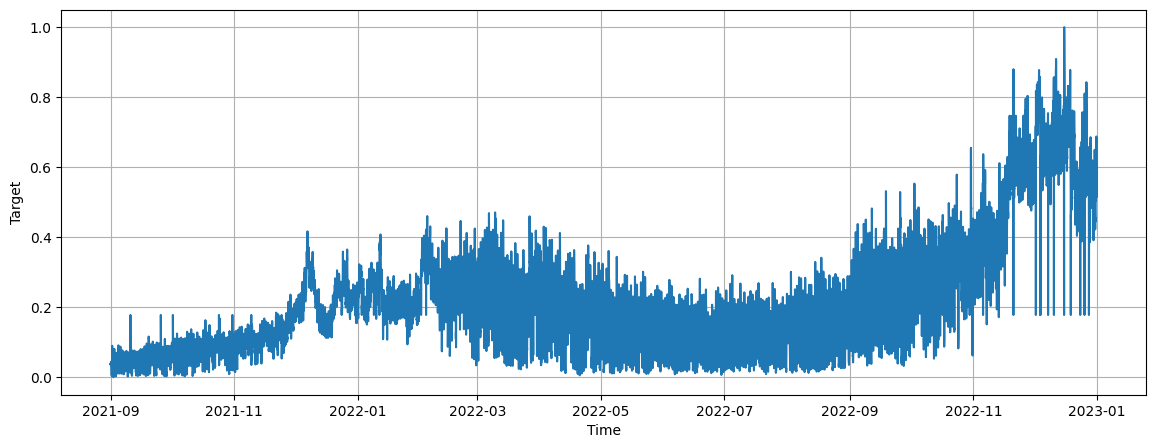

Valid


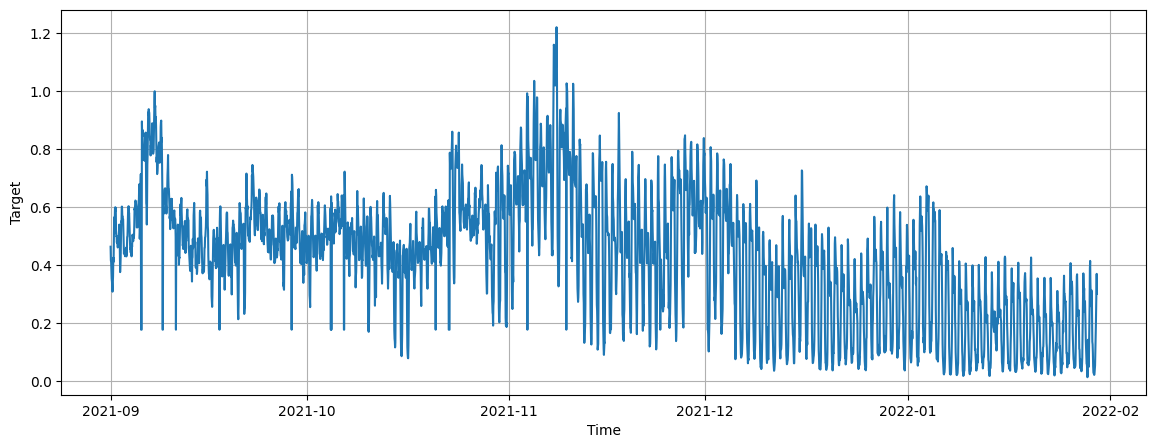

*********************************df_pivoted('target', '65')_c0*********************************
Train


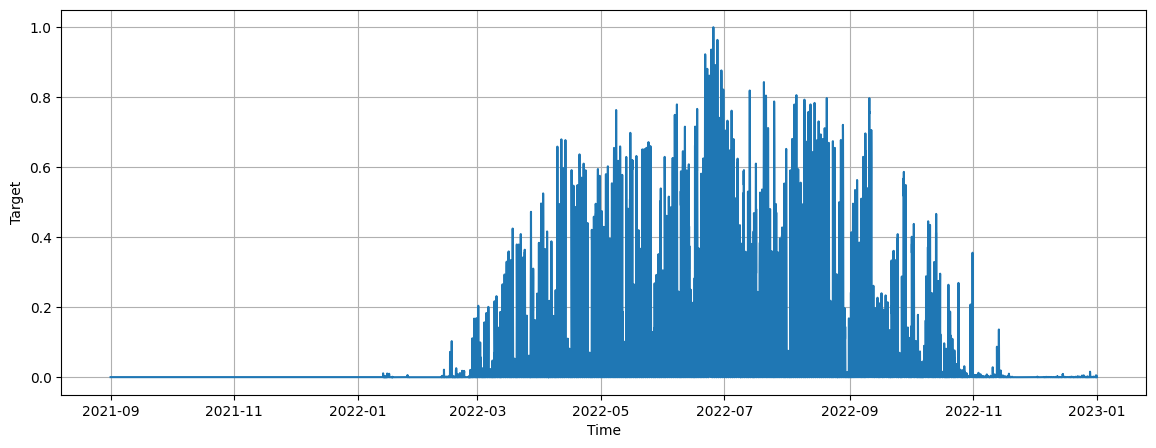

Valid


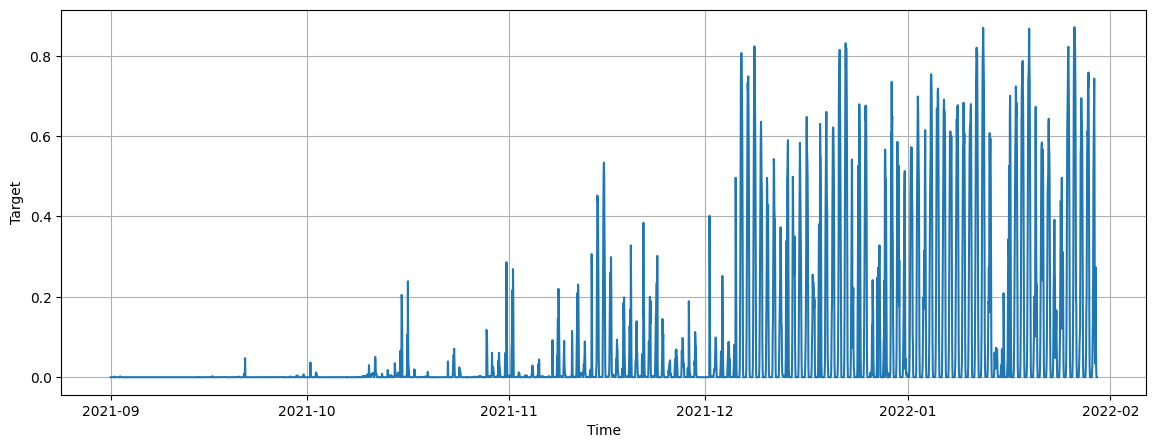

*********************************df_pivoted('target', '29')_c0*********************************
Train


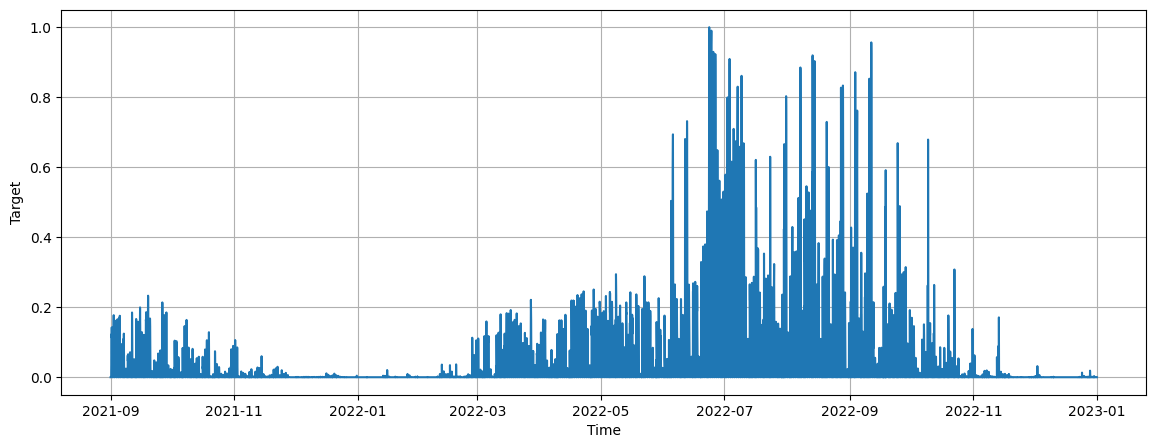

Valid


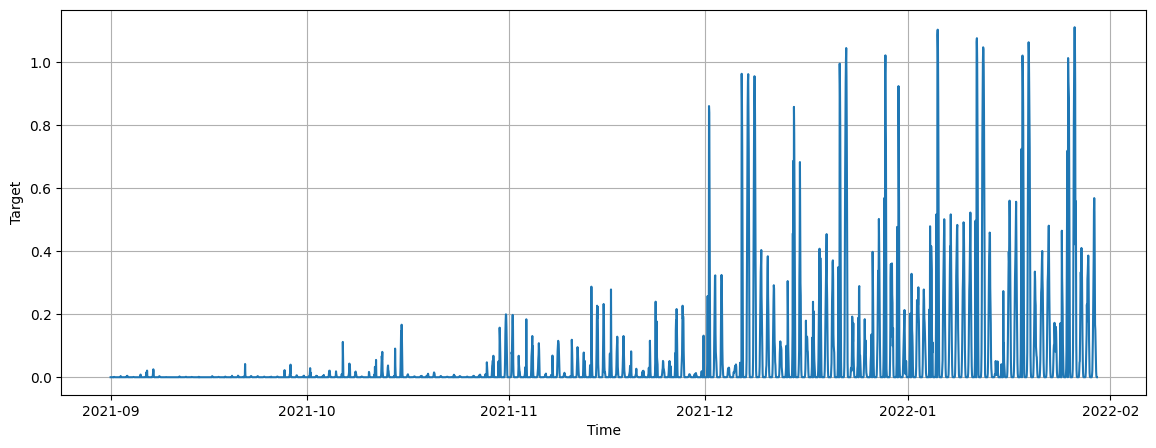

*********************************df_pivoted('target', '14')_c1*********************************
Train


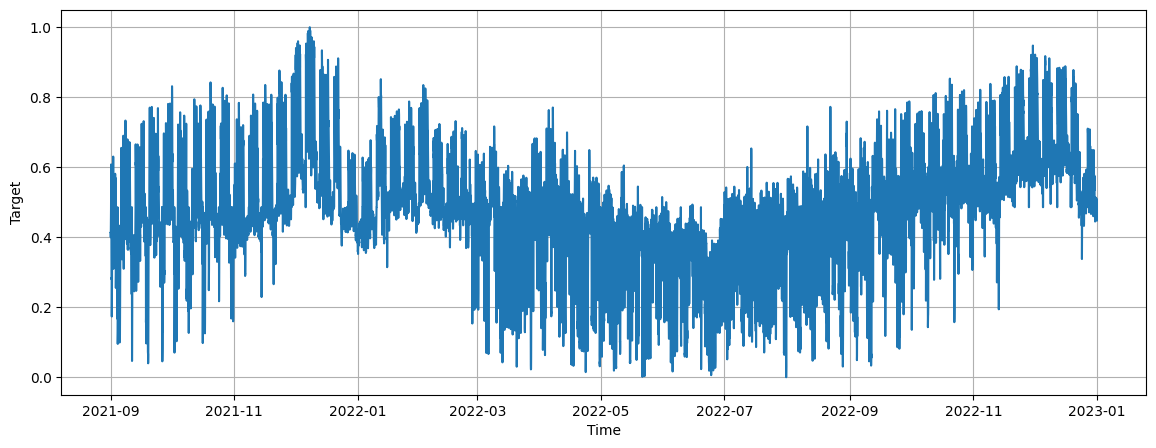

Valid


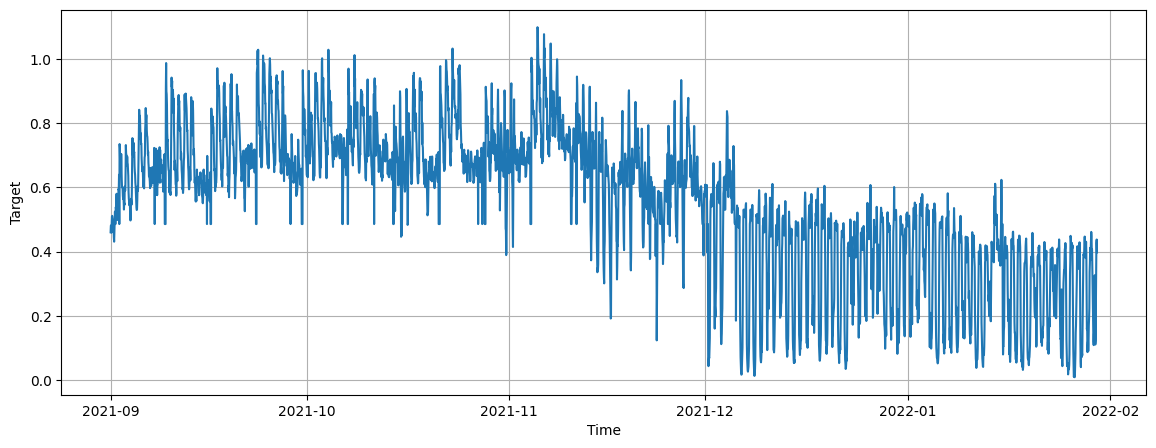

*********************************df_pivoted('target', '64')_c1*********************************
Train


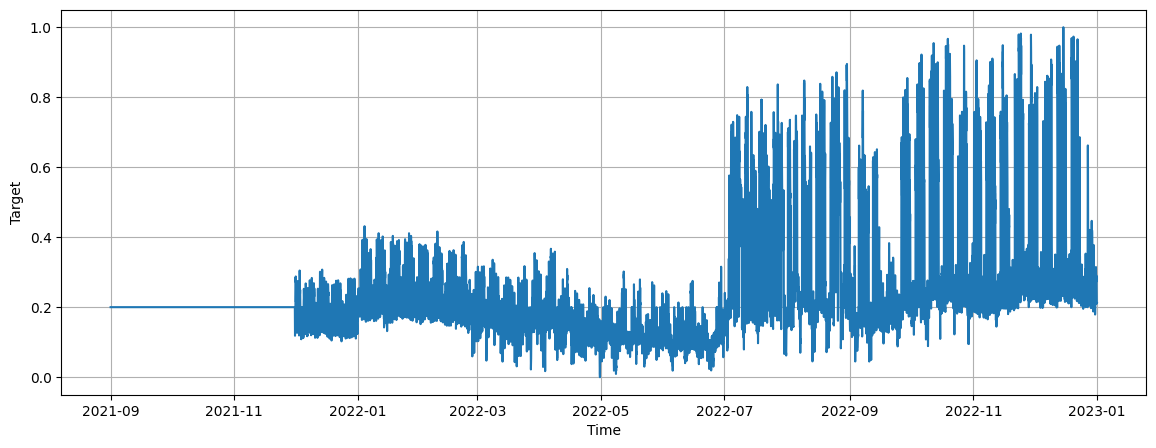

Valid


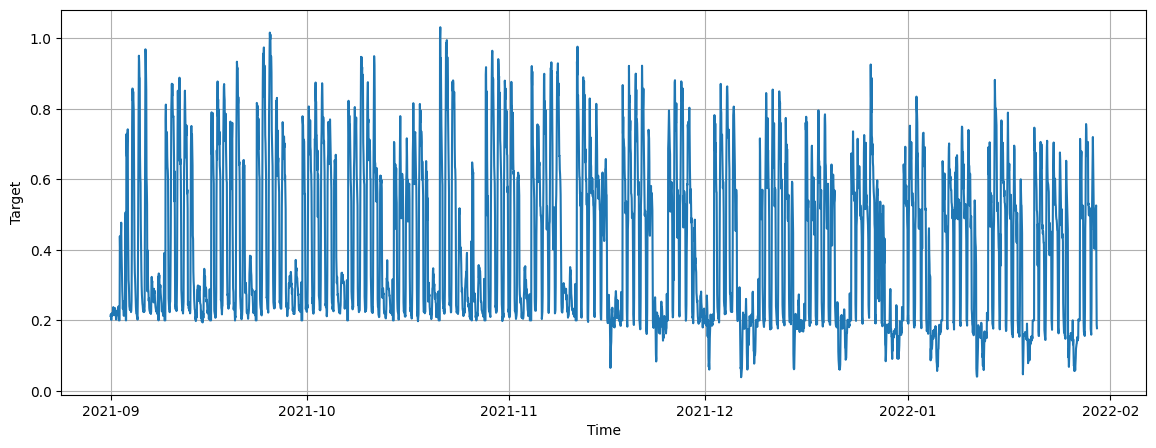

In [82]:
sample_target_plots=np.random.choice([x for x in range(0,139)], 5 ,replace=False,)
for col in sample_target_plots:
    print(f"{'*'*33}df_pivoted{df_pivoted.columns[col]}{'*'*33}")
    print("Train")
    plot_series(df_pivoted[:df_scaled_series_train.shape[0]].index,df_scaled_series_train[:,col] , format="-", start=0, end=None)
    print("Valid")
    plot_series(df_pivoted[:df_scaled_series_valid.shape[0]].index,df_scaled_series_valid[:,col] , format="-", start=0, end=None)

#### Windowing sanity checks

Desire is to create 24 hour of feature window mapped to 24 hour of label with 48 hour lag  pretty much as in this :
https://www.tensorflow.org/static/tutorials/structured_data/images/multistep_dense.png 
however predictions/labels starts from 48 not 24.

In [83]:
# desired mapping for first 2 window for column[0]
print("*"*30+"1st day"+"*"*30)
display(f"T0: {df_pivoted_time_train[0]}, {df_scaled_series_train[0][0]}")
display(f"T0 mapped to: {df_pivoted_time_train[48]}, {df_scaled_series_train[48][0]}")
display(f"T23: {df_pivoted_time_train[23]}, {df_scaled_series_train[23][0]}")
display(f"T23 mapped to: {df_pivoted_time_train[71]}, {df_scaled_series_train[71][0]}")
print("*"*30+"2nd day"+"*"*30)
display(f"T0: {df_pivoted_time_train[24]}, {df_scaled_series_train[24][0]}")
display(f"T0 mapped to: {df_pivoted_time_train[72]}, {df_scaled_series_train[72][0]}")
display(f"T23: {df_pivoted_time_train[47]}, {df_scaled_series_train[47][0]}")
display(f"T23 mapped to: {df_pivoted_time_train[95]}, {df_scaled_series_train[95][0]}")

******************************1st day******************************


'T0: 2021-09-01T00:00:00.000000000, 0.05276583507657051'

'T0 mapped to: 2021-09-03T00:00:00.000000000, 0.060319684445858'

'T23: 2021-09-01T23:00:00.000000000, 0.07494285702705383'

'T23 mapped to: 2021-09-03T23:00:00.000000000, 0.08382914215326309'

******************************2nd day******************************


'T0: 2021-09-02T00:00:00.000000000, 0.061923056840896606'

'T0 mapped to: 2021-09-04T00:00:00.000000000, 0.07093693315982819'

'T23: 2021-09-02T23:00:00.000000000, 0.06993204355239868'

'T23 mapped to: 2021-09-04T23:00:00.000000000, 0.07907707989215851'

In [84]:
# tf windowing sanity check in terms of indiches
dataset = tf.data.Dataset.range(96)
dataset = dataset.window(72, shift=24, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(72))
dataset = dataset.map(lambda window: (window[:-48], window[-24:]))

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
y =  [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]

x =  [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
y =  [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]



In [85]:
# tf windowing sanity check with dataset values
ds_trial = tf.data.Dataset.from_tensor_slices(df_scaled_series_train)
ds_trial = ds_trial.window(G.WINDOW_SIZE+48 , shift=24, drop_remainder=True)
ds_trial = ds_trial.flat_map(lambda w: w.batch(G.WINDOW_SIZE+48))
ds_trial = ds_trial.map(lambda w: (w[:-48], w[-24:][:,:G.NUM_TARGETS]))

for index,(x,y) in enumerate(ds_trial):
    print("x0 = ", x.numpy()[0][0], x.shape)
    print("y0 = ", y.numpy()[0][0], y.shape)
    print("x23 = ", x.numpy()[-1][0])
    print("y23 = ", y.numpy()[-1][0])
    print()
    if index==1:
        break

x0 =  0.052765835 (24, 687)
y0 =  0.060319684 (24, 69)
x23 =  0.07494286
y23 =  0.08382914

x0 =  0.061923057 (24, 687)
y0 =  0.07093693 (24, 69)
x23 =  0.06993204
y23 =  0.07907708



In [86]:
# helper function to window dataset
def windowed_dataset(series, target_start_indic, target_end_indic,
                     window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    #with tf.device('CPU:0'):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 48, shift=24, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 48))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-48], w[-24:][:,target_start_indic:target_end_indic]))
    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [87]:
%%time
# Applying the transformation to the training set
df_windowed_series_train_c1 = windowed_dataset(series=df_scaled_series_train,
                                                      target_start_indic=0,
                                                      target_end_indic=69)
df_windowed_series_valid_c1 = windowed_dataset(series=df_scaled_series_valid,
                                                      target_start_indic=0,
                                                      target_end_indic=69)
df_windowed_series_train_c0 = windowed_dataset(series=df_scaled_series_train,
                                                      target_start_indic=69,
                                                      target_end_indic=138)
df_windowed_series_valid_c0 = windowed_dataset(series=df_scaled_series_valid,
                                                      target_start_indic=69,
                                                      target_end_indic=138)

CPU times: user 229 ms, sys: 18.1 ms, total: 247 ms
Wall time: 259 ms


In [88]:
for tensor in df_windowed_series_train_c1:
    print(f"Shape of windowed tensors are input:{tensor[0].get_shape()},output:{tensor[1].get_shape()}")
    break
for tensor in df_windowed_series_train_c0:
    print(f"Shape of windowed tensors are input:{tensor[0].get_shape()},output:{tensor[1].get_shape()}")
    break

Shape of windowed tensors are input:(32, 24, 687),output:(32, 24, 69)
Shape of windowed tensors are input:(32, 24, 687),output:(32, 24, 69)


# Multivariate DNN (CNN, MultiHeadAttention, LSTM Hybrid) for Multistep Forecast

### Ref Papers for Model Architecture

* Guideline for reshaping model inputs and outputs to build a single shot model: 
    https://www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models

* Example Encoder implementation: 
    https://keras.io/examples/timeseries/timeseries_classification_transformer

* Original paper for multihead attention: 
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook

* Nice article that explains Attention is all you need paper: 
    https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634

* Other resources:
    https://github.com/google-research/google-research/tree/master/tft
    https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

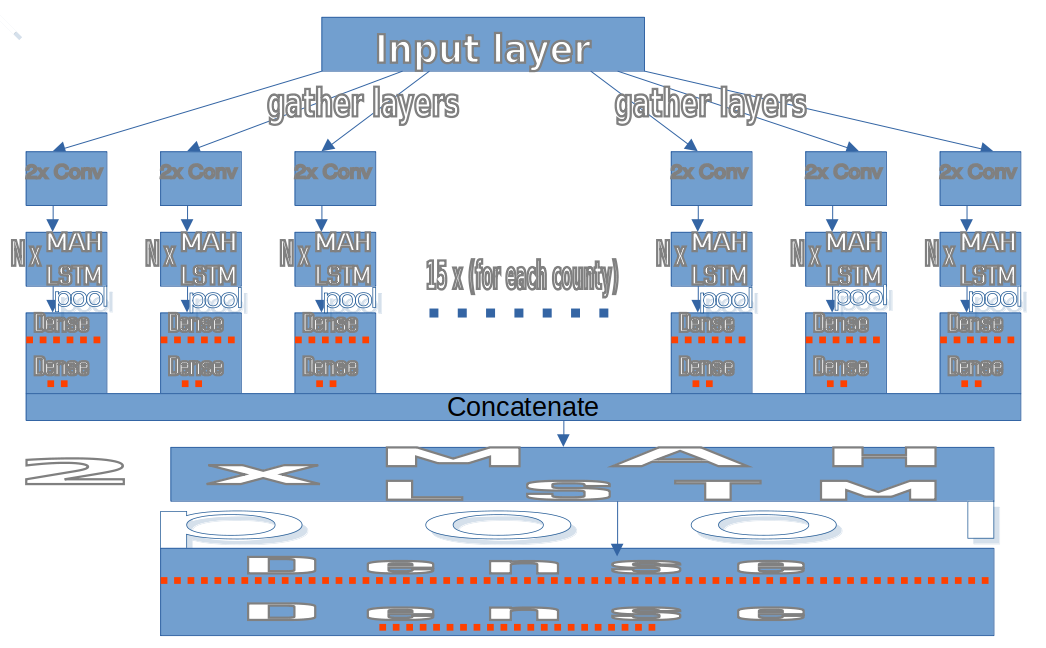

In [89]:
# model architecture
from IPython.display import Image
Image("/kaggle/input/enefitdnn/Screenshot from 2024-02-01 13-17-03.png")

In [90]:
def transformer_encoder_inner(inputs,key_dim, num_heads, dropout, key, bno):
    # Attention and Normalization
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=key_dim,num_heads=num_heads, attention_axes=(1, 2),
        dropout=dropout,name=str(key)+"_"+str(bno)+"_MHA")(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout, name=str(key)+"_"+str(bno)+"_MHA_dropout")(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=str(key)+"_"+str(bno)+"_MHA_LNorm")(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LSTM(inputs.shape[2], return_sequences=True, name=str(key)+"_"+str(bno)+"_LSTM_1")(res)
    x = tf.keras.layers.LSTM(inputs.shape[2], return_sequences=True, name=str(key)+"_"+str(bno)+"_LSTM_2")(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6,name=str(key)+"_"+str(bno)+"_LSTM_LNorm" )(x)
    return x + res

In [91]:
def transformer_encoder_outer(inputs,key_dim, num_heads, dropout, bno):
    # Attention and Normalization
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=key_dim,num_heads=num_heads, attention_axes=(1, 2),
        dropout=dropout,name=str(bno)+"_MHA")(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout, name=str(bno)+"_MHA_dropout")(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=str(bno)+"_MHA_LNorm")(x)
    res = x + inputs

    # Feed Forward Part
    x = tf.keras.layers.LSTM(inputs.shape[2], return_sequences=True, name=str(bno)+"_LSTM_1")(res)
    x = tf.keras.layers.LSTM(inputs.shape[2], return_sequences=True, name=str(bno)+"_LSTM_2")(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=str(bno)+"_LSTM_LNorm" )(x)
    return x + res

In [92]:
class GatherLayer(tf.keras.layers.Layer):
    def __init__(self, indices, name):
        super(GatherLayer, self).__init__(name=name)
        self.indices = indices
    
    @tf.function
    def call(self, inputs):
        #with tf.device('CPU:0'):
        result=tf.gather(params=inputs, indices=self.indices,axis=-1,batch_dims=0)
        return result


In [93]:
def build_model(initializer, l1, l2, num_transformer_blocks, num_heads, sc_dropout,
                mlp_units_outer, mlp_dropout2, dropout,
                conv_dropout, NUM_FEATURES=G.NUM_FEATURES,
                NUM_TARGETS= G.NUM_TARGETS, WINDOW_SIZE=G.WINDOW_SIZE):

    regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    activation=tf.keras.layers.LeakyReLU(alpha = 0.01)
    inputs = tf.keras.Input(shape=[WINDOW_SIZE, NUM_FEATURES])

    map={}
    map[0]=GatherLayer(indices=[0, 1, 2, 3, 4, 5, 61, 69, 70, 71, 72, 73, 74, 130, 138, 139, 140, 141, 142, 143, 
                                199, 207, 208, 209, 210, 211, 212, 268, 276, 277, 278, 279, 280, 281, 282, 283, 
                                284, 285, 286, 287, 288, 289, 669, 670, 671, 672, 673, 674, 675, 
                                676, 685, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 677, 678, 
                                679, 680, 681, 682, 683, 684, 686],
                   name=str(0)+"_gather")(inputs)
    

    map[1]=GatherLayer(indices=[6, 7, 8, 75, 76, 77, 144, 145, 146, 213, 214, 215, 290, 291, 292, 293, 294, 295,
                                296, 297, 298, 299, 300, 301, 302, 303, 669, 670, 671, 672, 673,
                                674, 675, 676, 685, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509,
                                677, 678, 679, 680, 681, 682, 683, 684, 686],
                   name=str(1)+"_gather")(inputs)
    

    map[2]=GatherLayer(indices=[9, 10, 62, 65, 78, 79, 131, 134, 147, 148, 200, 203, 216, 217, 269, 272, 304, 
                                305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 
                                669, 670, 671, 672, 673, 674, 675, 676, 685, 510, 511, 512, 513, 514, 515, 516,
                                517, 518, 519, 520, 521, 677, 678, 679, 680, 681, 682, 683, 684, 686],
                   name=str(2)+"_gather")(inputs)
    

    map[3]=GatherLayer(indices=[11, 12, 13, 14, 80, 81, 82, 83, 149, 150, 151, 152, 218, 219, 220, 221, 318,
                                319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
                                669, 670, 671, 672, 673, 674, 675, 676, 685, 522, 523, 524, 525, 526, 527, 528,
                                529, 530, 531, 532, 533, 677, 678, 679, 680, 681, 682, 683, 684, 686],
                   name=str(3)+"_gather")(inputs)
    

    map[4]=GatherLayer(indices=[15, 16, 17, 18, 66, 84, 85, 86, 87, 135, 153, 154, 155, 156, 204, 222, 223, 
                                224, 225, 273, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 
                                344,345, 669, 670, 671, 672, 673, 674, 675, 676, 685, 534, 
                                535,  536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 677, 678, 679, 680,
                                681, 682, 683, 684, 686],
                   name=str(4)+"_gather")(inputs)
    

    map[5]=GatherLayer(indices=[19, 20, 21, 22, 23, 88, 89, 90, 91, 92, 157, 158, 159, 160, 161, 226, 227,
                                228, 229, 230, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
                                358, 359, 669, 670, 671, 672, 673, 674, 675, 676, 685, 546,
                                547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 677, 678, 679, 680,
                                681, 682, 683, 684, 686],
                   name=str(5)+"_gather")(inputs)
    

    map[6]=GatherLayer(indices=[24, 49, 93, 118, 162, 187, 231, 256, 360, 361, 362, 363, 364, 365, 366, 367,
                                368, 369, 370, 371, 372, 373, 669, 670, 671, 672, 673, 674, 
                                675, 676, 685, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 
                                677, 678, 679, 680, 681, 682, 683, 684, 686],
                   name=str(6)+"_gather")(inputs)
    

    map[7]=GatherLayer(indices=[25, 26, 27, 28, 29, 30, 94, 95, 96, 97, 98, 99, 163, 164, 165, 166, 167,
                                168, 232, 233, 234, 235, 236, 237, 374, 375, 376, 377, 378, 379, 380, 381,
                                382, 383, 384, 385, 386, 387, 669, 670, 671, 672, 673, 674,
                                675, 676, 685, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,
                                677, 678, 679, 680, 681, 682, 683, 684, 686],
                   name=str(7)+"_gather")(inputs)
    

    map[8]=GatherLayer(indices=[31, 32, 33, 100, 101, 102, 169, 170, 171, 238, 239, 240, 388, 389, 390, 391,
                                392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 669, 670,
                                671, 672, 673, 674, 675, 676, 685, 582, 583, 584, 585, 586, 587, 588, 589, 
                                590, 591, 592, 593, 677, 678, 679, 680, 681, 682, 683, 684, 686],
                   name=str(8)+"_gather")(inputs)
    

    map[9]=GatherLayer(indices=[34, 35, 36, 37, 103, 104, 105, 106, 172, 173, 174, 175, 241, 242, 243, 244,
                                402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 
                                669, 670, 671, 672, 673, 674, 675, 676, 685, 594, 595, 596, 597,
                                598, 599, 600, 601, 602, 603, 604, 605, 677, 678, 679, 680, 681, 682, 683, 
                                684, 686],
                   name=str(9)+"_gather")(inputs)
    

    map[10]=GatherLayer(indices=[38, 39, 40, 41, 42, 107, 108, 109, 110, 111, 176, 177, 178, 179, 180, 245,
                                246, 247, 248, 249, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
                                427, 428, 429, 669, 670, 671, 672, 673, 674, 675, 676, 685,
                                606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 677, 678, 679,
                                680, 681, 682, 683, 684, 686],
                    name=str(10)+"_gather")(inputs)
    

    map[11]=GatherLayer(indices=[43, 44, 45, 46, 47, 48, 67, 112, 113, 114, 115, 116, 117, 136, 181, 182,
                                183, 184, 185, 186, 205, 250, 251, 252, 253, 254, 255, 274, 430, 431, 432,
                                433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 669,
                                670, 671, 672, 673, 674, 675, 676, 685, 618, 619, 620, 621, 622, 623, 624,
                                625, 626, 627, 628, 629, 677, 678, 679, 680, 681, 682, 683, 684, 686],
                    name=str(11)+"_gather")(inputs)
    

    map[13]=GatherLayer(indices=[50, 51, 52, 63, 119, 120, 121, 132, 188, 189, 190, 201, 257, 258, 259, 270,
                                444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
                                 669, 670, 671, 672, 673, 674, 675, 676, 685, 630, 631, 632, 633,
                                634, 635, 636, 637, 638, 639, 640, 641, 677, 678, 679, 680, 681, 682, 683,
                                684, 686],
                    name=str(13)+"_gather")(inputs)
    

    map[14]=GatherLayer(indices=[53, 54, 55, 56, 68, 122, 123, 124, 125, 137, 191, 192, 193, 194, 206, 260,
                                261, 262, 263, 275, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
                                469, 470, 471, 669, 670, 671, 672, 673, 674, 675, 676, 685,
                                642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 677, 678, 679,
                                680, 681, 682, 683, 684, 686],
                    name=str(14)+"_gather")(inputs)
    

    map[15]=GatherLayer(indices=[57, 58, 59, 60, 64, 126, 127, 128, 129, 133, 195, 196, 197, 198, 202, 264,
                                265, 266, 267, 271, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482,
                                483, 484, 485, 669, 670, 671, 672, 673, 674, 675, 676, 685,
                                654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 677, 678, 679, 
                                680, 681, 682, 683, 684, 686],
                    name=str(15)+"_gather")(inputs)
    

    for key, data in map.items():
        sub_input_shape=data.shape[-1]

        x = tf.keras.layers.Conv1D(filters=sub_input_shape*2, kernel_size=1,
                                   padding='causal',activation=activation,
                                  name=str(key)+'_Conv1D1')(data)
        x=tf.keras.layers.Dropout(dropout[key], name = str(key)+'_Inner_Dropout1')(x)
        x = tf.keras.layers.Conv1D(filters=sub_input_shape, kernel_size=1,
                                   padding='causal',activation=activation,
                                  name=str(key)+'_Conv1D2')(x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=str(key)+'_Conv1D_LNorm')(x)


        for i in range(num_transformer_blocks[key]):
            x=transformer_encoder_inner(inputs=x, key_dim = int(sub_input_shape/num_heads[key]),
                                  num_heads = num_heads[key], dropout = dropout[key],
                                  key = key, bno=i)
        noin0=x.shape[-1]

        x=tf.keras.layers.GlobalAveragePooling1D(data_format='channels_first', name=str(key)+'_GAP1D')(x)
        x=tf.keras.layers.Dense(x.shape[-1], activation=activation,
                            kernel_regularizer=regularizer, kernel_initializer=initializer,
                            name = str(key)+'_DenseInner1')(x)
        x=tf.keras.layers.Dropout(sc_dropout[key], name = str(key)+'_SubConcat_Dropout2')(x)
        x=tf.keras.layers.Dense(((noin0-44)/4)*24, activation=activation,
                            kernel_regularizer=regularizer, kernel_initializer=initializer,
                            name = str(key)+'_DenseInner2')(x)
        if key == 0:
            xp=x
        else:
            xp= tf.keras.layers.Concatenate(axis=-1, name = str(key)+'_Global_Concat')([xp,x])


    xp = tf.keras.layers.Reshape([WINDOW_SIZE, NUM_TARGETS], name = 'Output_Reshape1')(xp)

    for i in range(2):
        xp=transformer_encoder_outer(inputs=xp, key_dim = int(xp.shape[-1]/4), num_heads = 4, dropout = 0.2, bno=i)
    xp=tf.keras.layers.GlobalAveragePooling1D(data_format='channels_first', name='GAP1D')(xp)
    xp = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='Outer_LNorm')(xp)

    xp = tf.keras.layers.Dense(mlp_units_outer, activation=activation, kernel_regularizer=regularizer, 
                              kernel_initializer=initializer, name='DenseOuter1')(xp)
    xp = tf.keras.layers.Dropout(mlp_dropout2, name = 'Outer_Dropout2')(xp)
    xp = tf.keras.layers.Dense(WINDOW_SIZE*NUM_TARGETS, name = 'DenseOutPut')(xp)
    xp = tf.keras.layers.Reshape([WINDOW_SIZE, NUM_TARGETS], name = 'Output_Reshape2')(xp)
    return tf.keras.Model(inputs, xp, name = "conv_seqtoseq_trans_sep_cc_layers")

In [94]:
def model_builder(lr, initializer, l1, l2, num_transformer_blocks, num_heads,
                  dropout, sc_dropout, mlp_units_outer,
                  mlp_dropout2, conv_dropout):
    IPython.display.clear_output()
    gc.collect()
    tf.keras.backend.clear_session()
    if K.backend() == 'tensorflow':
        K.clear_session()

    model = build_model(initializer=initializer,
                        l1=l1,
                        l2=l2,
                        num_transformer_blocks=num_transformer_blocks,
                        num_heads=num_heads,
                        dropout=dropout,
                        sc_dropout=sc_dropout,
                        mlp_units_outer=mlp_units_outer,
                        mlp_dropout2=mlp_dropout2,
                        conv_dropout=conv_dropout)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=["mae"])

    return model

In [95]:
# callback function to avoid any memory leak issue and reset states in tf.keras
class ClearMemory(Callback):
    def on_train_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        if K.backend() == 'tensorflow':
            K.clear_session()

In [96]:
def call():
    #early stopping
    es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # metrics to monitor
    min_delta=1e-6,#min amoung to count as an improvement
    patience=25, # how many epochs before stop
    verbose=1,
    mode='min',
    restore_best_weights=True)

    # reducing learning rate on plateau
    rp = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75, # reducing learning rate on plateau
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6)
    return es,rp

In [97]:
gc.collect()
tf.keras.backend.clear_session()
hp_num_transformer_blocks_c1={}
hp_num_transformer_blocks_c1[0]=2
hp_num_transformer_blocks_c1[1]=4
hp_num_transformer_blocks_c1[2]=1
hp_num_transformer_blocks_c1[3]=3
hp_num_transformer_blocks_c1[4]=4
hp_num_transformer_blocks_c1[5]=3
hp_num_transformer_blocks_c1[6]=4
hp_num_transformer_blocks_c1[7]=2
hp_num_transformer_blocks_c1[8]=4
hp_num_transformer_blocks_c1[9]=4
hp_num_transformer_blocks_c1[10]=3
hp_num_transformer_blocks_c1[11]=3
hp_num_transformer_blocks_c1[13]=3
hp_num_transformer_blocks_c1[14]=3
hp_num_transformer_blocks_c1[15]=3

model_c1=model_builder(lr=1e-4,
                    initializer="glorot_normal",
                    l1=0,
                    l2=0,
                    num_transformer_blocks=hp_num_transformer_blocks_c1,
                    num_heads={key:4 for key in G.MAP.keys()},
                    dropout={key:0.17946584836003035 for key in G.MAP.keys()},
                    sc_dropout={key:0.05954073057846882 for key in G.MAP.keys()},
                    mlp_units_outer=4432,
                    mlp_dropout2=0.584671405648467,
                    conv_dropout={key:0.5916529653910001 for key in G.MAP.keys()})

In [98]:
model_c1.summary()

Model: "conv_seqtoseq_trans_sep_cc_layers"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 687)]            0         []                            
                                                                                                  
 1_gather (GatherLayer)      (None, 24, 56)               0         ['input_1[0][0]']             
                                                                                                  
 1_Conv1D1 (Conv1D)          (None, 24, 112)              6384      ['1_gather[0][0]']            
                                                                                                  
 1_Inner_Dropout1 (Dropout)  (None, 24, 112)              0         ['1_Conv1D1[0][0]']           
                                                                  

In [99]:
%%time
gc.collect()
tf.keras.backend.clear_session()
if K.backend() == 'tensorflow':
    K.clear_session()
history_c1 = model_c1.fit(df_windowed_series_train_c1,  epochs=1000, verbose=1,#use_multiprocessing = True,
                    validation_data=df_windowed_series_valid_c1,
                    callbacks=[call(),ClearMemory()])

Epoch 1/1000
16/16 [==============================] - 311s 3s/step - loss: 0.0502 - mae: 0.2538 - val_loss: 0.0632 - val_mae: 0.2665 - lr: 1.0000e-04
Epoch 2/1000
16/16 [==============================] - 7s 407ms/step - loss: 0.0226 - mae: 0.1655 - val_loss: 0.0397 - val_mae: 0.2051 - lr: 1.0000e-04
Epoch 3/1000
16/16 [==============================] - 6s 380ms/step - loss: 0.0176 - mae: 0.1429 - val_loss: 0.0412 - val_mae: 0.2059 - lr: 1.0000e-04
Epoch 4/1000
16/16 [==============================] - 6s 394ms/step - loss: 0.0140 - mae: 0.1248 - val_loss: 0.0326 - val_mae: 0.1797 - lr: 1.0000e-04
Epoch 5/1000
16/16 [==============================] - 6s 400ms/step - loss: 0.0116 - mae: 0.1132 - val_loss: 0.0292 - val_mae: 0.1676 - lr: 1.0000e-04
Epoch 6/1000
16/16 [==============================] - 7s 421ms/step - loss: 0.0100 - mae: 0.1050 - val_loss: 0.0267 - val_mae: 0.1565 - lr: 1.0000e-04
Epoch 7/1000
16/16 [==============================] - 6s 398ms/step - loss: 0.0091 - mae: 0.099

In [100]:
def plot_epoch_graphs(history, string):
    plt.subplots(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title("All Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.subplot(1, 2, 2)
    plt.plot(history.history[string][-26:])
    plt.plot(history.history['val_'+string][-26:])
    plt.title("Last 26 Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    plt.close()

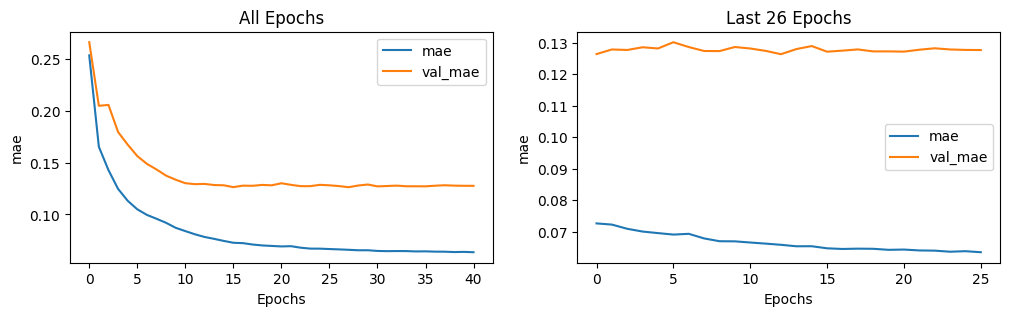

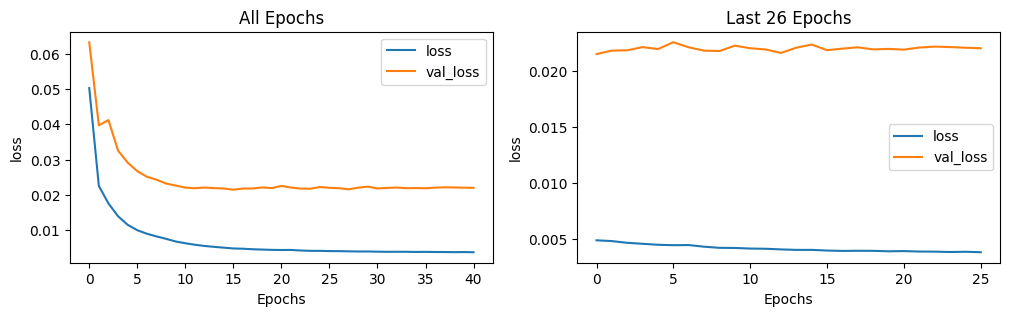

In [101]:
plot_epoch_graphs(history_c1, "mae")
plot_epoch_graphs(history_c1, "loss")

In [102]:
gc.collect()
tf.keras.backend.clear_session()
hp_num_transformer_blocks_c0={}
hp_num_transformer_blocks_c0[0]=1
hp_num_transformer_blocks_c0[1]=2
hp_num_transformer_blocks_c0[2]=1
hp_num_transformer_blocks_c0[3]=4
hp_num_transformer_blocks_c0[4]=2
hp_num_transformer_blocks_c0[5]=3
hp_num_transformer_blocks_c0[6]=4
hp_num_transformer_blocks_c0[7]=4
hp_num_transformer_blocks_c0[8]=3
hp_num_transformer_blocks_c0[9]=1
hp_num_transformer_blocks_c0[10]=4
hp_num_transformer_blocks_c0[11]=1
hp_num_transformer_blocks_c0[13]=4
hp_num_transformer_blocks_c0[14]=4
hp_num_transformer_blocks_c0[15]=3

model_c0=model_builder(lr=1e-4,
                    initializer="glorot_normal",
                    l1=0,
                    l2=0,
                    num_transformer_blocks=hp_num_transformer_blocks_c0,
                    num_heads={key:4 for key in G.MAP.keys()},
                    dropout={key:0.0074068828115691375 for key in G.MAP.keys()},
                    sc_dropout={key:0.023979497966853835 for key in G.MAP.keys()},
                    mlp_units_outer=4432,
                    mlp_dropout2=0.034985269967344655,
                    conv_dropout={key:0.2808433880994481 for key in G.MAP.keys()})
model_c0.summary()

Model: "conv_seqtoseq_trans_sep_cc_layers"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 687)]            0         []                            
                                                                                                  
 3_gather (GatherLayer)      (None, 24, 60)               0         ['input_1[0][0]']             
                                                                                                  
 3_Conv1D1 (Conv1D)          (None, 24, 120)              7320      ['3_gather[0][0]']            
                                                                                                  
 3_Inner_Dropout1 (Dropout)  (None, 24, 120)              0         ['3_Conv1D1[0][0]']           
                                                                  

In [103]:
%%time
gc.collect()
tf.keras.backend.clear_session()
if K.backend() == 'tensorflow':
    K.clear_session()
history_c0 = model_c0.fit(df_windowed_series_train_c0,  epochs=1000, verbose=1,#use_multiprocessing = True,
                    validation_data=df_windowed_series_valid_c0,
                    callbacks=[call(),ClearMemory()])

Epoch 1/1000
16/16 [==============================] - 276s 2s/step - loss: 0.0147 - mae: 0.0804 - val_loss: 0.0594 - val_mae: 0.1460 - lr: 1.0000e-04
Epoch 2/1000
16/16 [==============================] - 6s 386ms/step - loss: 0.0077 - mae: 0.0709 - val_loss: 0.0476 - val_mae: 0.1192 - lr: 1.0000e-04
Epoch 3/1000
16/16 [==============================] - 6s 383ms/step - loss: 0.0043 - mae: 0.0501 - val_loss: 0.0403 - val_mae: 0.1062 - lr: 1.0000e-04
Epoch 4/1000
16/16 [==============================] - 6s 386ms/step - loss: 0.0036 - mae: 0.0435 - val_loss: 0.0399 - val_mae: 0.0990 - lr: 1.0000e-04
Epoch 5/1000
16/16 [==============================] - 6s 352ms/step - loss: 0.0032 - mae: 0.0400 - val_loss: 0.0409 - val_mae: 0.0968 - lr: 1.0000e-04
Epoch 6/1000
16/16 [==============================] - 6s 363ms/step - loss: 0.0033 - mae: 0.0396 - val_loss: 0.0402 - val_mae: 0.0955 - lr: 1.0000e-04
Epoch 7/1000
16/16 [==============================] - 6s 375ms/step - loss: 0.0031 - mae: 0.038

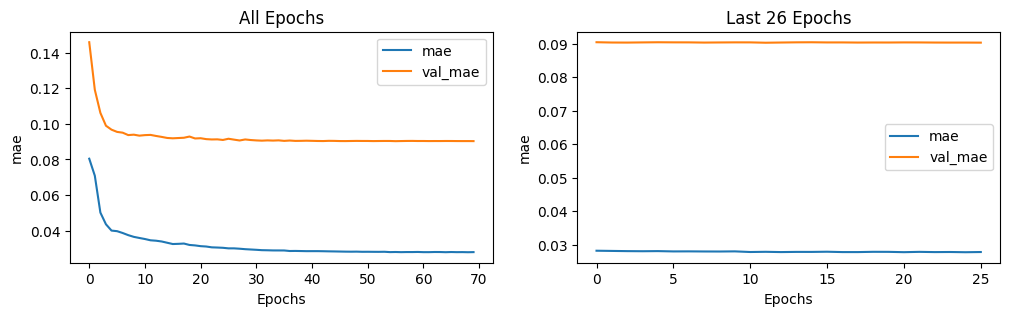

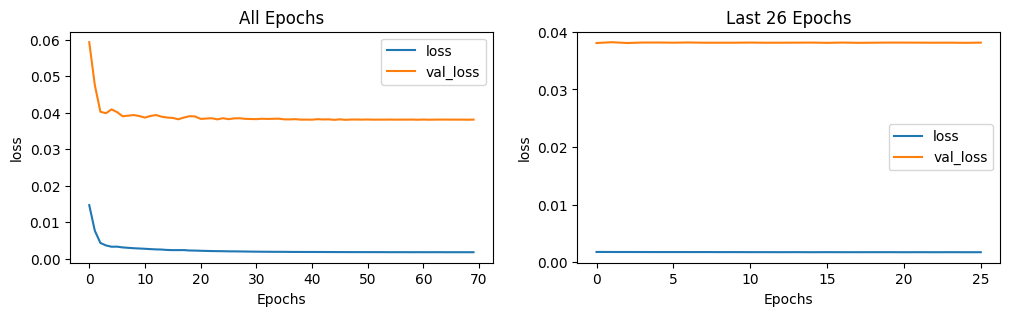

In [104]:
plot_epoch_graphs(history_c0, "mae")
plot_epoch_graphs(history_c0, "loss")

### Performance Evaluation

In [105]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error,r2_score
# helper function to calculate regression metrics
def calcMetrics(testActualVal, predictions):
    #regression evaluation measures
    data={"MAE":[mean_absolute_error(testActualVal, predictions)],
         "RMSE":[mean_squared_error(testActualVal, predictions)**0.5],
         "R2":[r2_score(testActualVal, predictions)]}
    metric_df=pd.DataFrame(data)
    return metric_df

In [106]:
# helper function for to create windowed dataset without shuffling for fast forecasting
def model_forecast(model, series, window_size):
    #with tf.device('CPU:0'):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=24, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(8).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [107]:
display(f"{df_pivoted_time_valid[0]} end date: {df_pivoted_time_valid[-1]}")

'2023-01-01T00:00:00.000000000 end date: 2023-05-31T23:00:00.000000000'

In [108]:
%%time
dnn_forecast_c1 = model_forecast(model_c1,df_scaled_series_valid, G.WINDOW_SIZE).squeeze()
dnn_forecast_c0 = model_forecast(model_c0,df_scaled_series_valid, G.WINDOW_SIZE).squeeze()
dnn_forecast_whole=np.concatenate((dnn_forecast_c1 ,dnn_forecast_c0), axis=-1)
scaler_predictions=MinMaxScaler().fit(df_pivoted_series_train[:,:138])
dnn_forecast_unscale=scaler_predictions.inverse_transform(dnn_forecast_whole.reshape(-1,dnn_forecast_whole.shape[-1]))
dnn_forecast_unscale[dnn_forecast_unscale<0]=0

19/19 [==============================] - 32s 106ms/step
CPU times: user 1min 17s, sys: 1.52 s, total: 1min 18s
Wall time: 1min 9s


In [109]:
df_scaled_series_valid_unscale=scaler_predictions.inverse_transform(df_scaled_series_valid[:,:138].reshape(-1,df_scaled_series_valid[:,:138].shape[-1]))
df_valid_pivot=pd.DataFrame(data=df_scaled_series_valid_unscale[:,:138], index=df_pivoted_time_valid, columns=df_pivoted.columns[:138])
dnn_forecast_time=df_pivoted_time_valid+pd.to_timedelta(48,unit='h')
df_pred_pivot=pd.DataFrame(data=dnn_forecast_unscale, index=dnn_forecast_time[:],columns=df_pivoted.columns[:138])

In [110]:
calcMetrics(df_valid_pivot[df_valid_pivot.index>=df_pred_pivot.index[0]],
           df_pred_pivot[df_pred_pivot.index<=df_valid_pivot.index[-1]])

MAE        RMSE        R2
0  91.798401  309.513858  0.130874

In [111]:
#helper function to plot time series actual vs time series predicted
def plot_series_multi(df,label1, label2, format1="--",format2="-", start=0, end=None ):
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_axes([1, 1, 1, 1])
    time1=df['datetime']
    series1=df['target_pred']
    series2=df['target_actual']
    ax.scatter(time1[start:end], series1[start:end], marker=format1)
    ax.scatter(time1[start:end], series2[start:end], marker=format2)
    ax.legend(labels = (label1, label2))
    plt.xlabel("Time")
    plt.ylabel("Targets")

    plt.grid(True)
    df[["datetime","target_pred","target_actual"]].groupby(["datetime"]).mean().plot(figsize=(13,3))
    plt.xlabel('Time')
    plt.ylabel("Mean Targets")
    plt.show()
    plt.close()

('target', '30')_c0


MAE        RMSE        R2
0  83.662537  189.323951  0.718101

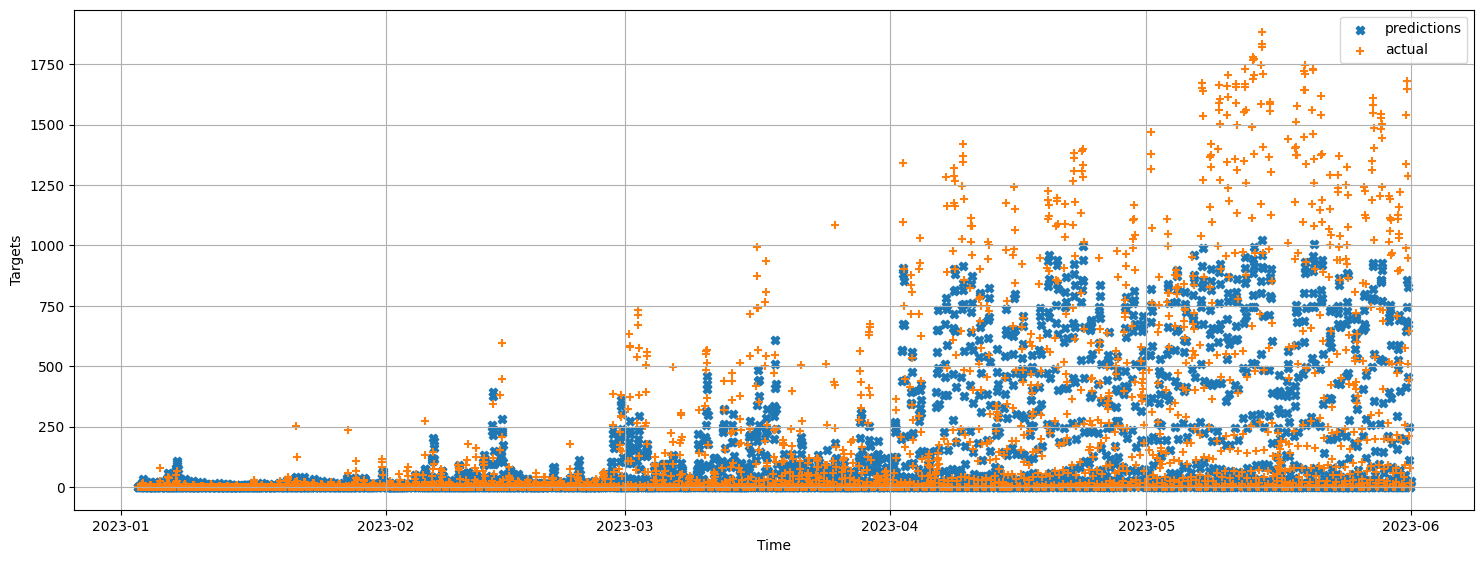

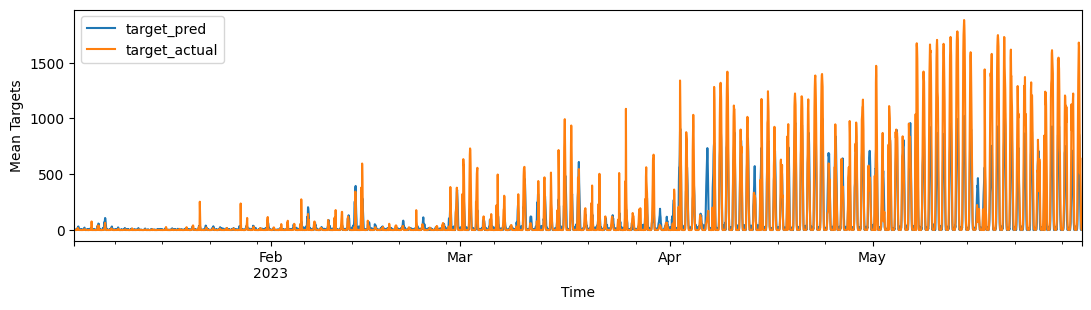

('target', '8')_c1


MAE       RMSE        R2
0  15.366792  19.969016  0.549713

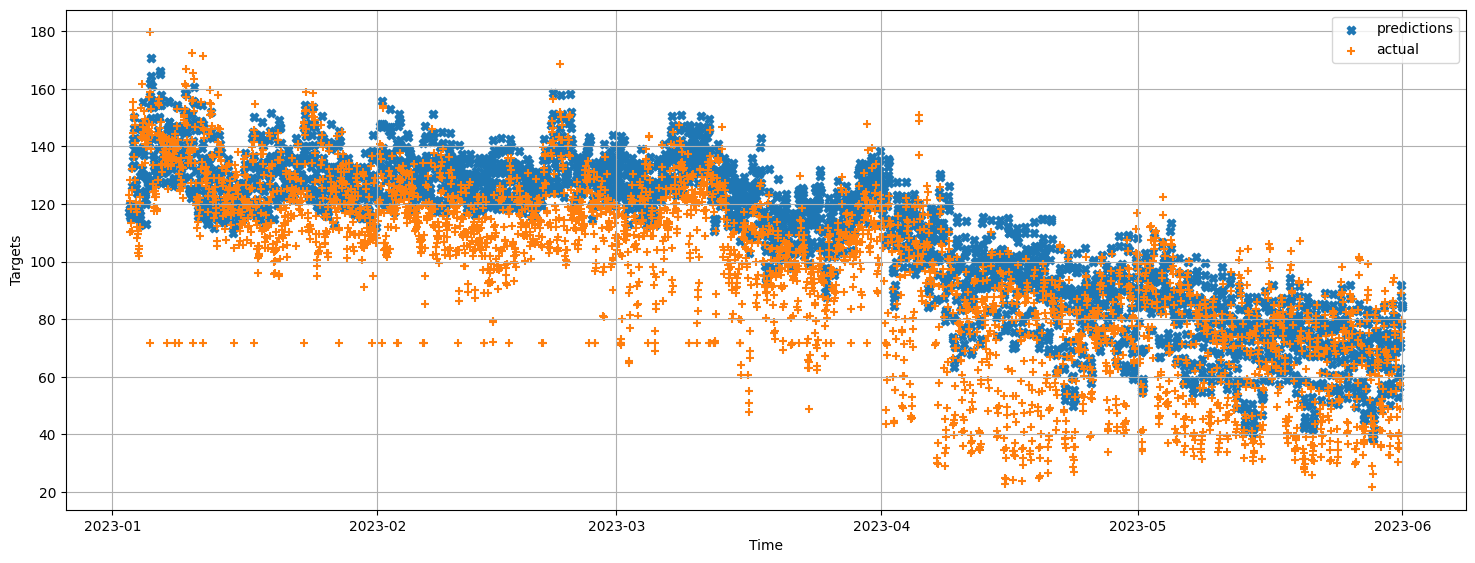

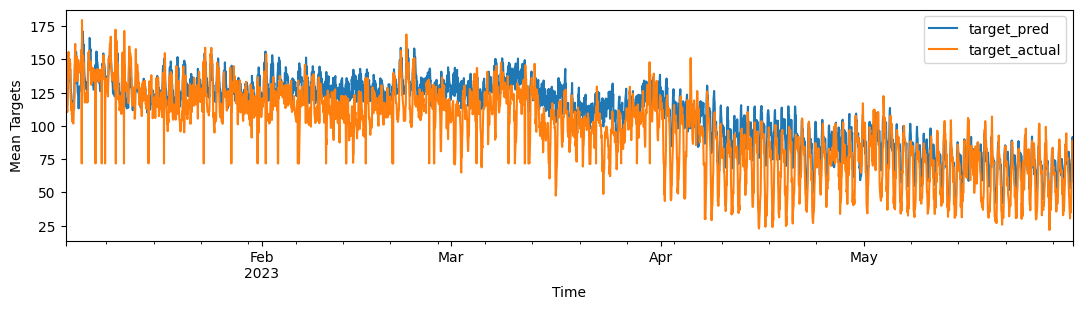

('target', '20')_c1


MAE       RMSE        R2
0  51.379448  63.024127  0.638174

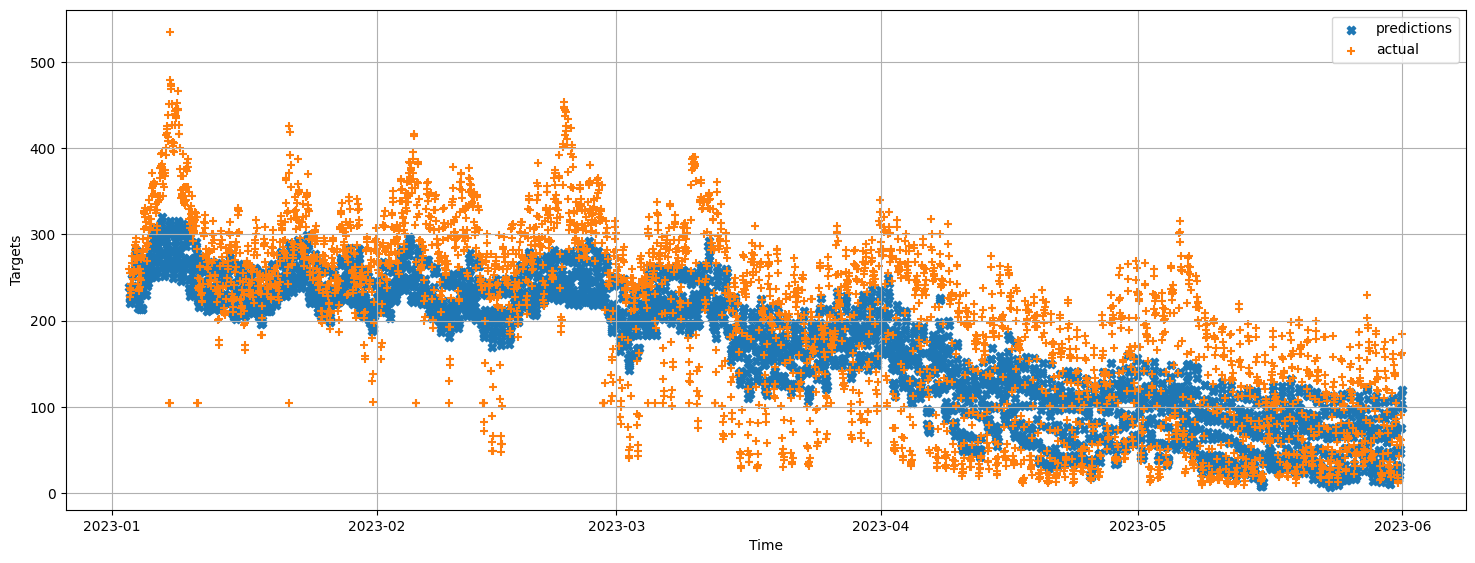

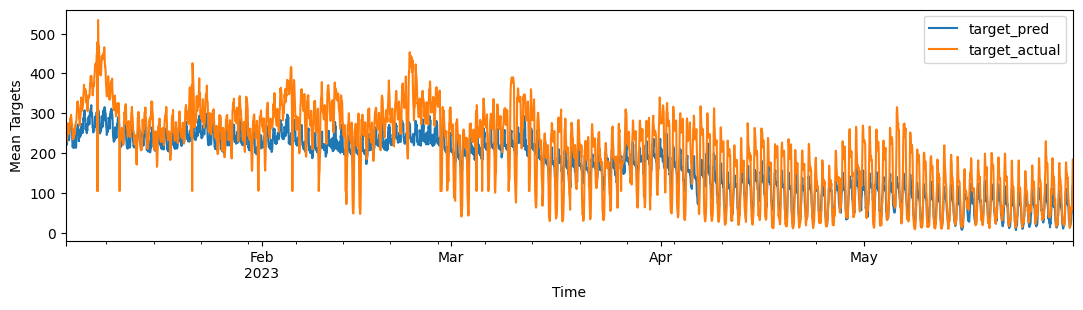

('target', '61')_c1


MAE       RMSE       R2
0  38.118858  45.500118 -0.11418

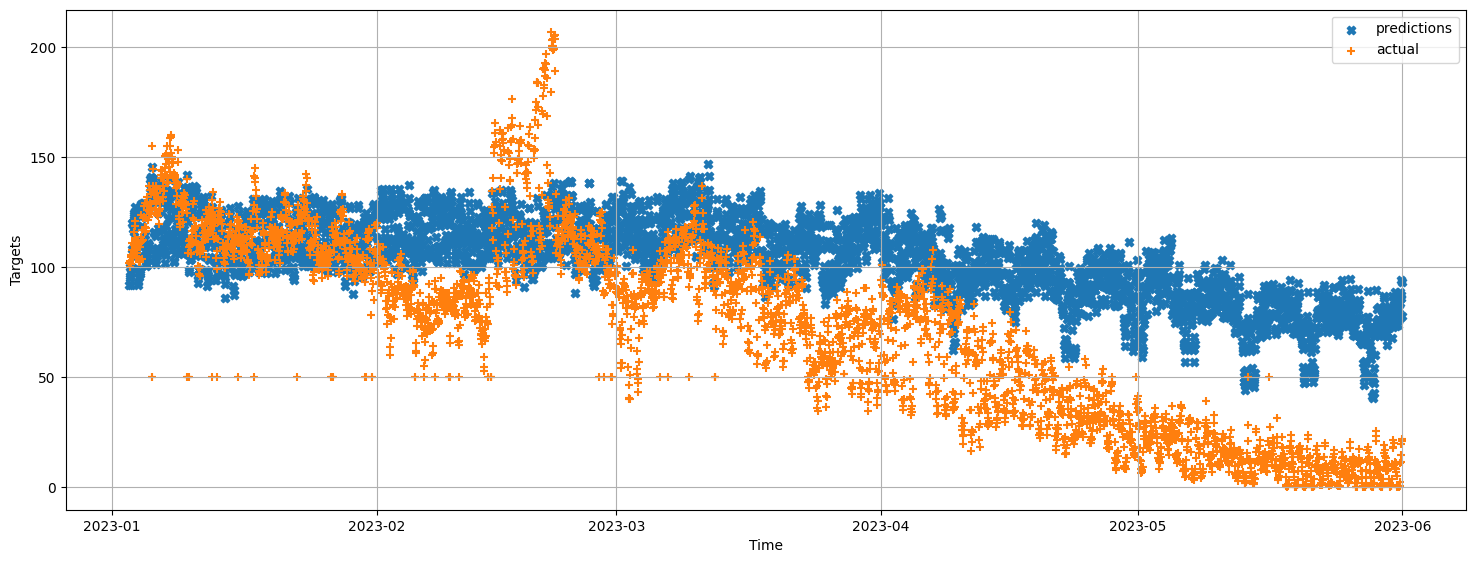

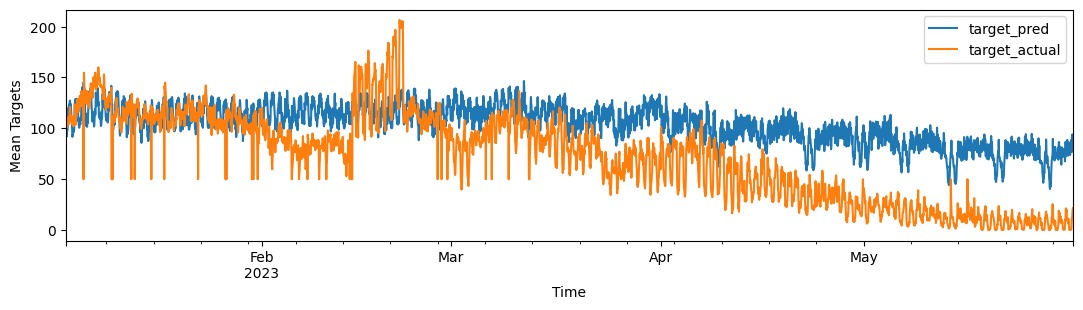

('target', '28')_c0


MAE        RMSE        R2
0  69.045662  305.254607  0.314277

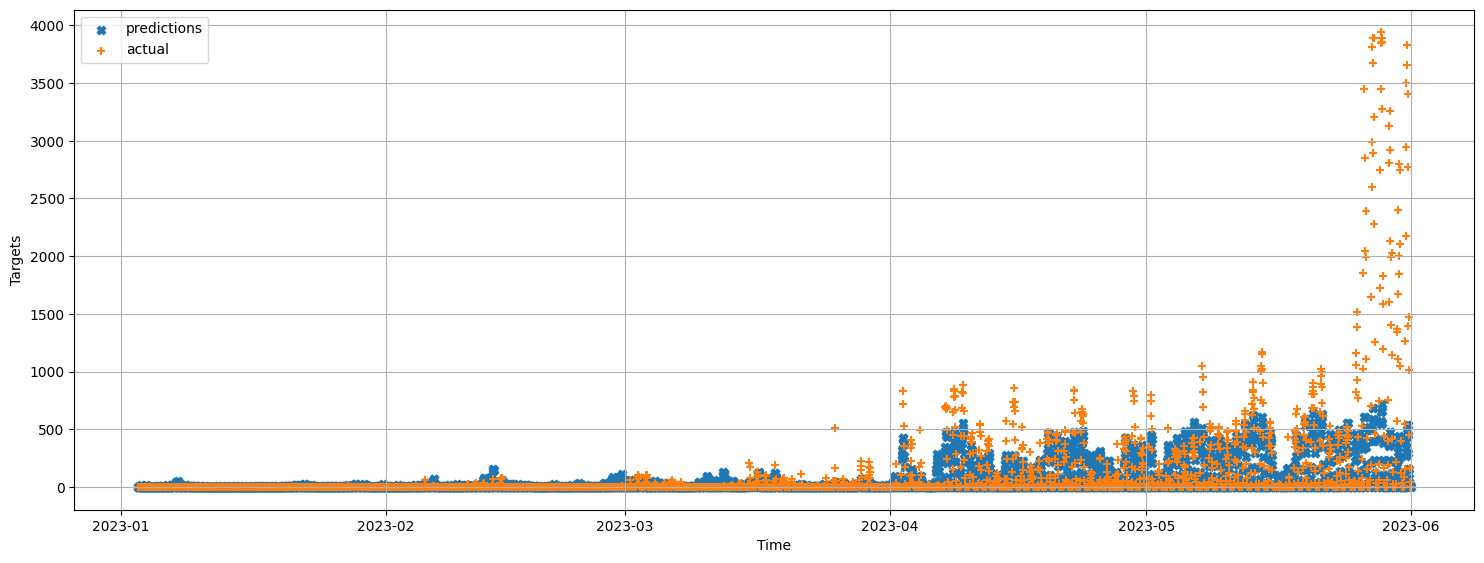

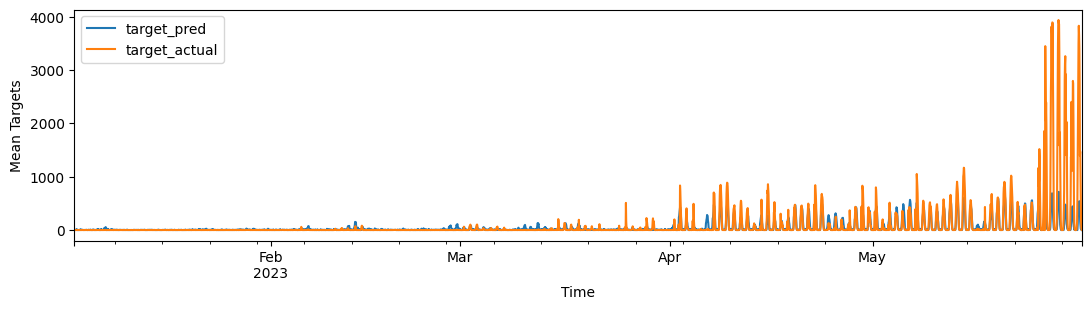

('target', '30')_c1


MAE        RMSE        R2
0  197.928238  255.789327  0.326571

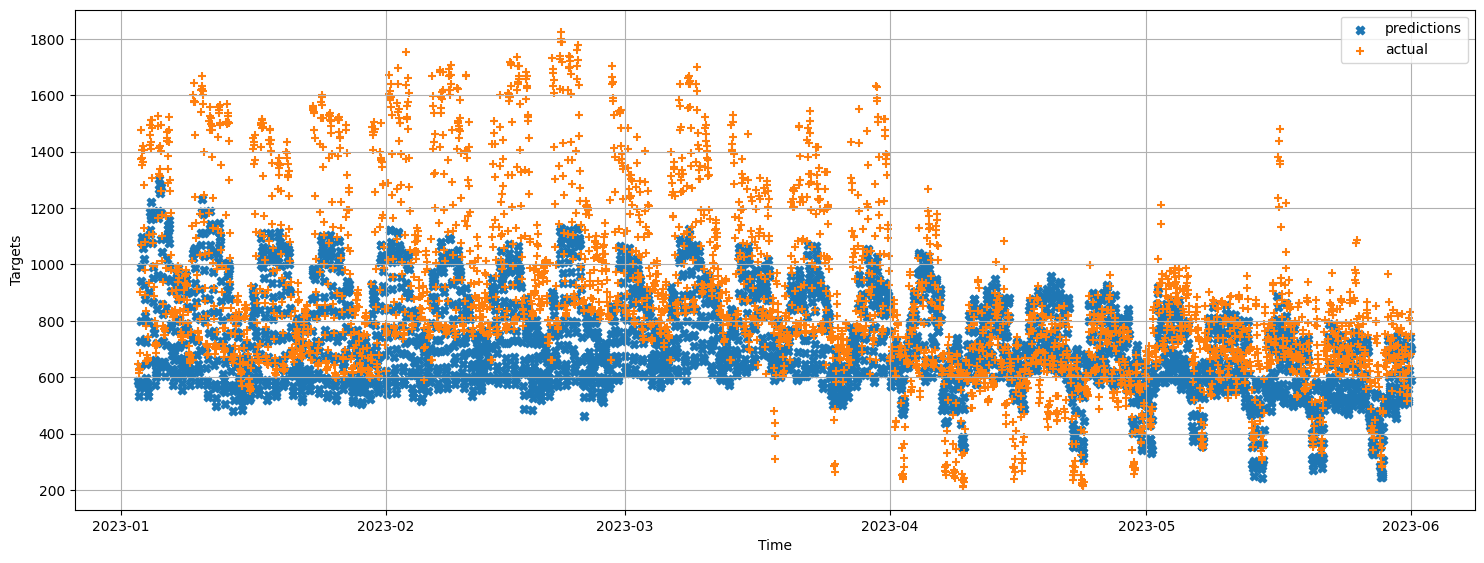

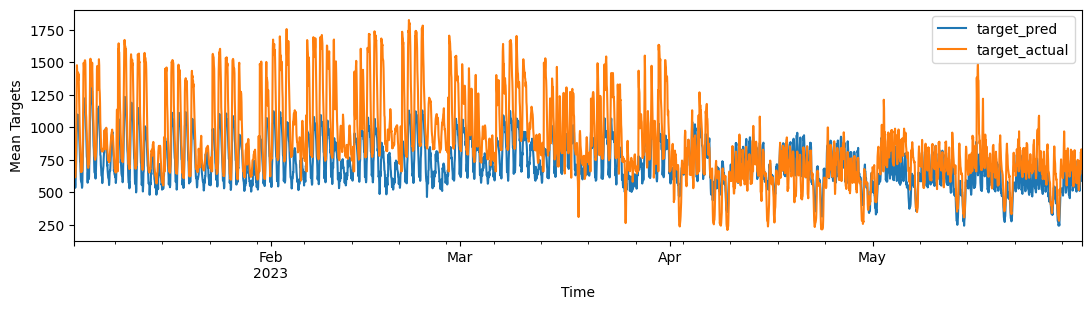

('target', '15')_c0


MAE       RMSE        R2
0  13.578086  32.060737  0.631053

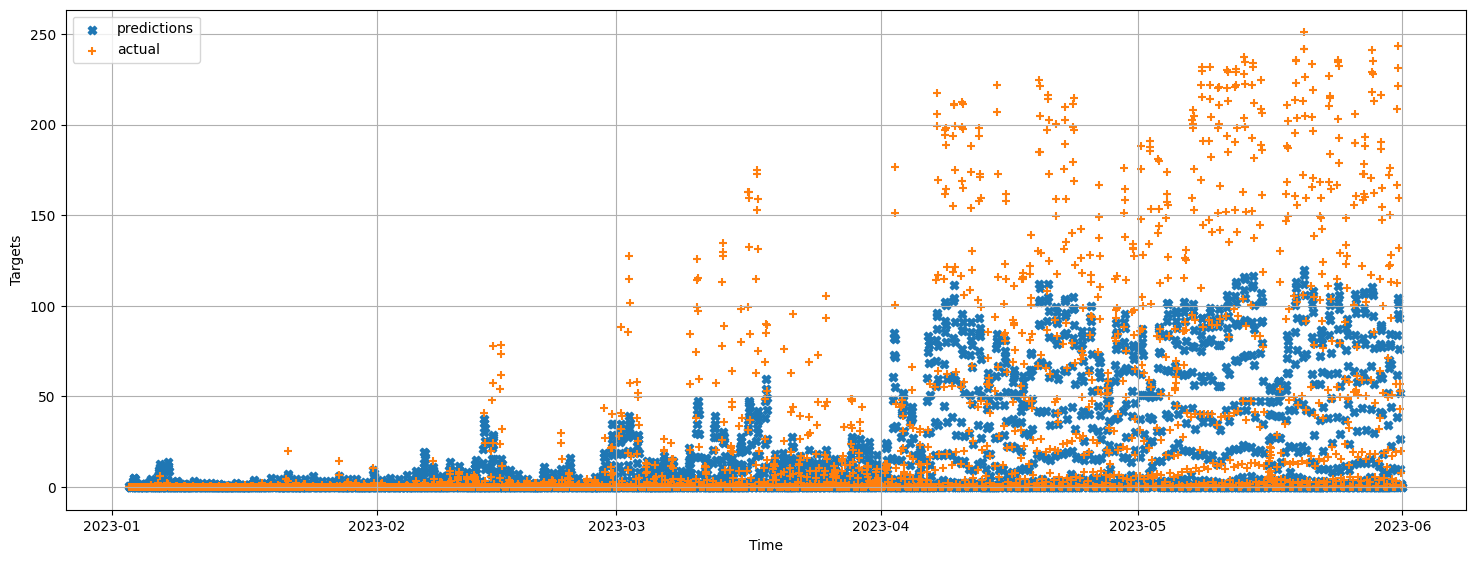

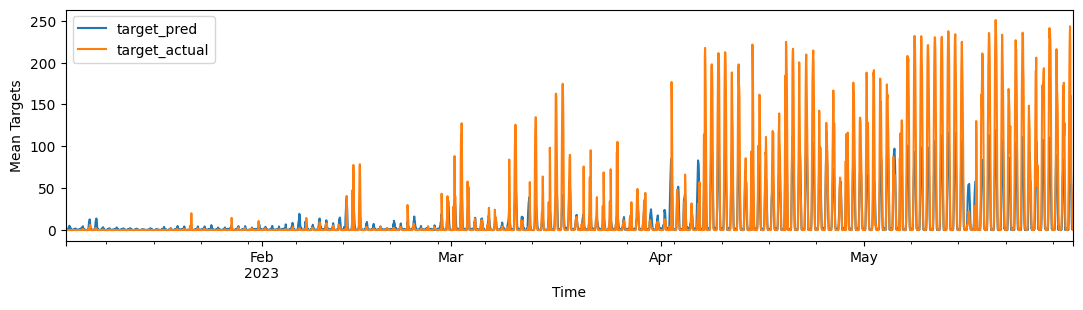

('target', '60')_c0


MAE        RMSE        R2
0  48.6381  109.330361  0.820311

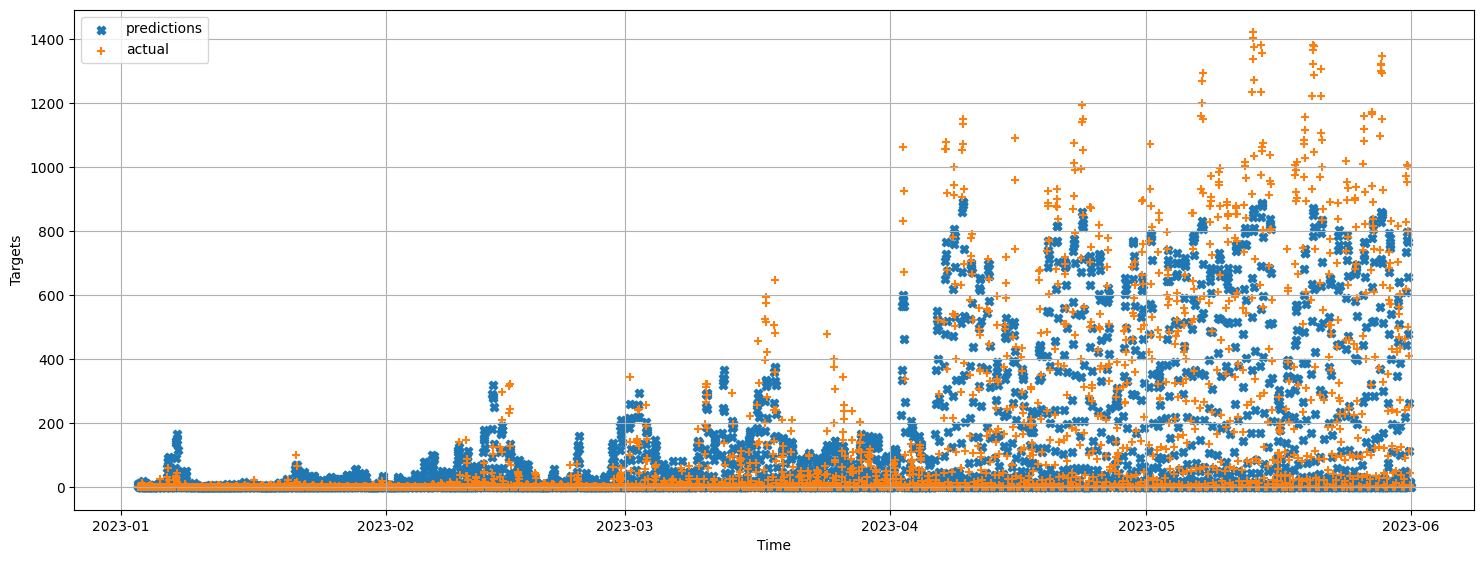

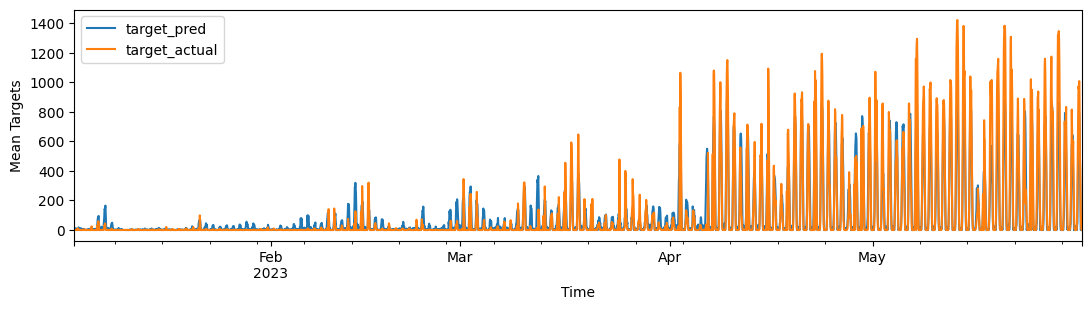

('target', '27')_c0


MAE        RMSE        R2
0  151.219955  332.326517  0.718493

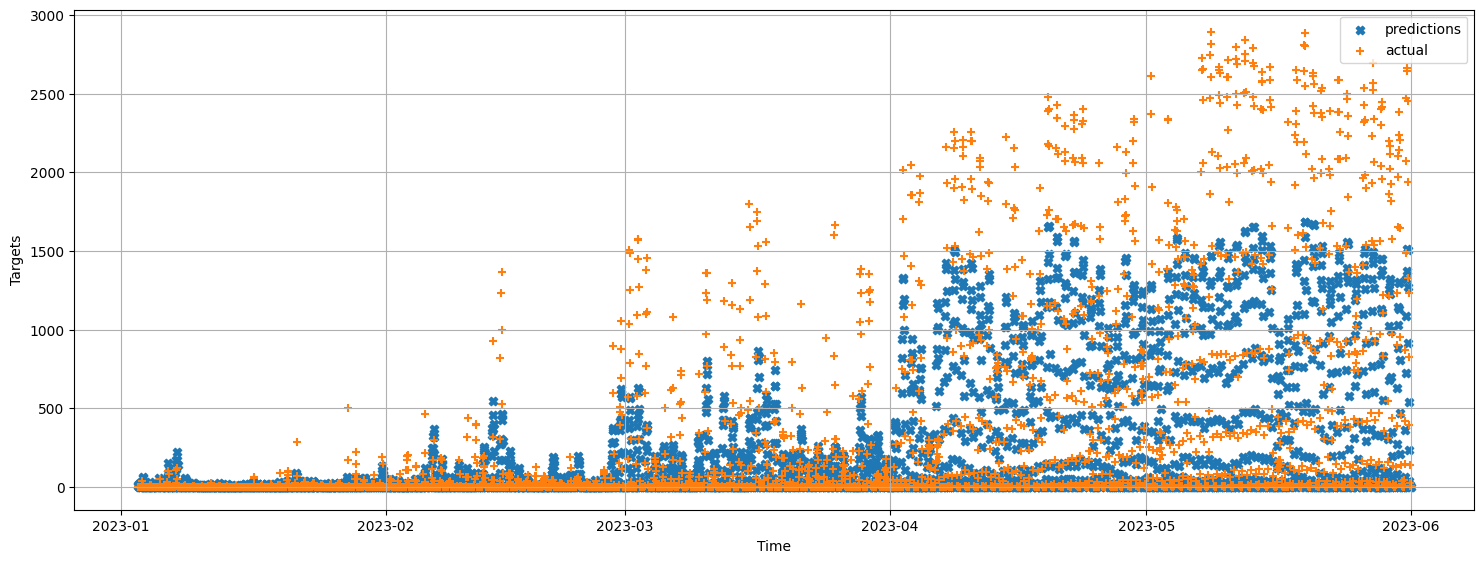

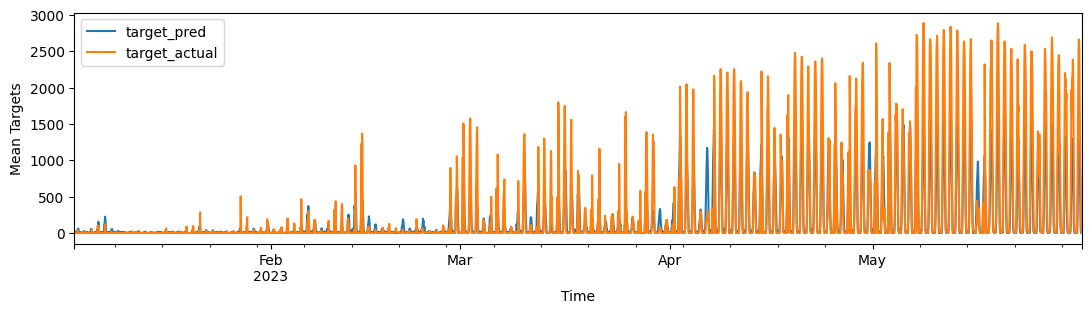

('target', '8')_c0


MAE       RMSE        R2
0  12.015372  25.011932  0.826262

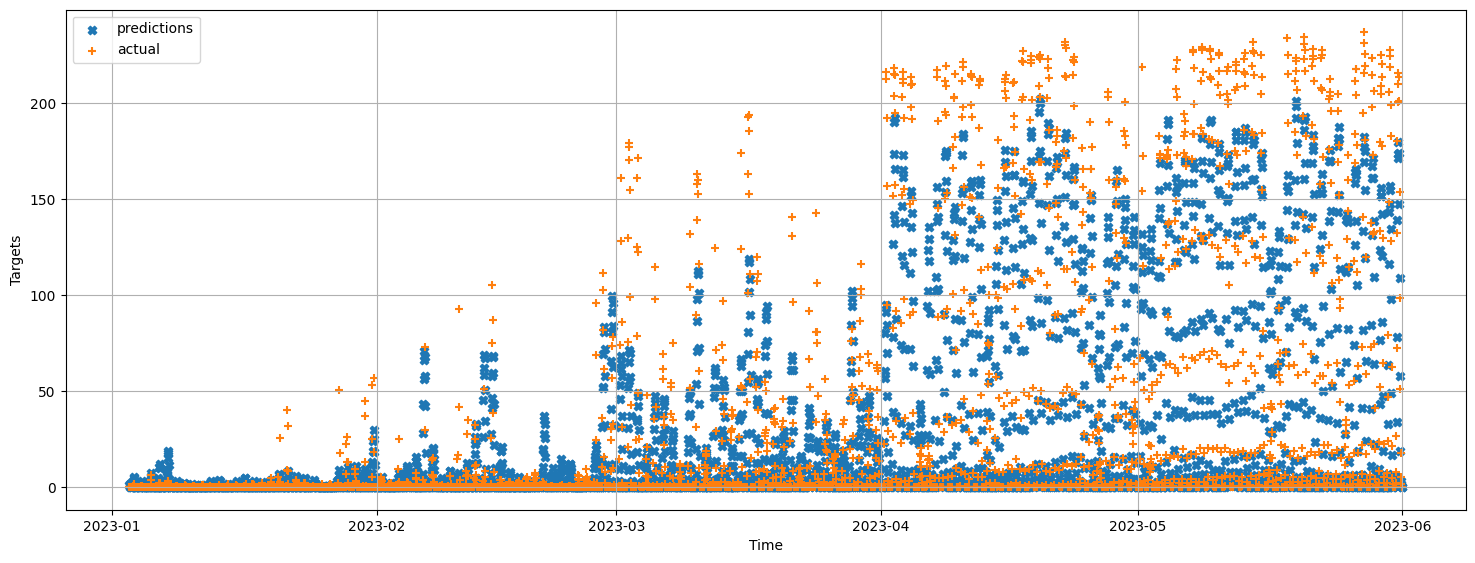

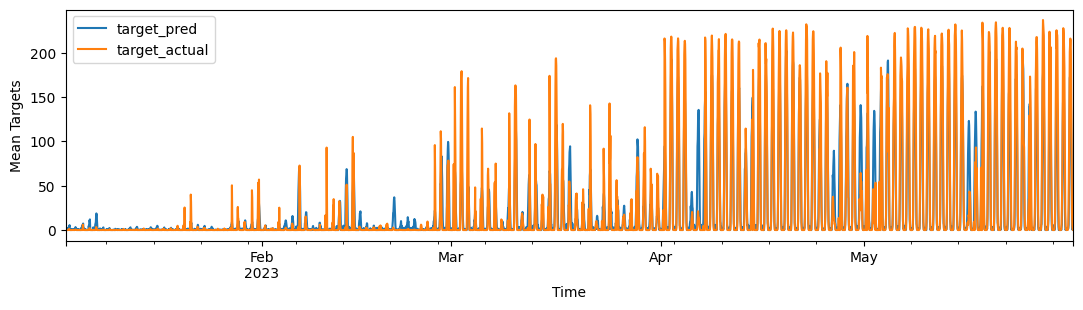

In [112]:
sample_ids_scoring=np.random.choice([x for x in df_pivoted.columns[:138]], 10 ,replace=False,)
for column in sample_ids_scoring:
    print(column)
    df_valid_correspondent=df_valid_pivot[df_valid_pivot.index>=df_pred_pivot.index[0]][column].reset_index()
    df_pred_correspondent=df_pred_pivot[df_pred_pivot.index<=df_valid_pivot.index[-1]][column].reset_index()
    display(calcMetrics(df_valid_correspondent[column], df_pred_correspondent[column]))
    df_column_actual_target=df_valid_correspondent.merge(df_pred_correspondent,on="index", suffixes=("_actual","_predictions"))
    df_column_actual_target=df_column_actual_target.reset_index().rename(columns=({"index":"datetime",
                                                                                  column+"_actual":"target_actual",
                                                                                  column+"_predictions":"target_pred"}))
    plot_series_multi(df_column_actual_target, "predictions","actual", format1="X",format2="+", start=0, end=None)

### Evaluating on test sets

In [113]:
def predict_test(test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction, loc_county, train_df,
                    scaler,scaler_predictions, model_c1,model_c0):

    # shrinking size of dfs
    test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction=shrink_size(test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction)

    # converting date columns to datetime utc
    date_cols=['date','forecast_date','origin_date','origin_datetime','forecast_datetime','datetime','prediction_datetime']
    test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction=convert_dt(test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction, date_cols=date_cols)

    # casting categorical columns to vartype string
    test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction=df_cast_dfs_cat_columns(test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction)

    # preprocessing-pivoting forecast weather as time series
    forecast_weather=process_forecast_weather(forecast_weather,loc_county)

    # preprocessing-pivoting historical weather
    historical_weather=process_historical_weather(historical_weather,loc_county)

    # merging client with revealed_targets as time series
    revealed_targets=merge_train_client(revealed_targets,client, place="revealed_targets")

    #imputing target, eic count and installed capacity which are logically 0 value
    revealed_targets=impute_logical_zeros(revealed_targets)

    # splitting revealed_targets by consumption to rejoin after pivoting
    revealed_targets_is_consumption_1, revealed_targets_is_consumption_0=split_by_consumption(revealed_targets)

    # resolving potential prediction unit id conflicts at id in test not in train
    revealed_targets_is_consumption_1, \
    df_prediction_unit_id_record_c1=predition_unit_id_check_correct(revealed_targets_is_consumption_1,  train_df)
    revealed_targets_is_consumption_0, \
    df_prediction_unit_id_record_c0=predition_unit_id_check_correct(revealed_targets_is_consumption_0, train_df)

    #df_prediction_unit_id_record_c0.to_csv("debug.csv")

    # resolving potential prediction unit id conflicts at id in train not in test
    revealed_targets_is_consumption_1=predition_unit_id_check_correct_2nd(revealed_targets_is_consumption_1, train_df)
    revealed_targets_is_consumption_0=predition_unit_id_check_correct_2nd(revealed_targets_is_consumption_0, train_df)

    # pivotting revealed_targets as time series
    num_cols_train=['target', 'eic_count', 'installed_capacity']
    revealed_targets_is_consumption_1=pivot_train_client(revealed_targets_is_consumption_1,num_cols_train)
    revealed_targets_is_consumption_0=pivot_train_client(revealed_targets_is_consumption_0,num_cols_train=['target'])

    # joining all to create global timeseries df
    df_pivoted=join_all(revealed_targets_is_consumption_1, revealed_targets_is_consumption_0,
                         historical_weather, forecast_weather,
                         electricity_prices, gas_prices)

    #handing outliers
    df_pivoted=treat_outliers(df_pivoted)

    # creating time signal at important frequencies
    df_pivoted=create_time_signals(df_pivoted)
    #display(df_pivoted, df_pivoted.shape)
    #df_pivoted.to_csv("debug.csv")

    #adding holidays
    df_pivoted=add_holiday(df_pivoted)

    #display(df_pivoted.head(2),df_pivoted.tail(2))

    df_pivoted_time_revealed_targets=np.array(df_pivoted.index)
    df_pivoted_series_revealed_targets=np.array(df_pivoted)


    df_scaled_series_revealed_targets=scaler.transform(df_pivoted_series_revealed_targets)
    # imputing missing values in timeseries
    df_scaled_series_revealed_targets=interpolate(df_scaled_series_revealed_targets)

    # making a forecast with model
    dnn_forecast_c1 = model_forecast(model_c1,df_scaled_series_revealed_targets, G.WINDOW_SIZE).squeeze()
    dnn_forecast_c0 = model_forecast(model_c0,df_scaled_series_revealed_targets, G.WINDOW_SIZE).squeeze()
    dnn_forecast_whole=np.concatenate((dnn_forecast_c1 ,dnn_forecast_c0), axis=-1)

    dnn_forecast_unscale=scaler_predictions.inverse_transform(dnn_forecast_whole.reshape(-1,dnn_forecast_whole.shape[-1]))
    dnn_forecast_unscale[dnn_forecast_unscale<0]=0

    #display(dnn_forecast_unscale)

    #converting prediction to dataframe
    dnn_forecast_time=df_pivoted_time_revealed_targets+pd.to_timedelta(48,unit='h')
    df_pred_pivot=pd.DataFrame(data=dnn_forecast_unscale, index=dnn_forecast_time[:],
                               columns=df_pivoted.columns[:138])

    #display(df_pred_pivot)

    df_pred_reshape=pd.melt(df_pred_pivot.reset_index(), id_vars=['index'],value_vars=df_pred_pivot.columns)

    df_pred_reshape[['prediction_unit_id','is_consumption']]=df_pred_reshape['variable'].\
                                                str.split("'|_c",expand=True)[[3,5]]

    df_pred_reshape=df_pred_reshape.drop(['variable'], axis=1).rename(columns={'index':'datetime'})


    df_pred_reshape["is_consumption"]=np.where(df_pred_reshape["is_consumption"]=="1","True","False")


    test=test.rename(columns={"prediction_datetime":"datetime"})
    test, \
    df_test_unit_id_record=predition_unit_id_check_correct(test,  train_df)

    test_pred=test.merge(df_pred_reshape,
                       on=["datetime","is_consumption","prediction_unit_id"],
                       how="left",validate="many_to_one").rename(columns={"value":"target"})

    return test_pred['target'].astype(np.float64)

### Submission

In [114]:
import enefit
env= enefit.make_env()
iter_test = env.iter_test()

In [115]:
for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    testset_preds=predict_test(test, revealed_targets, client, historical_weather, \
                    forecast_weather, electricity_prices, gas_prices, \
                    sample_prediction, loc_county, train,
                    scaler,scaler_predictions, model_c1,model_c0)
    sample_prediction['target']=[x for x in testset_preds]
    #sample_prediction["target"].fillna(0.0, inplace=True)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 141ms/step
